#About Jamboree
---
**Jamboree has helped thousands of students like you make it to top colleges abroad. Be it GMAT, GRE or SAT, their unique problem-solving methods ensure maximum scores with minimum effort.
They recently launched a feature where students/learners can come to their website and check their probability of getting into the IVY league college. This feature estimates the chances of graduate admission from an Indian perspective.**

---

#Problem Statement

---

Analyze to help Jamboree in understanding what factors are important in graduate admissions and how these factors are interrelated among themselves. It will also help predict one's chances of admission given the rest of the variables.

---

[Colab](https://colab.research.google.com/drive/1bxn1Eb43hsYnt1Y_dUXoQROBSfsprhDu?usp=sharing)

#Import Libraries

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import textwrap
#import warnings
#warnings.filterwarnings('ignore')

from scipy.stats import shapiro

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Load Dataset

In [105]:
df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/839/original/Jamboree_Admission.csv')

df_bak = df.copy(deep = True)
np.shares_memory(df, df_bak)

False

#Utility Functions

In [106]:
def bar_plots(df, cat_cols, secondary_col="Chance of Admission",
              top_n=None, show_percent=True, color="royalblue", wrap_len=15):
    """
    Generates bar plots for categorical columns, showing distribution and
    the average of a secondary numerical column (e.g., 'Chance of Admission').

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - cat_cols (list): A list of categorical column names to plot.
    - secondary_col (str): The name of the numerical column to calculate the mean for (default: 'Chance of Admission').
    - top_n (int, optional): If provided, only shows the top_n categories for columns with many unique values.
    - show_percent (bool): Whether to display percentage on bars (default: True).
    - color (str): Color for the bar plots (default: 'royalblue').
    - wrap_len (int): Character limit for wrapping x-axis labels (default: 15).
    """

    few_cat_cols = [col for col in cat_cols if df[col].nunique() < 10]
    many_cat_cols = [col for col in cat_cols if df[col].nunique() >= 10]

    # -------------------
    # Few categories (<10)
    # -------------------
    if few_cat_cols:
        n_cols = 2
        n_rows = int(np.ceil(len(few_cat_cols) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
        axes = axes.flatten()

        for i, col in enumerate(few_cat_cols):

            counts = df[col].value_counts().sort_index(ascending=False)
            plot_data = counts.reset_index()
            plot_data.columns = [col, "count"]
            total = plot_data["count"].sum()

            secondary_mean = df.groupby(col, observed=False)[secondary_col].mean().reindex(plot_data[col]).values

            ax = axes[i]
            sns.barplot(x=col, y="count", data=plot_data, ax=ax, color=color)

            ax.set_title(f"{col} Distribution", fontsize=14, fontweight="bold", pad=15)
            ax.set_ylabel("Count", fontsize=12)
            ax.set_xlabel(col, fontsize=12)

            labels = ["\n".join(textwrap.wrap(str(l), wrap_len)) for l in plot_data[col].astype(str)]
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, ha="right", fontsize=10)

            y_max = plot_data["count"].max()
            ax.set_ylim(0, y_max * 1.2)

            for p, count_val in zip(ax.patches, plot_data["count"]):
                label = f"{count_val}\n({count_val / total * 100:.1f}%)" if show_percent else f"{count_val}"
                ax.annotate(label,
                            (p.get_x() + p.get_width() / 2., p.get_height() + y_max * 0.02),
                            ha="center", va="bottom",
                            fontsize=10, fontweight="bold")

            # ---- Chance of Admission line ----
            ax2 = ax.twinx()
            ax2.set_prop_cycle(color=["crimson"])   # <<< FORCE COLOR HERE

            x_vals = np.arange(len(secondary_mean))
            ax2.plot(
                x_vals, secondary_mean,
                marker="o",
                markersize=8,
                linewidth=3,
                linestyle="-"
            )

            ax2.set_ylim(0, 1)
            ax2.set_ylabel("Avg Chance of Admission", fontsize=11)

            for x, y in zip(x_vals, secondary_mean):
                ax2.annotate(
                    f"{y:.2f}",
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, 8),
                    ha="center",
                    fontsize=10,
                    fontweight="bold"
                )

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    # -------------------
    # Many categories (>=10)
    # -------------------
    for col in many_cat_cols:

        counts = df[col].value_counts().sort_index(ascending=False)

        if top_n is not None and top_n < len(counts):
            top_counts = counts.head(top_n)
            other_count = counts.sum() - top_counts.sum()
            plot_data = pd.concat([top_counts, pd.Series({"Other": other_count})])
        else:
            plot_data = counts

        plot_data = plot_data.reset_index()
        plot_data.columns = [col, "count"]
        total = plot_data["count"].sum()

        secondary_mean = (
            df.groupby(col, observed=False)[secondary_col]
            .mean()
            .reindex(plot_data[col])
            .fillna(df[secondary_col].mean())
            .values
        )

        plt.figure(figsize=(16, 6))
        ax = sns.barplot(x=col, y="count", data=plot_data, color=color)
        ax.grid(False)
        ax.set_title(f"{col} Distribution", fontsize=14, fontweight="bold", pad=15)
        ax.set_ylabel("Count", fontsize=12)
        ax.set_xlabel(col, fontsize=12)

        labels = ["\n".join(textwrap.wrap(str(l), wrap_len)) for l in plot_data[col].astype(str)]
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, ha="right", fontsize=10)

        y_max = plot_data["count"].max()
        ax.set_ylim(0, y_max * 1.2)

        for p, count_val in zip(ax.patches, plot_data["count"]):
            label = f"{count_val}\n({count_val / total * 100:.1f}%)" if show_percent else f"{count_val}"
            ax.annotate(label,
                        (p.get_x() + p.get_width() / 2., p.get_height() + y_max * 0.02),
                        ha="center", va="bottom",
                        fontsize=10, fontweight="bold")

        # ---- Chance of Admission line ----
        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.set_prop_cycle(color=["crimson"])   # <<< FORCE COLOR HERE

        x_vals = np.arange(len(secondary_mean))
        ax2.plot(
            x_vals, secondary_mean,
            marker="o",
            markersize=8,
            linewidth=3,
            linestyle="-"
        )

        ax2.set_ylim(0, 1)
        ax2.set_ylabel("Avg Chance of Admission", fontsize=11)

        for x, y in zip(x_vals, secondary_mean):
            ax2.annotate(
                f"{y:.2f}",
                (x, y),
                textcoords="offset points",
                xytext=(0, 8),
                ha="center",
                fontsize=10,
                fontweight="bold"
            )

        plt.tight_layout()
        plt.show()

In [107]:
def numerical_columns_distribution_with_stats(df, cols = None):
    """
    Generates and displays histograms, boxplots, and density plots for numerical columns
    in a DataFrame, along with key descriptive statistics.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - cols (list, optional): A list of numerical column names to plot. If None,
                             it defaults to all numerical columns (excluding object, category, datetime dtypes).
    """
    if cols is None:
        cols=df.select_dtypes(exclude=['object', 'category', 'datetime']).columns
    for col in cols:

      data = df[col].dropna()

      # Calculate statistics
      mean_val = data.mean()
      median_val = data.median()
      std_val = data.std()
      min_val = data.min()
      max_val = data.max()

      # Print statistics
      print(f"Statistics for {col}:")
      print(f"  Mean   : {mean_val:.2f}")
      print(f"  Median : {median_val:.2f}")
      print(f"  Std Dev: {std_val:.2f}")
      print(f"  Min    : {min_val:.2f}")
      print(f"  Max    : {max_val:.2f}")

      plt.figure(figsize=(15, 5))

      # Histogram
      plt.subplot(1, 3, 1)
      #plt.hist(data, bins=30, color='skyblue', edgecolor='black')
      sns.histplot(
        data=df,             # your DataFrame
        x=data,        # column to plot
        bins=30,             # number of bins
        kde=True,            # add kernel density estimate
        color='royalblue',   # bar color
        edgecolor='black',   # edge of bars
        stat='density'       # normalize histogram to density (optional)
        )
      plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
      plt.axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.2f}")
      plt.title(f"Histogram of {col}")
      plt.xlabel(f"{col} Amount")
      plt.ylabel("Frequency")
      plt.legend()

      # Boxplot
      plt.subplot(1, 3, 2)
      sns.boxplot(x=data, color='orange')
      plt.title(f"Boxplot of {col}")
      plt.xlabel(f"{col} Amount")
      plt.text(mean_val, 0.02, f"Mean: {mean_val:.2f}", ha='center', color='red')
      plt.text(median_val, -0.05, f"Median: {median_val:.2f}", ha='center', color='green')

      # Density plot
      plt.subplot(1, 3, 3)
      sns.kdeplot(data, fill=True, color='green')
      plt.axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
      plt.axvline(median_val, color='blue', linestyle='--', label=f"Median: {median_val:.2f}")
      plt.title(f"Density Plot of {col}")
      plt.xlabel(f"{col} Amount")
      plt.legend()

      plt.tight_layout()
      plt.show()

In [108]:
def iqr_outliers_boxplot(df):
    """
    Detects outliers in numeric columns using the IQR method.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Note: The commented-out section for plotting boxplots can be uncommented
    to visualize outliers for each numeric column.
    """
    sns.set_palette("deep")  # Deep solid color theme
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]

        print(f"\nColumn: {col}")
        print(f"Number of outliers (IQR method): {len(outliers)}")

        # # Boxplot
        # plt.figure(figsize=(6,4))
        # sns.boxplot(x=df[col], color='royalblue')
        # plt.title(f'Boxplot of {col}')
        # plt.show()

In [234]:
def plot_model_weights(coef_df, fig_size = (8, 5)):
    """
    Plots the absolute coefficients (weights) of features from a regression model.

    Parameters:
    - coef_df (pd.DataFrame): DataFrame containing 'Feature' and 'Abs_Coefficient' columns.
    - fig_size (tuple, optional): Size of the plot figure (width, height). Defaults to (8, 5).
    """
    sns.set_theme(
        style="dark",
        rc={
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "font.size": 9
        }
    )

    plt.figure(figsize=fig_size)

    sns.barplot(
        data=coef_df,
        x="Abs_Coefficient",
        y="Feature",
        palette = 'viridis',
        hue = 'Feature'
    )

    plt.title(
        "Weights of Features",
        pad=8
    )
    plt.xlabel("Absolute Coefficient")
    plt.ylabel("")

    for i, v in enumerate(coef_df["Abs_Coefficient"]):
        plt.text(
            v + 0.01,
            i,
            f"{v:.4f}",
            va="center",
            fontsize=8,
            color="black"
        )

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

#Analysis

In [110]:
df.shape

(500, 9)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


Dataset has no null values.


Column Profiling:

    - Serial No. (Unique row ID)
    - GRE Scores (out of 340)
    - TOEFL Scores (out of 120)
    - University Rating (out of 5)
    - Statement of Purpose and Letter of Recommendation Strength (out of 5)
    - Undergraduate GPA (out of 10)
    - Research Experience (either 0 or 1)
    - Chance of Admit (ranging from 0 to 1)

- `Serial No.`: This column represents the unique row identifier for each applicant in the
dataset.
- `GRE Scores`: This column contains the GRE (Graduate Record Examination) scores of
the applicants, which are measured on a scale of 0 to 340.
- `TOEFL Scores`: This column includes the TOEFL (Test of English as a Foreign Language)
scores of the applicants, which are measured on a scale of 0 to 120.
- `University Rating`: This column indicates the rating or reputation of the university that
the applicants are associated with.
    - The rating is based on a scale of 0 to 5, with 5 representing the highest rating.
- `SOP`: This column represents the strength of the applicant's statement of purpose,
rated on a scale of 0 to 5, with 5 indicating a strong and compelling SOP.
- `LOR`: This column represents the strength of the applicant's letter of recommendation,
rated on a scale of 0 to 5, with 5 indicating a strong and compelling LOR.
- `CGPA`: This column contains the undergraduate Grade Point Average (GPA) of the
applicants, which is measured on a scale of 0 to 10.
- `Research`: This column indicates whether the applicant has research experience (1) or
not (0).
- `Chance of Admit`: This column represents the estimated probability or chance of
admission for each applicant, ranging from 0 to 1.

In [112]:
df.sample(5)

Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
396         397        325          107                  3  3.0   3.5  9.11   
251         252        316           99                  2  2.5   3.0  9.00   
81           82        340          120                  4  5.0   5.0  9.50   
79           80        294           93                  1  1.5   2.0  7.36   
91           92        299           97                  3  5.0   3.5  7.66   

     Research  Chance of Admit   
396         1              0.84  
251         0              0.70  
81          1              0.96  
79          0              0.46  
91          0              0.38

In [113]:
df.head()

Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

Serial No. column is not needed because its just row number(i.e. unique row identifier and I don’t want our model to build some understanding based on this.

In [114]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [115]:
df.drop(columns = ['Serial No.'], inplace = True)

In [116]:
df.head()

GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research  \
0        337          118                  4  4.5   4.5  9.65         1   
1        324          107                  4  4.0   4.5  8.87         1   
2        316          104                  3  3.0   3.5  8.00         1   
3        322          110                  3  3.5   2.5  8.67         1   
4        314          103                  2  2.0   3.0  8.21         0   

   Chance of Admit   
0              0.92  
1              0.76  
2              0.72  
3              0.80  
4              0.65

In [117]:
df.describe().T

count       mean        std     min       25%     50%  \
GRE Score          500.0  316.47200  11.295148  290.00  308.0000  317.00   
TOEFL Score        500.0  107.19200   6.081868   92.00  103.0000  107.00   
University Rating  500.0    3.11400   1.143512    1.00    2.0000    3.00   
SOP                500.0    3.37400   0.991004    1.00    2.5000    3.50   
LOR                500.0    3.48400   0.925450    1.00    3.0000    3.50   
CGPA               500.0    8.57644   0.604813    6.80    8.1275    8.56   
Research           500.0    0.56000   0.496884    0.00    0.0000    1.00   
Chance of Admit    500.0    0.72174   0.141140    0.34    0.6300    0.72   

                      75%     max  
GRE Score          325.00  340.00  
TOEFL Score        112.00  120.00  
University Rating    4.00    5.00  
SOP                  4.00    5.00  
LOR                  4.00    5.00  
CGPA                 9.04    9.92  
Research             1.00    1.00  
Chance of Admit      0.82    0.97

***GRE Score***

- Average: 316.47
- Middle applicant (median): 317
- Typical range: 308 - 325 (middle 50%)
- Overall range: 290 - 340

*Meaning:*

Most applicants have strong GRE scores, clustered tightly around the 317. Very low scores are uncommon, and perfect or near-perfect scores exist but are rare

---

***TOEFL Score***

- Average: 107.19
- Median: 107
- Typical range: 103 - 112
- Overall range: 92 - 120

*Meaning:*

Almost all applicants meet or exceed English proficiency requirements. Scores don't vary much.

---

***University Rating***

- Average: 3.11
- Median: 3
- Typical range: 2 - 4
- Overall range: 1 - 5

*Meaning:*

Applicants mostly come from mid to well-rated universities, with some from top and some from lower-ranked institutions.

---

***SOP (Statement of Purpose)***

- Average: 3.37
- Median: 3.5
- Typical range: 2.5 - 4.0
- Overall range: 1 - 5

*Meaning:*

Most applicants submit good SOPs, but truly exceptional ones are rare.

---

***LOR (Letters of Recommendation)***

- Average: 3.48
- Median: 3.5
- Typical range: 3.0 - 4.0
- Overall range: 1 - 5

*Meaning:*

Recommendation letters are generally positive and consistent. Extreme cases (very weak or very strong letters) are uncommon.

---

***CGPA***

- Average: 8.58
- Median: 8.56
- Typical range: 8.13 - 9.04
- Overall range: 6.8 - 9.92

*Meaning:*

Academic performance is consistently strong across applicants. Differences are small.

---

***Chance of Admit***

- Average: 0.72 (72%)
- Median: 0.72
- Typical range: 63% - 82%
- Overall range: 34% - 97%

*Meaning:*

Most applicants in this dataset have a high probability of admission.



In [118]:
cols = df.columns
cols = cols.drop('Research')
cols

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Chance of Admit '],
      dtype='object')

Statistics for GRE Score:
  Mean   : 316.47
  Median : 317.00
  Std Dev: 11.30
  Min    : 290.00
  Max    : 340.00


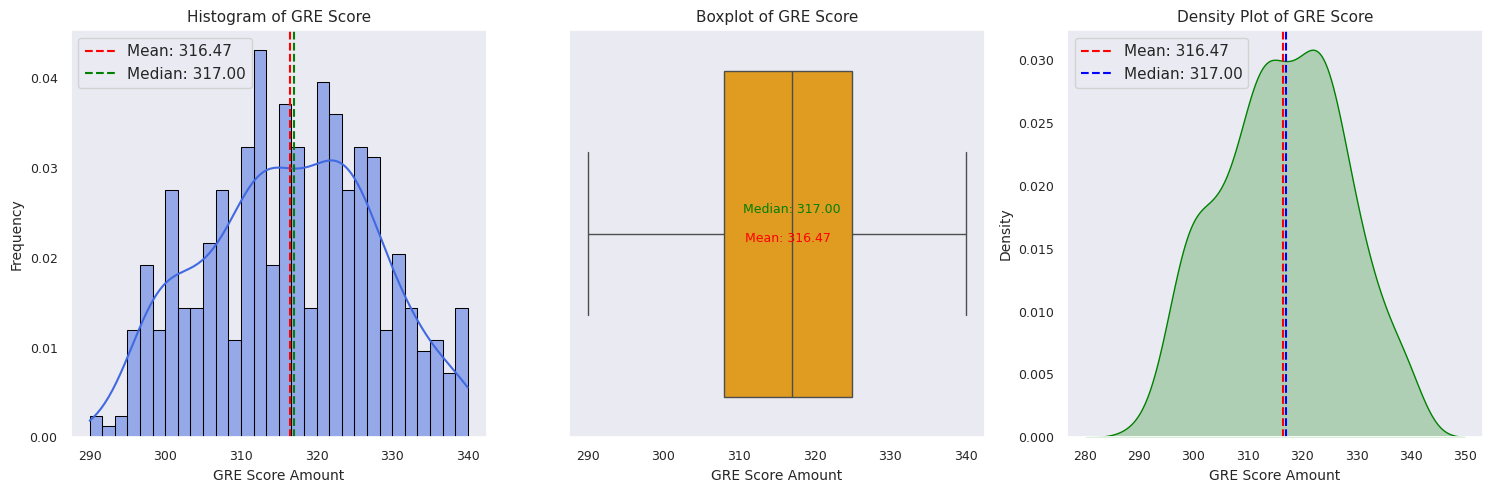

Statistics for TOEFL Score:
  Mean   : 107.19
  Median : 107.00
  Std Dev: 6.08
  Min    : 92.00
  Max    : 120.00


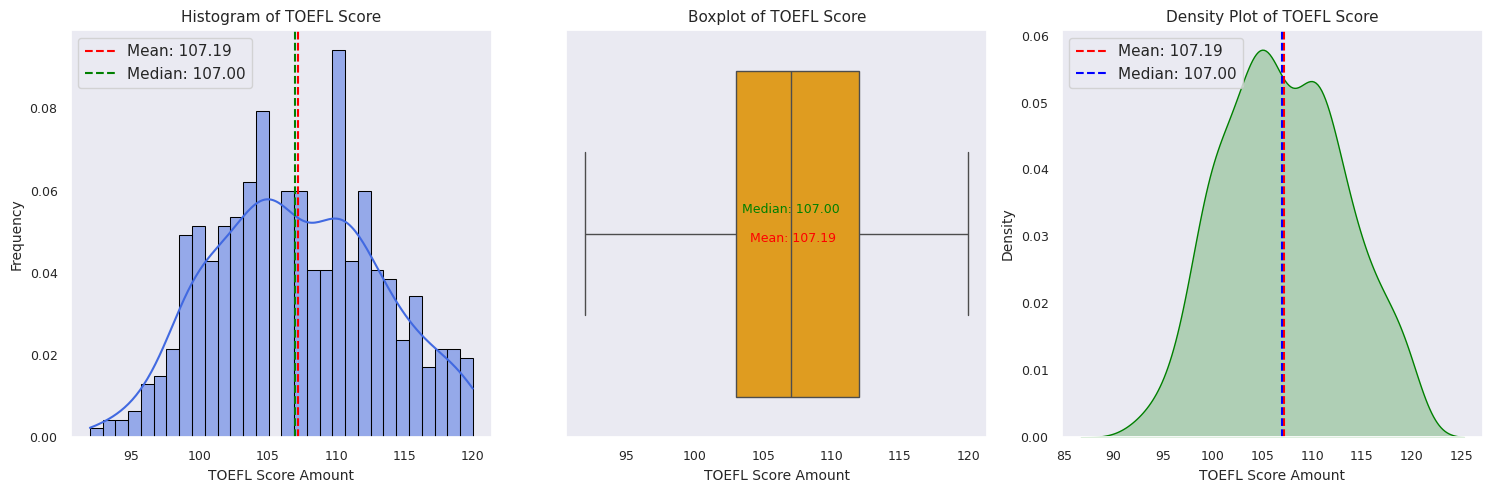

Statistics for University Rating:
  Mean   : 3.11
  Median : 3.00
  Std Dev: 1.14
  Min    : 1.00
  Max    : 5.00


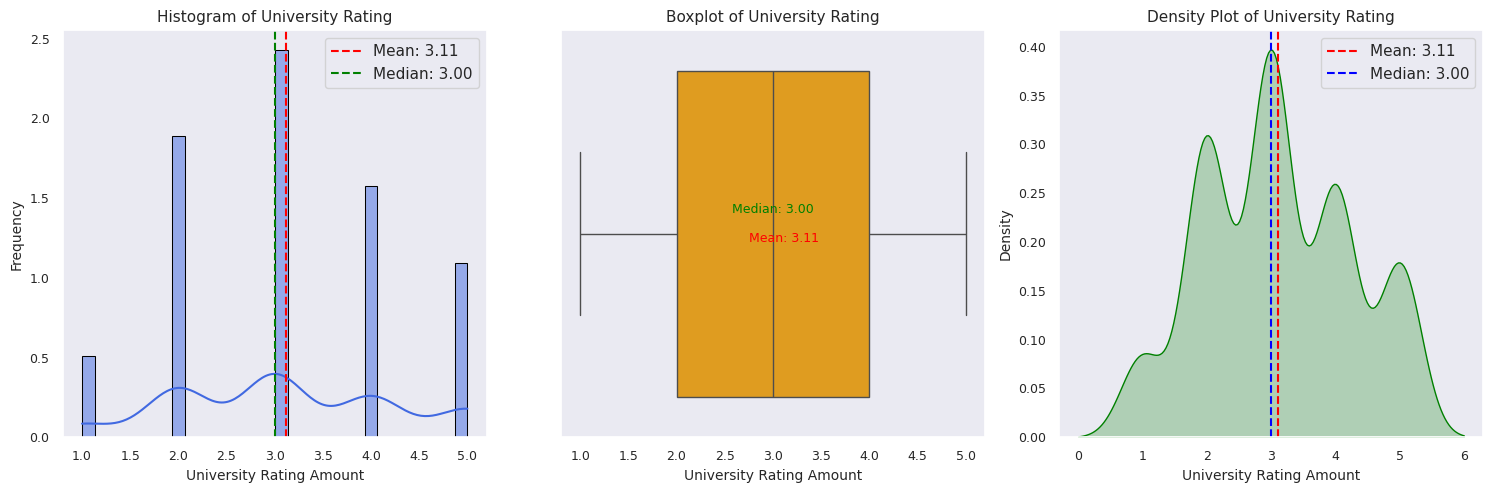

Statistics for SOP:
  Mean   : 3.37
  Median : 3.50
  Std Dev: 0.99
  Min    : 1.00
  Max    : 5.00


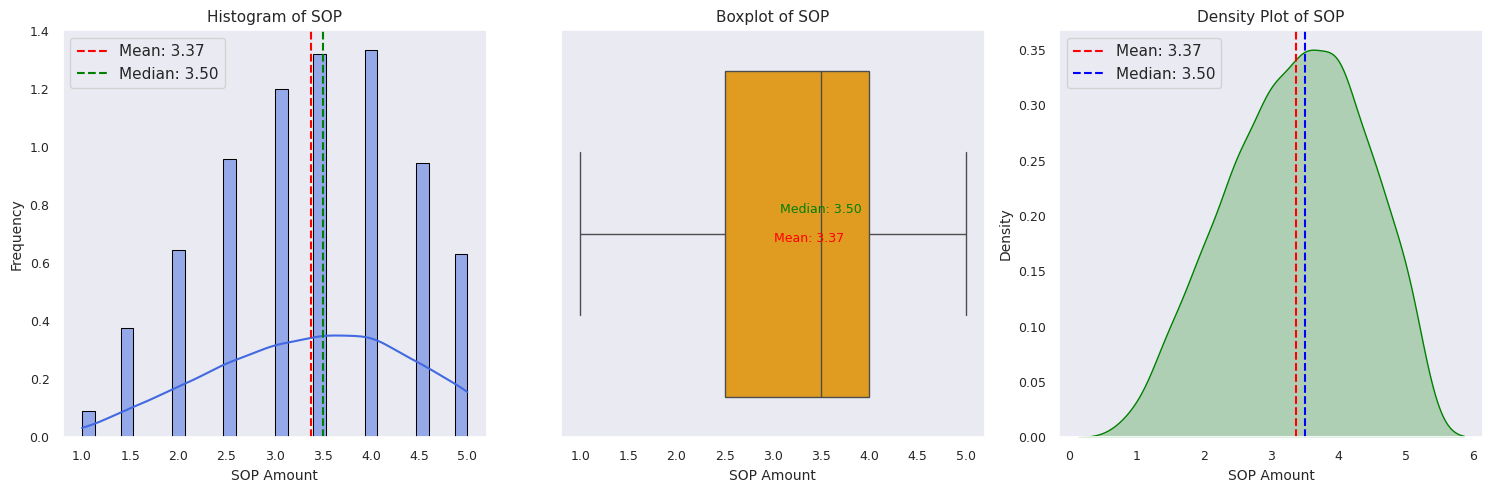

Statistics for LOR :
  Mean   : 3.48
  Median : 3.50
  Std Dev: 0.93
  Min    : 1.00
  Max    : 5.00


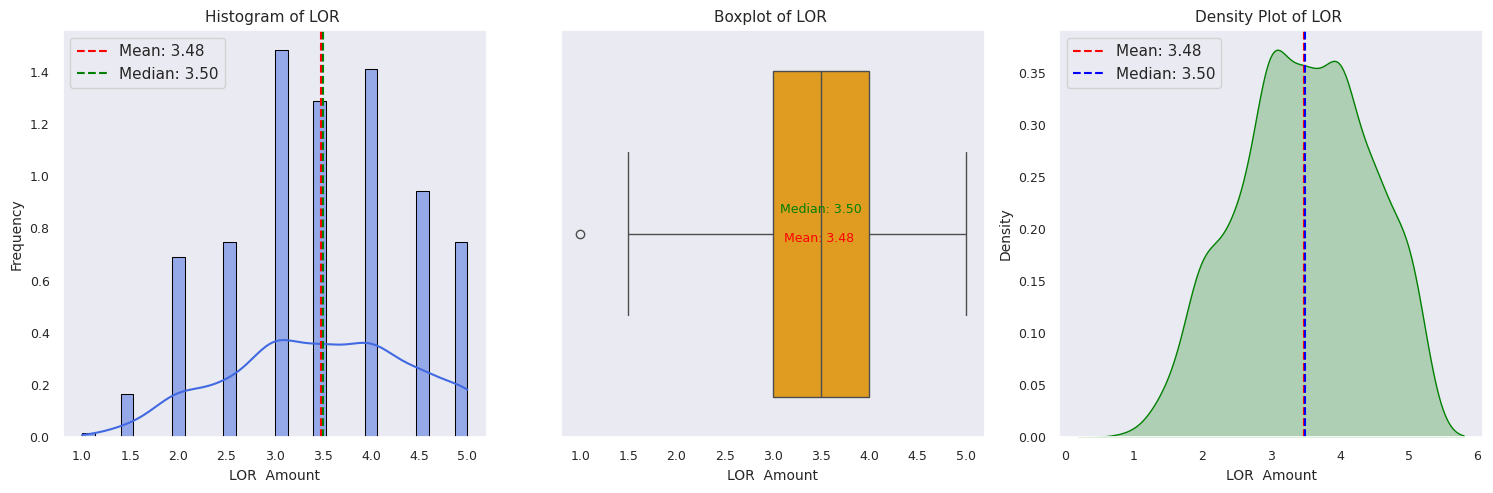

Statistics for CGPA:
  Mean   : 8.58
  Median : 8.56
  Std Dev: 0.60
  Min    : 6.80
  Max    : 9.92


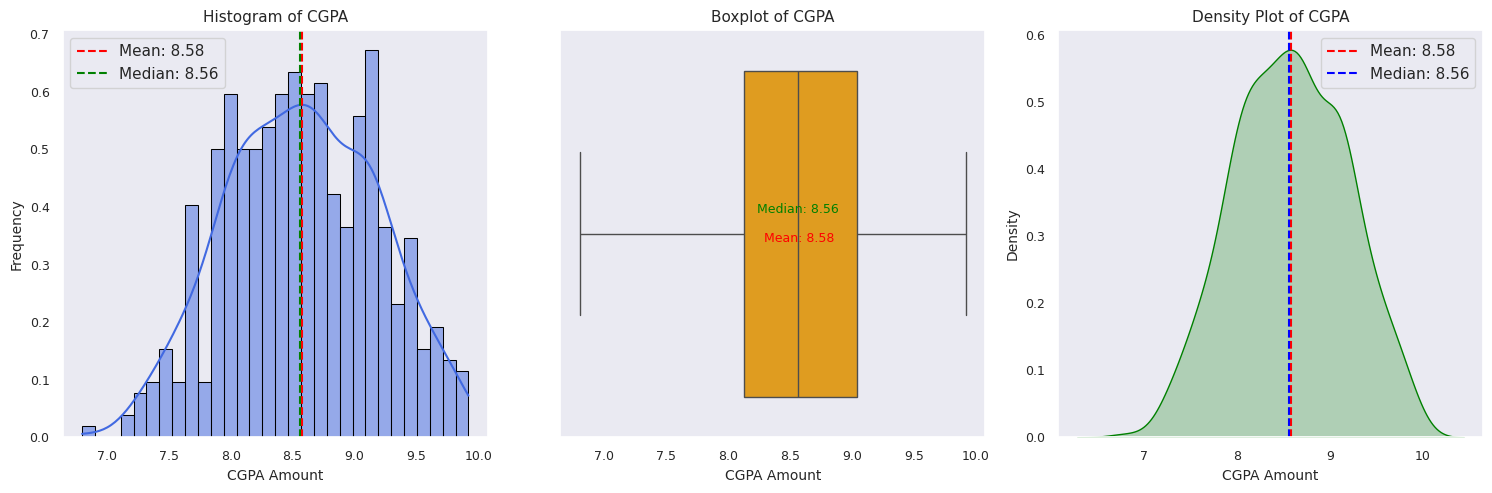

Statistics for Chance of Admit :
  Mean   : 0.72
  Median : 0.72
  Std Dev: 0.14
  Min    : 0.34
  Max    : 0.97


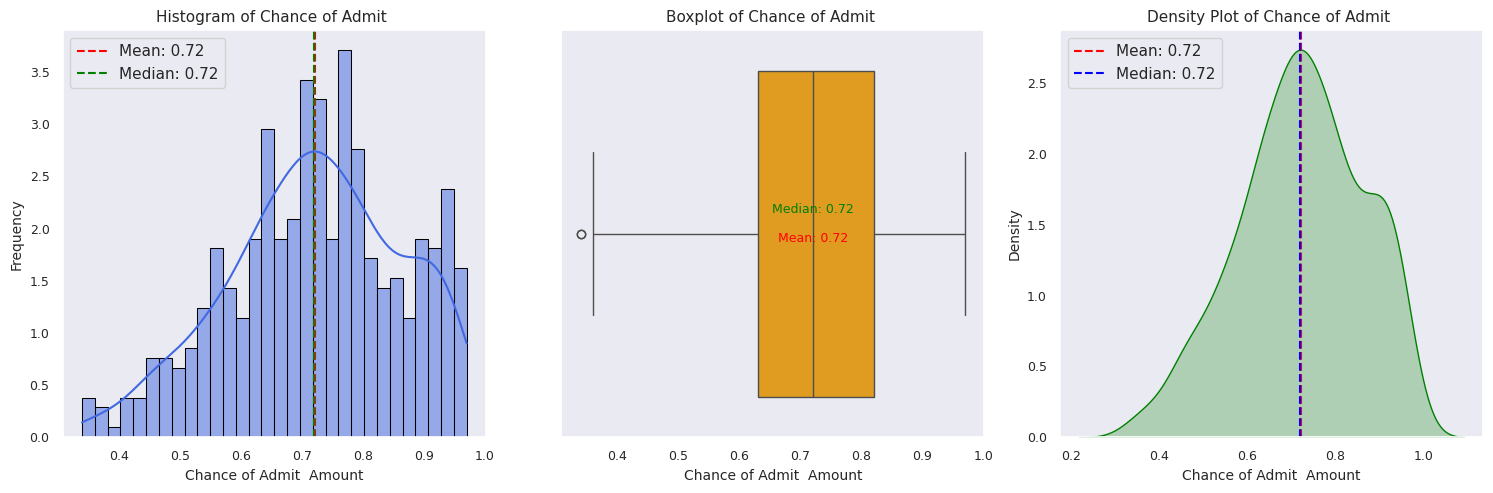

In [119]:
numerical_columns_distribution_with_stats(df, cols)

In [120]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

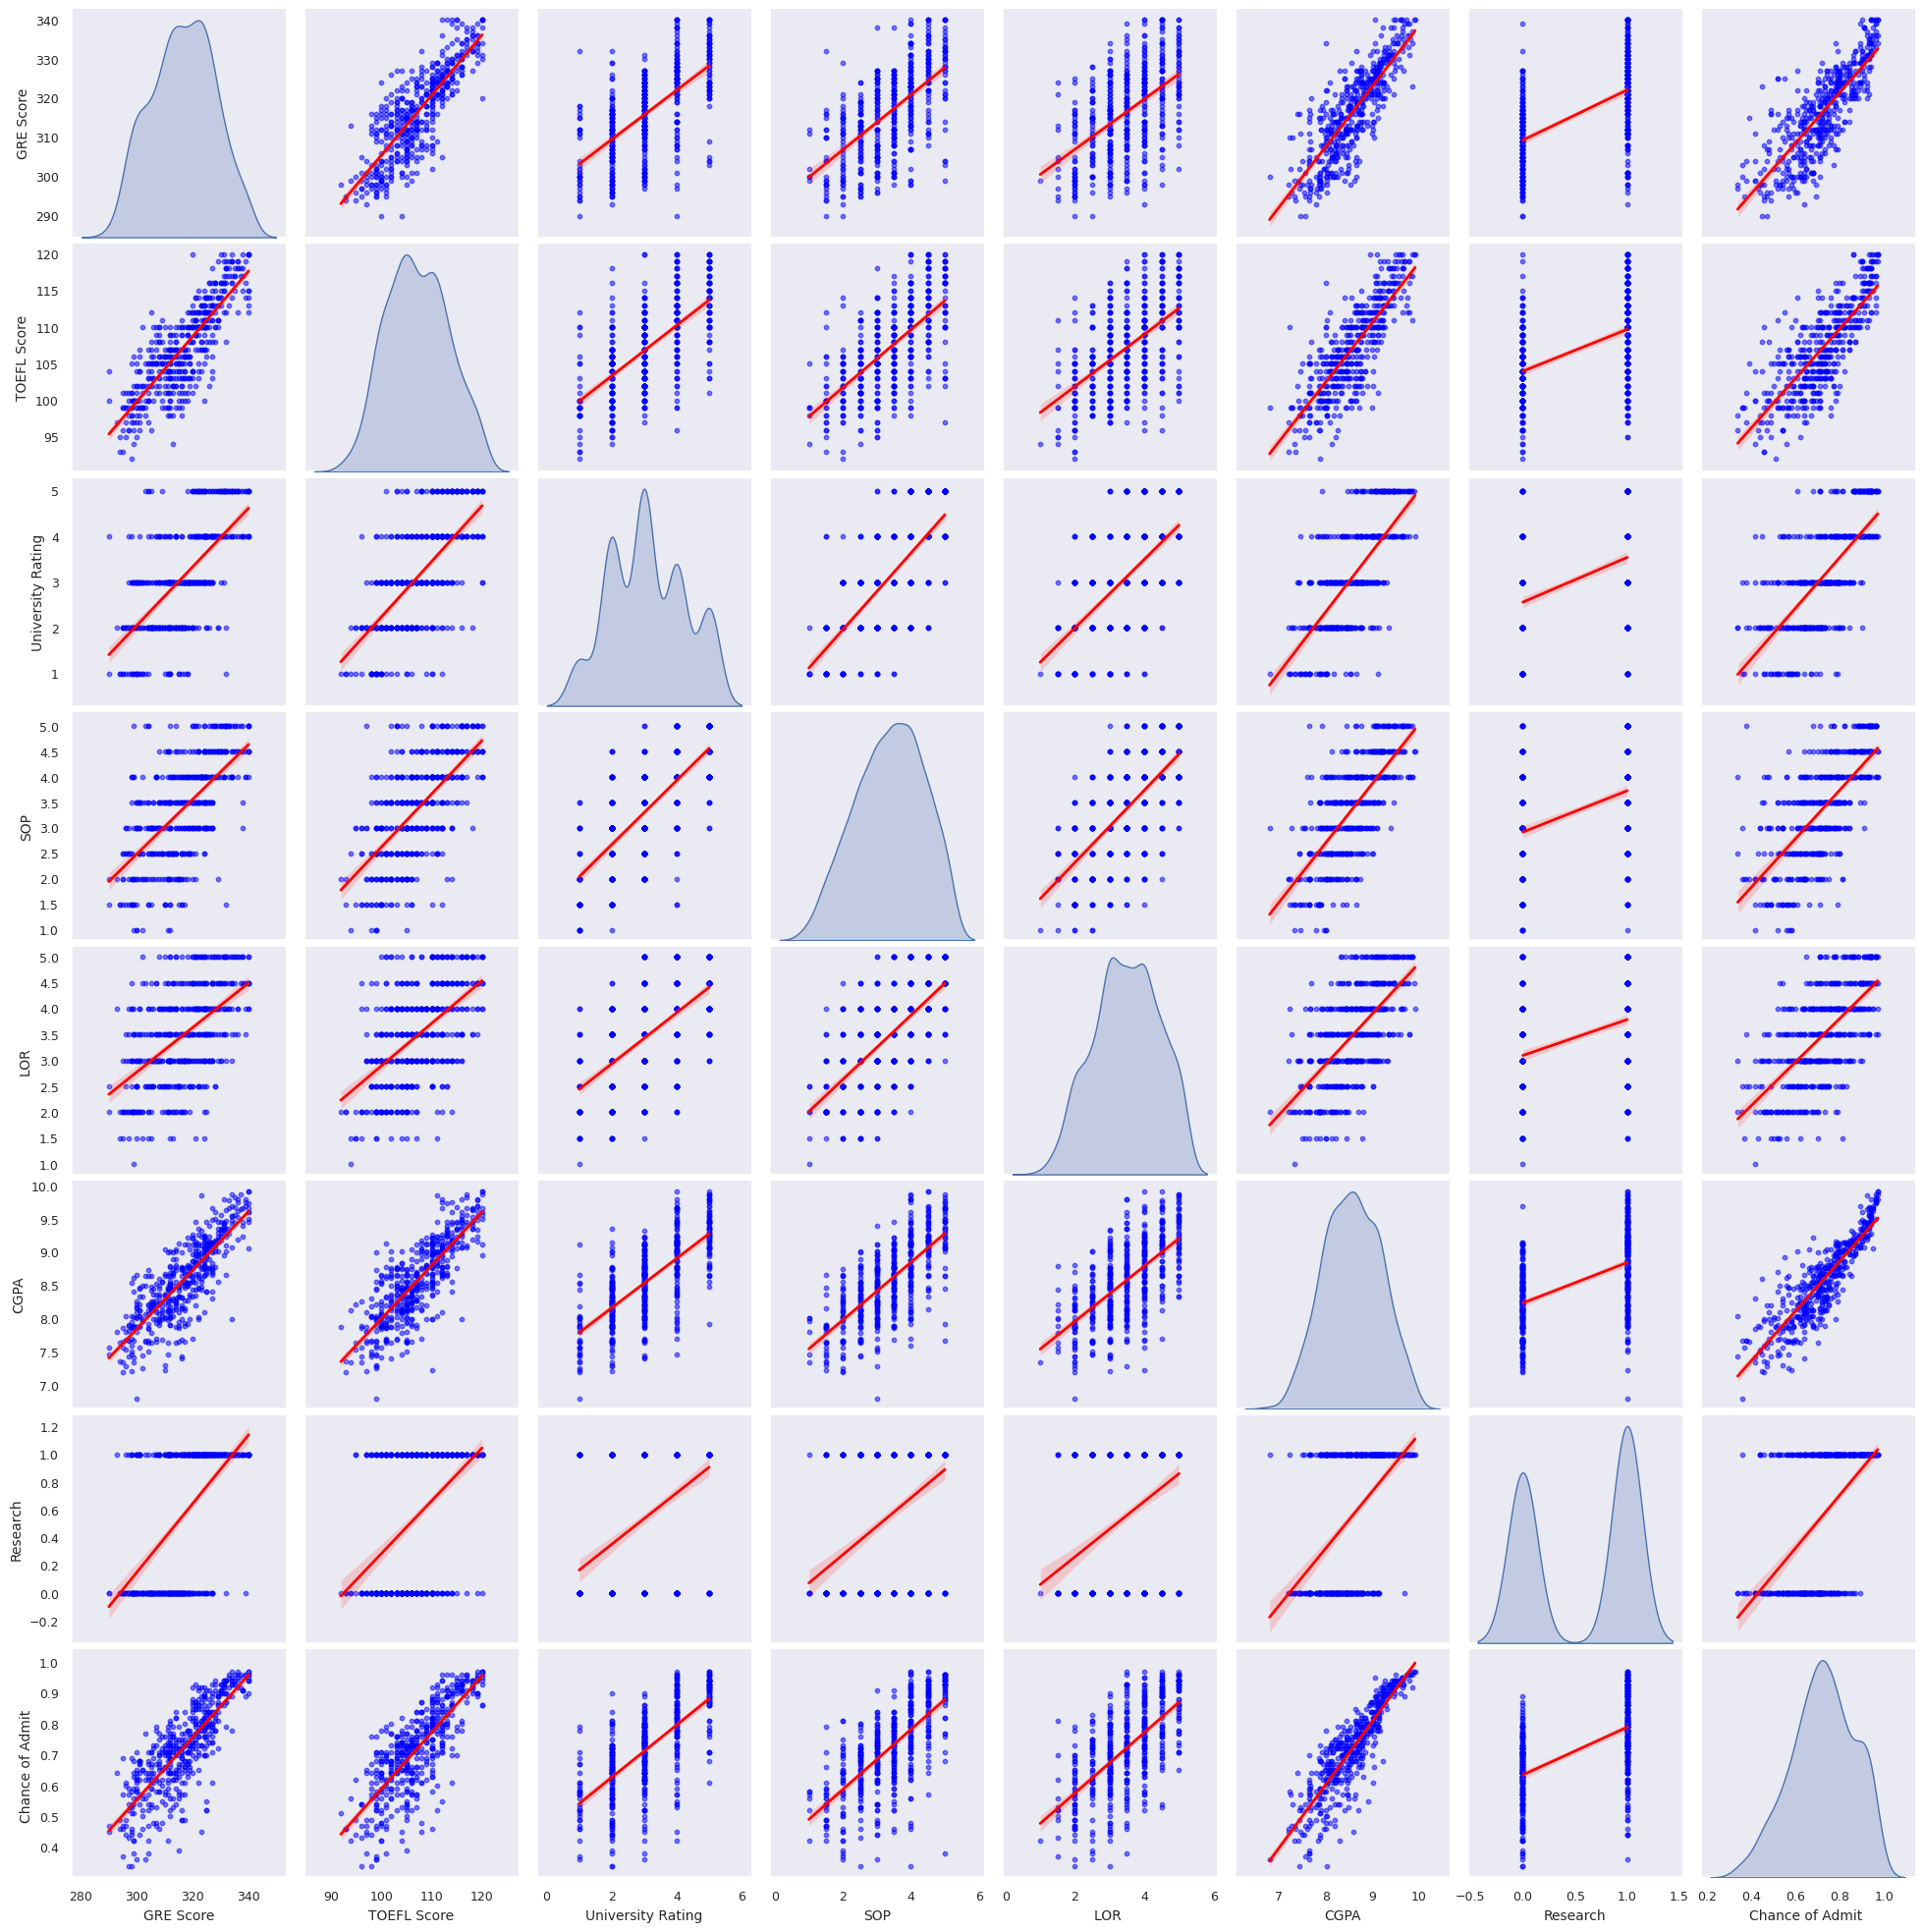

In [121]:
sns.pairplot(
    df,
    kind="reg",
    plot_kws={"scatter_kws": {"color": "blue", "alpha": 0.5, "s": 10},
              "line_kws": {"color": "red", "lw": 2}},
    diag_kind = 'kde'
)
plt.show()

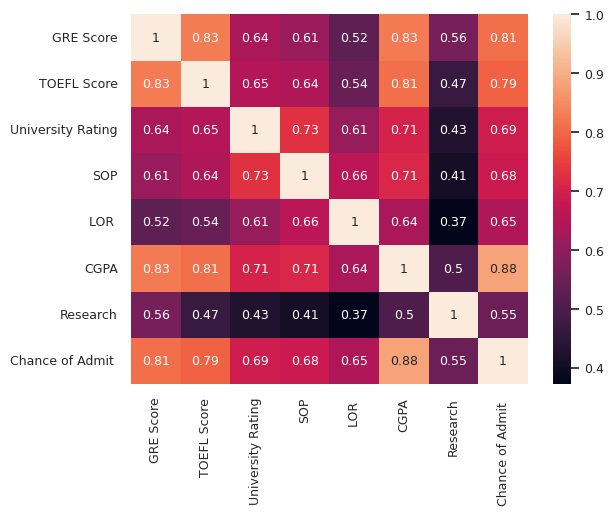

In [122]:
sns.heatmap(df.corr(), annot = True)
plt.show()

In between independent variables, some features have high correlation like 'GRE' and 'CGPA' and 'TOEFL'. but not very high(>90).

In [123]:
df.columns = ['GRE', 'TOEFL', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Chance of Admit']
df.columns

Index(['GRE', 'TOEFL', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research',
       'Chance of Admit'],
      dtype='object')

In [124]:
print(df['LOR'].value_counts())
print(df['SOP'].value_counts())
print(df['University Rating'].value_counts())
print(df['Research'].value_counts())

LOR
3.0    99
4.0    94
3.5    86
4.5    63
2.5    50
5.0    50
2.0    46
1.5    11
1.0     1
Name: count, dtype: int64
SOP
4.0    89
3.5    88
3.0    80
2.5    64
4.5    63
2.0    43
5.0    42
1.5    25
1.0     6
Name: count, dtype: int64
University Rating
3    162
2    126
4    105
5     73
1     34
Name: count, dtype: int64
Research
1    280
0    220
Name: count, dtype: int64


In [125]:
category_cols = ['LOR', 'SOP', 'University Rating', 'Research']
df[category_cols] = df[category_cols].astype('category')

num_cols = ['GRE', 'TOEFL', 'CGPA', 'Chance of Admit']

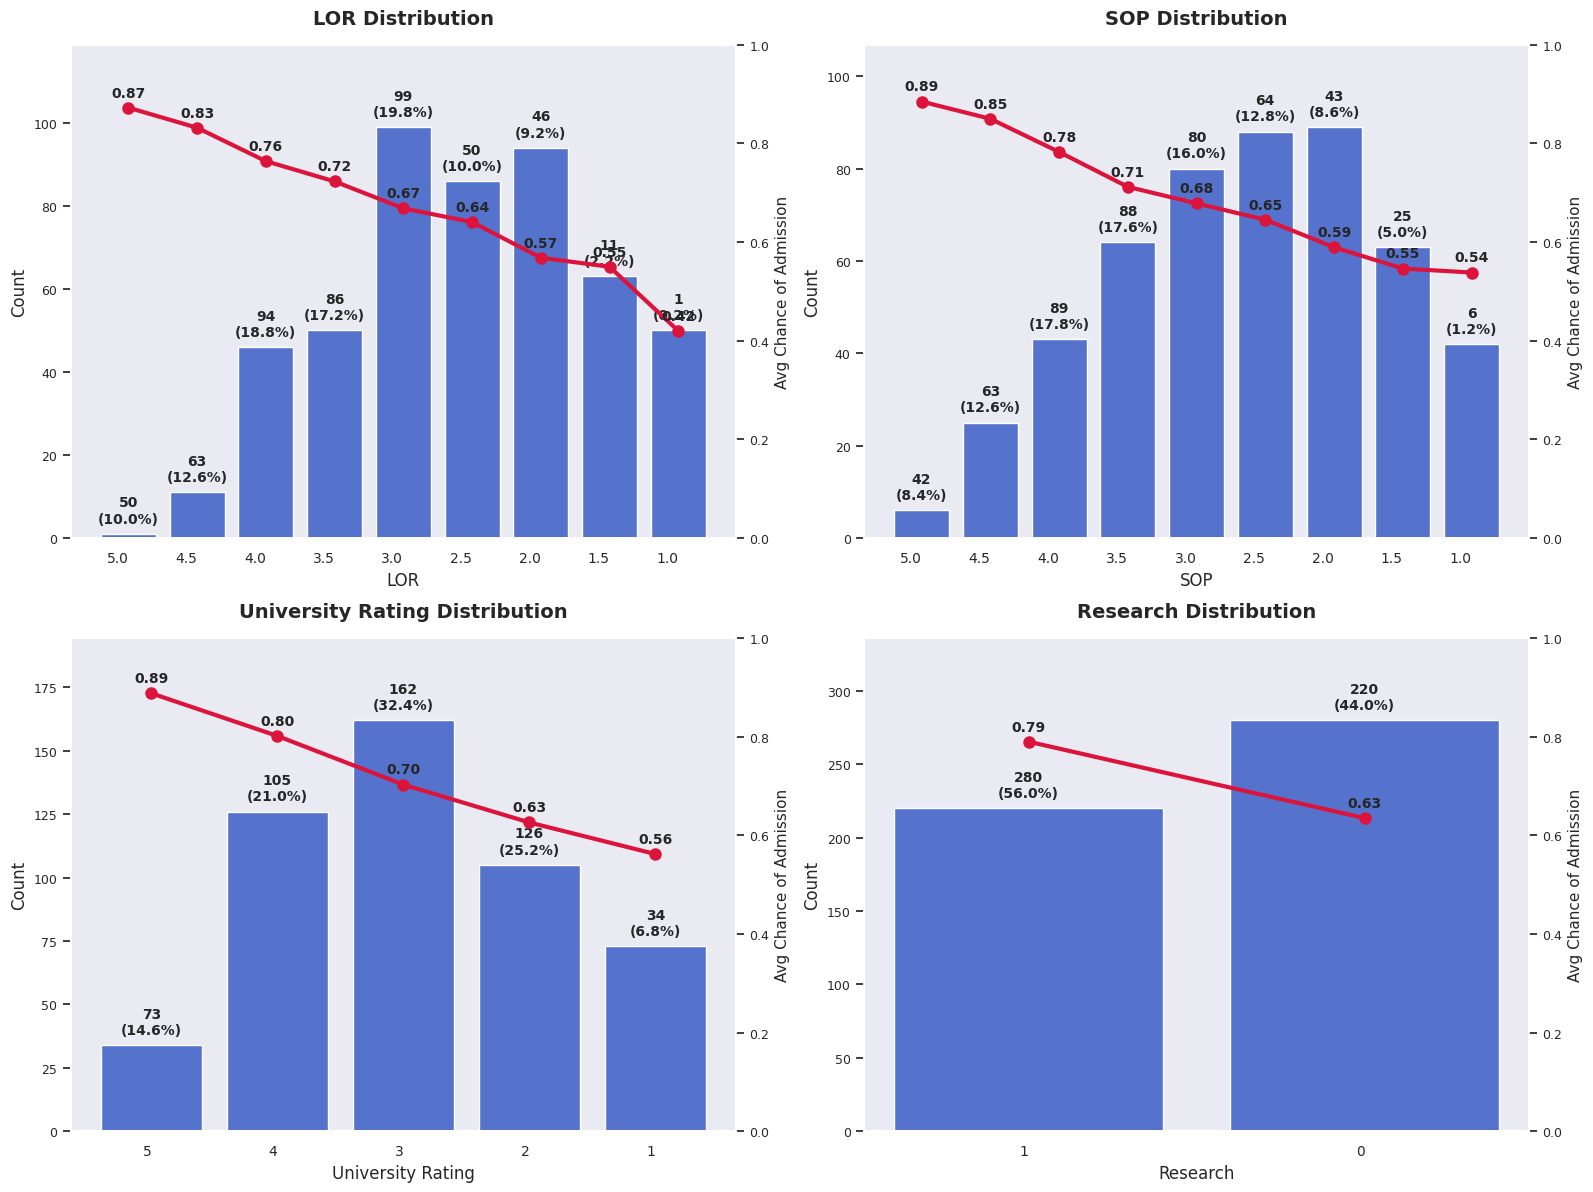

In [126]:
bar_plots(df, category_cols, secondary_col = 'Chance of Admit')

As you can see from the plots 'Chance of Admission' increases with increase in 'University Rating', 'LOR' and 'SOP'.
And students reserch experience have higher chace of admission.

# Data Preprocessing

In [127]:
df.duplicated().sum()

np.int64(0)

There is no duplicate values

In [128]:
df.isna().sum()

GRE                  0
TOEFL                0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

No missing values exist.

In [129]:
iqr_outliers_boxplot(df)


Column: GRE
Number of outliers (IQR method): 0

Column: TOEFL
Number of outliers (IQR method): 0

Column: CGPA
Number of outliers (IQR method): 0

Column: Chance of Admit
Number of outliers (IQR method): 2


Very less outliers.

##Encoding and Scaling

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GRE                500 non-null    int64   
 1   TOEFL              500 non-null    int64   
 2   University Rating  500 non-null    category
 3   SOP                500 non-null    category
 4   LOR                500 non-null    category
 5   CGPA               500 non-null    float64 
 6   Research           500 non-null    category
 7   Chance of Admit    500 non-null    float64 
dtypes: category(4), float64(2), int64(2)
memory usage: 18.8 KB


In [131]:
num_cols

['GRE', 'TOEFL', 'CGPA', 'Chance of Admit']

In [132]:
category_cols

['LOR', 'SOP', 'University Rating', 'Research']

Encoding:

- There is no string based categorical variable so no encoding will be done.
- `['LOR', 'SOP', 'University Rating']` : All these columns are Ordinal numeric category in range 1-5, having equal spacing between them, they have a order between them, so for this as this is a ordinal numeric we will do no encodeing but olny scale it with standard scaler i.e. `Ordinal numeric -> StandardScaler -> model`



Scaling:
- For numerical columns : `['GRE', 'TOEFL', 'CGPA']`, as these are marks of tests generally normally distributed, we will do a `StandardScaler()` on them.
-  `'Chance of Admit'` this column is the target column and in the range of 0-1, show chance of admission, needs no scaling as already scaled.
- `'Research'` will not be scaled as its only 0 and 1 works kind of lke OneHotEnoded(drop_first = True)

#Model Training

##Separating Features(X) and target(y)

In [133]:
X = df.drop(columns=["Chance of Admit"])
y = df["Chance of Admit"]

##train_test_split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 7), (100, 7), (400,), (100,))

##Scaling

In [135]:
scale_cols = [
    "GRE",
    "TOEFL",
    "University Rating",
    "SOP",
    "LOR",
    "CGPA"
]

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# fit on train
X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])

# only transform test using same parameters to avoid data leakage
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

# Add intercept for statsmodels
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Fit OLS on data
ols_model = sm.OLS(y_train, X_train_scaled).fit()

In [136]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     257.0
Date:                Tue, 20 Jan 2026   Prob (F-statistic):          3.41e-142
Time:                        07:48:44   Log-Likelihood:                 561.91
No. Observations:                 400   AIC:                            -1108.
Df Residuals:                     392   BIC:                            -1076.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7108      0.00

##Model interpretability

In [137]:
ols_model.params.drop('const').abs().sort_values(ascending = False)

CGPA                 0.067581
GRE                  0.026671
Research             0.024027
TOEFL                0.018226
LOR                  0.015866
University Rating    0.002940
SOP                  0.001788
dtype: float64

In [138]:
coef_df = (
    ols_model.params
    .drop("const")
    .abs()
    .sort_values(ascending=False)
    .reset_index()
)
coef_df.columns = ["Feature", "Abs_Coefficient"]
coef_df

Feature  Abs_Coefficient
0               CGPA         0.067581
1                GRE         0.026671
2           Research         0.024027
3              TOEFL         0.018226
4                LOR         0.015866
5  University Rating         0.002940
6                SOP         0.001788

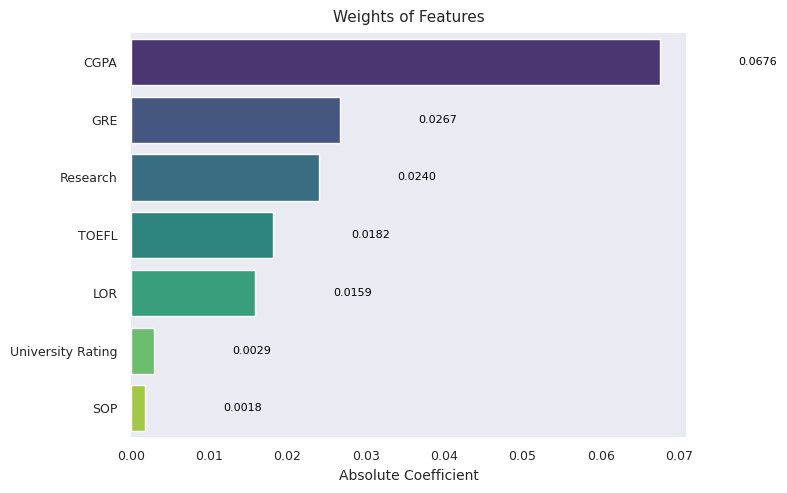

In [139]:
plot_model_weights(coef_df)

model importance order:
`CGPA > GRE > Research > TOEFL > LOR > University Ranking > SOP`

here `CGPA` is the most important Feature and `University Ranking` and `SOP` is Lowest importance.

In [140]:
ols_model.pvalues.drop('const').sort_values().map(lambda x: f"{x:.10f}")

CGPA                 0.0000000000
GRE                  0.0000335763
LOR                  0.0001947965
Research             0.0013375081
TOEFL                0.0016196581
University Rating    0.5414407502
SOP                  0.7211636150
dtype: object

We also have p-values of each features

`p < 0.05 -> statistically significant feature`

`p >= 0.05 -> not statistically significant feature`

Significant means:

`There is enough evidence to say this feature's effect is not zero.`

In [141]:
ols_model.pvalues.drop('const').sort_values() >= 0.05

CGPA                 False
GRE                  False
LOR                  False
Research             False
TOEFL                False
University Rating     True
SOP                   True
dtype: bool

Only `University Rating` and `SOP` have p-value greater that 0.05, that means these two features are not statistically significant, so we will drop them and re-train the model

In [142]:
X_train_scaled.drop(columns = ['University Rating', 'SOP'], inplace = True)
X_test_scaled.drop(columns = ['University Rating', 'SOP'], inplace = True)

In [143]:
ols_model = sm.OLS(y_train, X_train_scaled).fit()

In [144]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance of Admit   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     360.8
Date:                Tue, 20 Jan 2026   Prob (F-statistic):          1.36e-144
Time:                        07:48:45   Log-Likelihood:                 561.54
No. Observations:                 400   AIC:                            -1111.
Df Residuals:                     394   BIC:                            -1087.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7105      0.005    139.896      0.0

After removing `University Rating` and `SOP` and retraing the model, the r2_score and Adj. r2 score remain unchanged.
That mean those features have zero or very minimal effect in prediction.

In [145]:
coef_df = (
    ols_model.params
    .drop("const")
    .abs()
    .sort_values(ascending=False)
    .reset_index()
)
coef_df.columns = ["Feature", "Abs_Coefficient"]
coef_df

Feature  Abs_Coefficient
0      CGPA         0.069066
1       GRE         0.026879
2  Research         0.024601
3     TOEFL         0.019106
4       LOR         0.017207

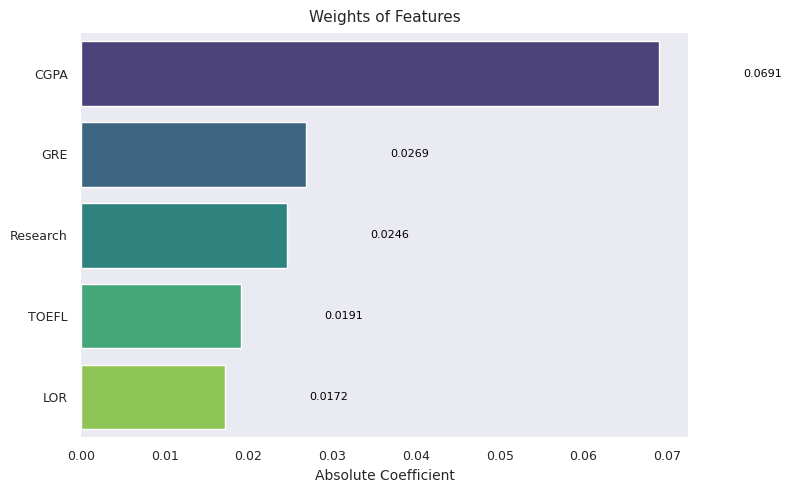

In [146]:
plot_model_weights(coef_df)

# Testing Assumptions of Linear Regression



1.   `Assumption of Linearity` : `X(Features)` should have linear relationship with `y(target)`

2.   `No Multi-Colinearity` : `Features(X)` are not Multi-colinear i.e. independent feature should not be dependent on each other

3.   `Residuals/Error should be Normally Distributed`
4.   `No Heteroskedasticity i.e. Homoskedasticity`: when plotting residual/error vs y_hat/y_predicted scatter plot the spread of the errors is roughly constant across all levels of prediction.
5.   `No Auto-correlation`






## 1. `Assumption of Linearity`

- Fit the model
- Compute predictions (y_pred) using X_train_scaled
- Compute residuals (y - y_pred) (in case of linearity check raw residuals is used)
- Plot residuals against:
    - fitted values (y_pred)
    - each predictor or Features

In [147]:
y_pred = ols_model.predict(X_train_scaled)
resid = y_train - y_pred

In [148]:
resid.mean()

np.float64(-2.1899149160731212e-16)

Here Mean of residuals is close to zero.If the mean of residuals is close to zero, it indicates that the model on an average not doing too much error. However, if the mean of residuals is very different from zero, it tells that the model is overestimating or underestimating the observed values.

###Residuals vs y_pred

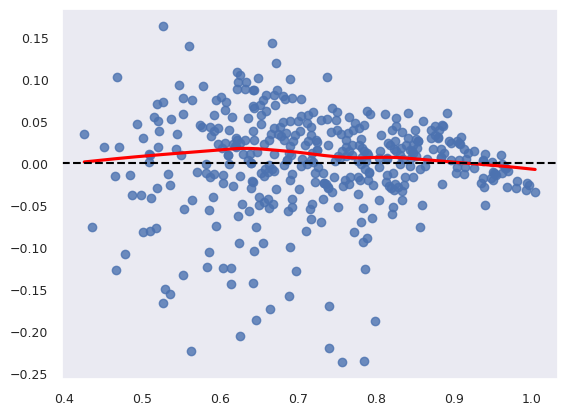

In [149]:
sns.regplot(
    x=y_pred,
    y=resid,
    lowess=True,
    line_kws={"color": "red"}
)
plt.axhline(0, color="black", linestyle="--")
plt.show()


- The red Lowess line is very close to the dashed black line (zero) for the vast majority of the data. The points appear to be a random "cloud" without "U" or "S" curve. This suggests that a linear model is a very good fit for the data.
- There is a very slight "hump" between 0.55 and 0.8 on the x-axis, and a small dip at the very beginning (between 0.4 and 0.5). This is very negligible.
- So, we can safely conclude that the linearity assumption is satisfied.


###Residuals vs Features(Predictors)

In [150]:
X_train_scaled.columns

Index(['const', 'GRE', 'TOEFL', 'LOR', 'CGPA', 'Research'], dtype='object')

In [151]:
X_train_scaled[['LOR','Research']] = X_train_scaled[['LOR','Research']].astype('int')

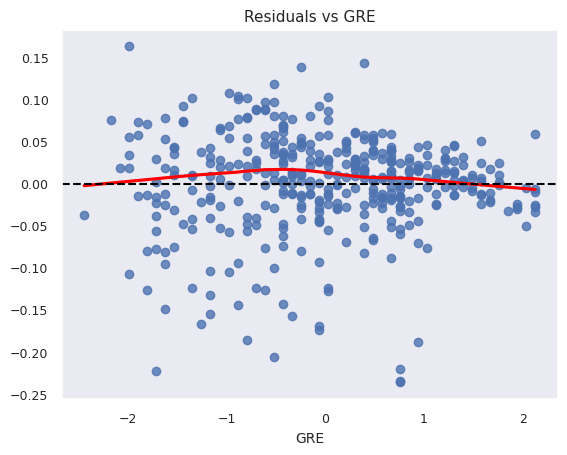

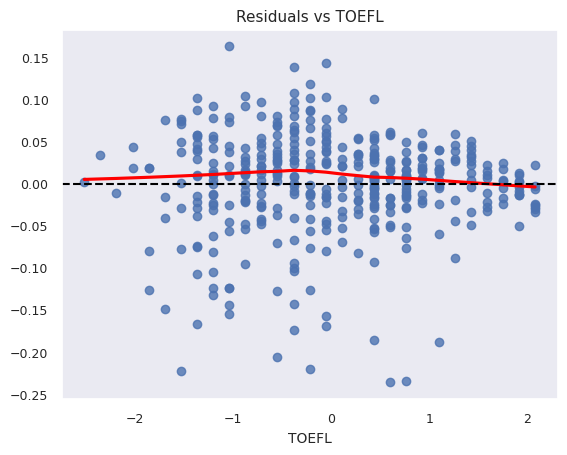

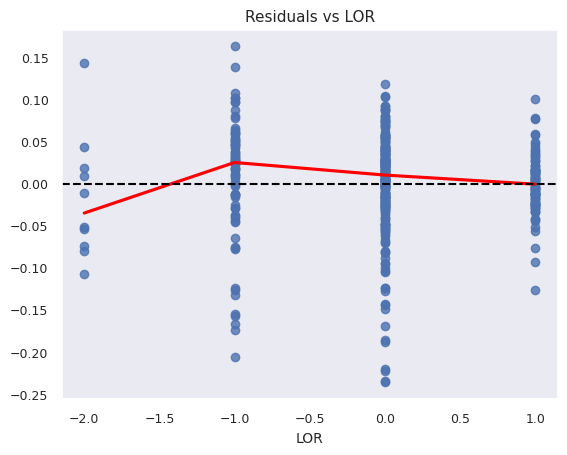

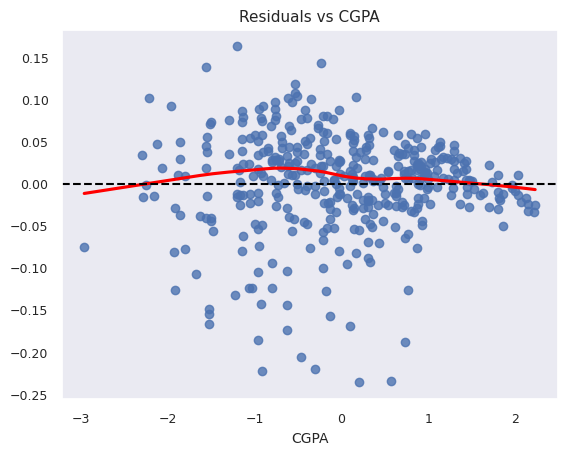

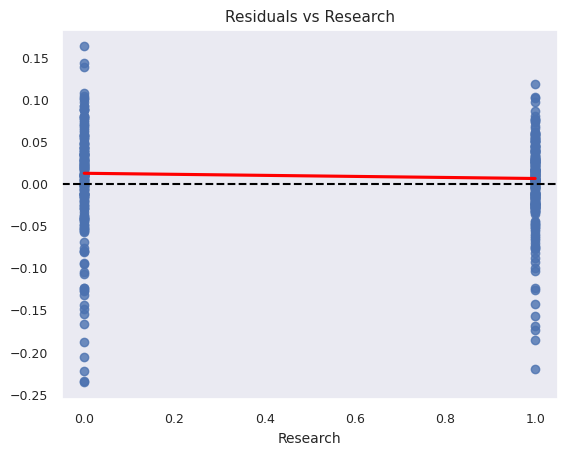

In [152]:
for col in X_train_scaled.columns:
    if col != "const":
        sns.regplot(
            x=X_train_scaled[col],
            y=resid,
            lowess=True,
            line_kws={"color": "red"}
        )
        plt.axhline(0, color="black", linestyle="--")
        plt.title(f"Residuals vs {col}")
        plt.show()


- The lowess red line is mostly close to x-axis(dashed black line) with some variation like residual vs y_pred and is mostly not too much, so we can safely assume Linearity assumption holds.

- In residual vs y_pred plot the scattered points look like a Fan shape from left hand side, seem the variance of spread of residual across zero is not equal possibly a case of Heterskedasticity to check for.

Funnel, Fan, Cone-shaped pattern: The spread of residuals widens or narrows as the predicted values or independent variables change, suggesting heteroscedasticity.

##2. `No Multi-Colinearity` check

In [153]:
vif = pd.DataFrame()
X_t = pd.DataFrame(X_train_scaled, columns=X_train_scaled.columns)
vif['Features'] = X_t.columns
vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
1       GRE  4.48
4      CGPA  4.11
2     TOEFL  3.55
0     const  2.88
5  Research  1.51
3       LOR  1.50

**VIF Value,Interpretation,Action**

- `VIF = 1`,No correlation with other predictors.,Ideal; no action needed.
- `1 < VIF < 5`,Moderate correlation.,Generally acceptable; no action needed.
- `VIF > 5`,Potentially problematic.,Investigate; variables might be redundant.
- `VIF > 10`,Severe multicollinearity.,High priority for correction; coefficients are likely unreliable.
- `VIF = inf`, Perfect multicollinearity, drop the one feature with vif = inf

In our case all vif values of predictors are below 5, that means moderate correlation. No action needed.

So `No Multicollinearity` assumption is not violated.

##3. `Residuals/Errors should be Normally Distributed`

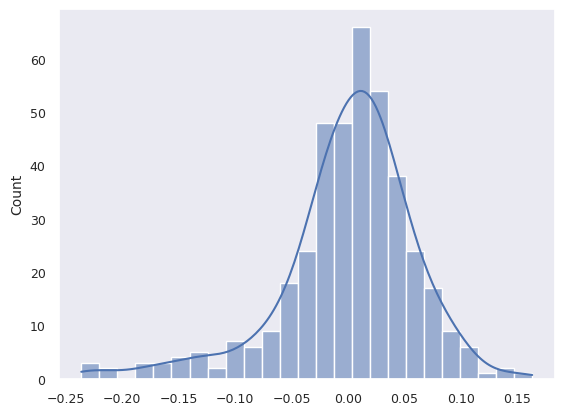

In [154]:
sns.histplot(resid, kde=True)
plt.show()

From the histogram, our residual is left skewed.

Let's do a shapiro-wilks normality checks


- `p > 0.05`,Fail to Reject Ho, Your residuals are normal. The assumption is met!
- `p <= 0.05`,Reject Ho, Your residuals are not normal. The assumption is violated.

In [155]:
st, p = shapiro(resid)

In [156]:
p<=0.05

np.True_

As p<=0.05, we Reject Ho, Your residuals are not normal. The assumption is violated.

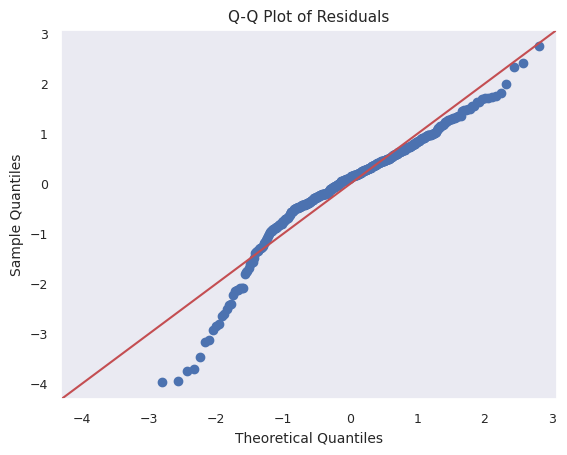

In [157]:
# 'line=45' plots the reference line for normality
sm.qqplot(resid, line='45', fit=True)

plt.title("Q-Q Plot of Residuals")
plt.show()

- From Histplot, shapiro-test and qq plot its clear that the residual are not following normal distribution. It violate the assumptions of Linear Regression.
- But even if it violates, the predictions will work fine.
- The Normal distribution assumtion is mainly for statstitical point of view not for predictions.

##4. `No Heteroskedasticity or Homoskedasticity`

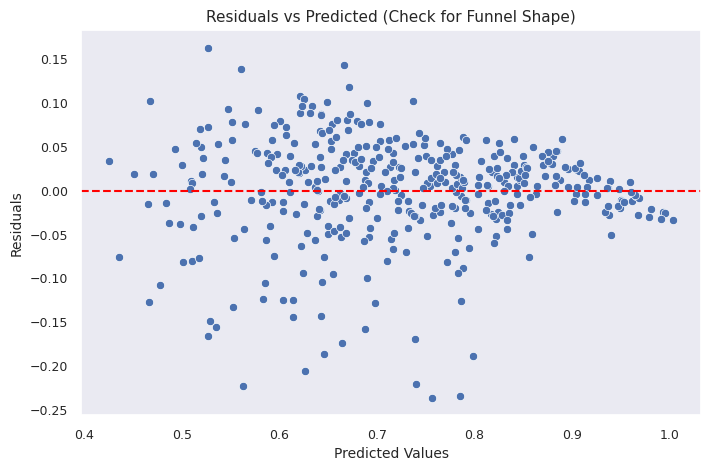

In [158]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=resid)
plt.axhline(0, color='red', linestyle='--') # The reference line
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Check for Funnel Shape)')
plt.show()

As it is visible that from the left side the scattered point creating a fan like structure i.e. the spread of errors around the zero line(black dashed line) is not same. But plot might be deciving when less point, better check it with a Hypothesis test.

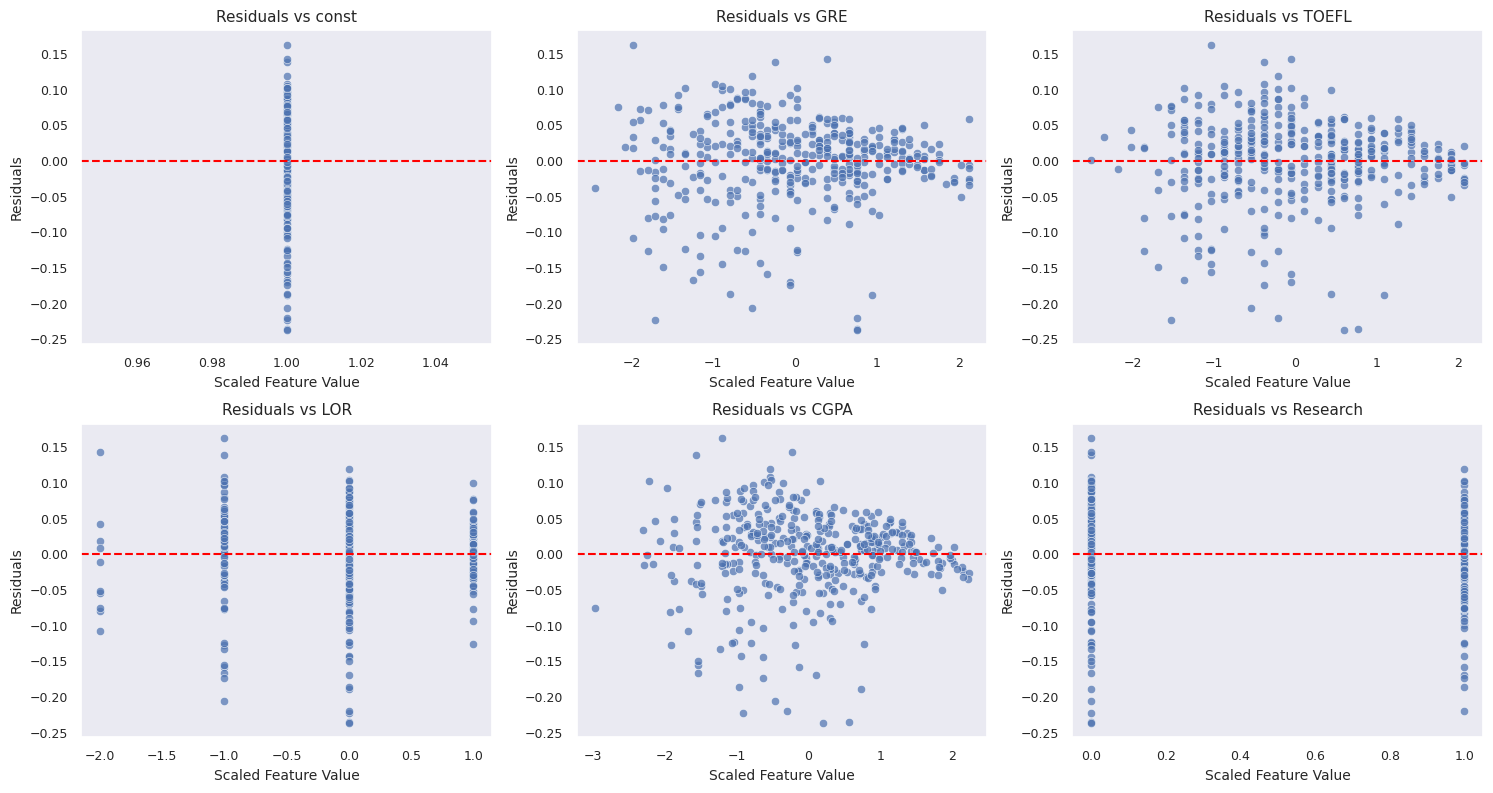

In [159]:

num_features = X_train_scaled.shape[1]
cols = 3  # Number of plots per row
rows = (num_features // cols) + (num_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for i, col_name in enumerate(X_train_scaled.columns):
    sns.scatterplot(x=X_train_scaled[col_name], y=resid, ax=axes[i], alpha=0.7)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f'Residuals vs {col_name}')
    axes[i].set_xlabel('Scaled Feature Value')
    axes[i].set_ylabel('Residuals')

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

We can do a `Goldfeld Quandt test` for to check Homoskedasticity

- Null Hypothesis ($H_0$): Homoscedasticity is present. (The variance of the residuals is constant across the data).

- Alternative Hypothesis ($H_a$): Heteroscedasticity is present. (The variance of the residuals is not constant; it specifically increases or decreases as the value of a predictor increases).

$p > 0.05$: Fail to reject $H_0$. Your variance is stable (Homoscedastic).

$p \leq 0.05$: Reject $H_0$. You have significant Heteroscedasticity.

In [160]:
name = ['F-statistic', 'p-value']
test = sms.het_goldfeldquandt(y_train, X_train_scaled)
lzip(name, test)

[('F-statistic', np.float64(0.9439092216825083)),
 ('p-value', np.float64(0.6559609202825019))]

as here p-value > 0.05, i.e. Fail to reject Ho, So Homoskedasticity i.e. `No Heteroskedasticity` assumption holds

##5. `No Auto-correlation`

Though auto-correlation mostly happen when therr is time series data, here it won't be there. Still if wants to check can be checked as shown below.

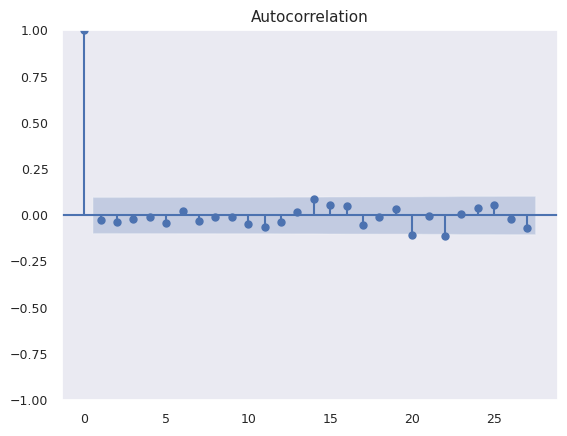

In [161]:
plot_acf(resid)
plt.show()

- Bars stay inside shaded area : No Auto-correlation
- Bars cross the blue threshold : Autocorrelation exists

As bars stay inside blue region so, no auto-correlation

Also we can confirm this using `Durbin-Watson test`

- Ho : No Autocorrelation

- Ha : Autocorrelation exists

In [162]:
# Assuming 'residuals' is your array of model errors (y_actual - y_pred)
dw_statistic = durbin_watson(resid)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Simple interpretation logic
if dw_statistic < 1.5:
    print("Signs of positive autocorrelation.")
elif dw_statistic > 2.5:
    print("Signs of negative autocorrelation.")
else:
    print("No significant autocorrelation detected.")

Durbin-Watson statistic: 2.0534
No significant autocorrelation detected.


Another modern test for autocorrelation is `Breusch-Godfrey test`<br>
but instead of taking the residuals it take the model(built by ols of statsmodel) itself

- Ho : No Autocorrelation
- Ha : Autocorrelation

In [163]:
lm_stat, lm_pvalue, f_stat, f_pvalue = acorr_breusch_godfrey(ols_model, nlags = 1)

lm_pvalue

np.float64(0.5799615629925241)

as p>0.05 : Fail to reject Ho i.e. no autocorrelation

# Model Building using Scikit-Learn

In [164]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 249 to 102
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   GRE                400 non-null    int64   
 1   TOEFL              400 non-null    int64   
 2   University Rating  400 non-null    category
 3   SOP                400 non-null    category
 4   LOR                400 non-null    category
 5   CGPA               400 non-null    float64 
 6   Research           400 non-null    category
dtypes: category(4), float64(1), int64(2)
memory usage: 15.1 KB


In [165]:
num_cols = [
    "GRE",
    "TOEFL",
    "University Rating",
    "SOP",
    "LOR",
    "CGPA"
]

bin_cols = ["Research"]

In [166]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("bin", "passthrough", bin_cols)
    ]
)

lr_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression())
    ]
)

In [167]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GRE', 'TOEFL',
                                                   'University Rating', 'SOP',
                                                   'LOR', 'CGPA']),
                                                 ('bin', 'passthrough',
                                                  ['Research'])])),
                ('regressor', LinearRegression())])

In [168]:
def scores(X, y, y_pred, type = ''):
    """
    Calculates and prints R-squared, Adjusted R-squared, RMSE, MSE, and MAE for a regression model.

    Parameters:
    - X (pd.DataFrame): The feature DataFrame used for prediction (to calculate Adjusted R-squared).
    - y (pd.Series): The true target values.
    - y_pred (np.array or pd.Series): The predicted target values.
    - type (str, optional): A string prefix for the output messages (e.g., 'Test', 'Train'). Defaults to ''.
    """
    r2 = r2_score(y, y_pred)

    m = X.shape[0]
    k = X.shape[1]
    Adj_r2 = 1 - (1 - r2)*((m - 1)/(m - k - 1))

    rmse = root_mean_squared_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    print(type, f"R²   : {r2:.4f}")
    print(type, f"Adj.R² : {Adj_r2:.4f}")
    print(type, f"RMSE: {rmse:.4f}")
    print(type, f"MSE : {mse:.4f}")
    print(type, f"MAE : {mae:.4f}")

In [169]:
y_pred = lr_model.predict(X_test)

In [170]:
y_pred_train = lr_model.predict(X_train)

In [171]:
scores(X_test, y_test, y_pred, type = 'Test')

Test R²   : 0.8188
Test Adj.R² : 0.8051
Test RMSE: 0.0609
Test MSE : 0.0037
Test MAE : 0.0427


In [172]:
scores(X_train, y_train, y_pred_train, type = 'Train')

Train R²   : 0.8211
Train Adj.R² : 0.8179
Train RMSE: 0.0594
Train MSE : 0.0035
Train MAE : 0.0425


## Feature Importance

In [173]:
def model_weights(model):
    """
    Extracts and organizes the absolute coefficients (weights) of features from a scikit-learn pipeline.

    Parameters:
    - model (sklearn.pipeline.Pipeline): A scikit-learn pipeline containing a 'preprocess' step (ColumnTransformer) and a 'regressor' step (LinearRegression-like model).

    Returns:
    - pd.DataFrame: A DataFrame with 'Feature' names and their 'Abs_Coefficient', sorted in descending order of absolute coefficient.
    """
    feature_names = (
        model.named_steps["preprocess"]
        .get_feature_names_out()
    )

    coefficients = model.named_steps["regressor"].coef_

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Abs_Coefficient": coefficients
    })


    coef_df['Abs_Coefficient'] = np.abs(coef_df['Abs_Coefficient'])
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

    return coef_df

In [174]:
model_weights(lr_model)

Feature  Abs_Coefficient
5               num__CGPA         0.067581
0                num__GRE         0.026671
6           bin__Research         0.024027
1              num__TOEFL         0.018226
4                num__LOR         0.015866
2  num__University Rating         0.002940
3                num__SOP         0.001788

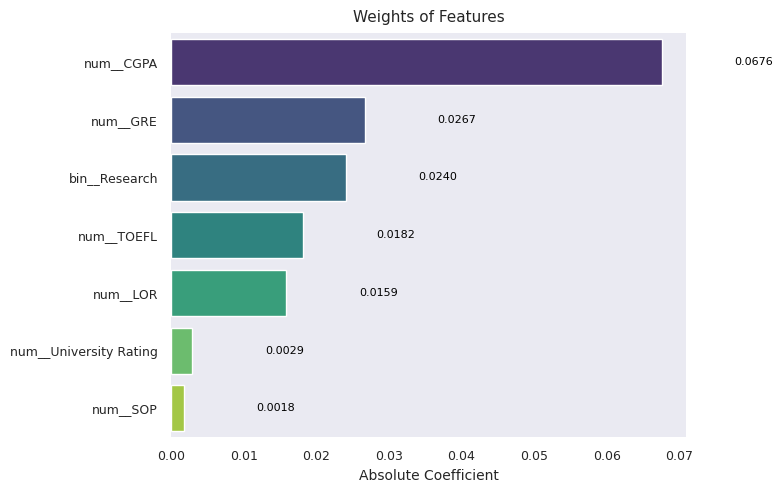

In [175]:
plot_model_weights(model_weights(lr_model))

#Using Lasso, Ridge and ElasticNet

In [176]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 7), (400,), (100, 7), (100,))

##Lasso()

For alpha =  100
---------------


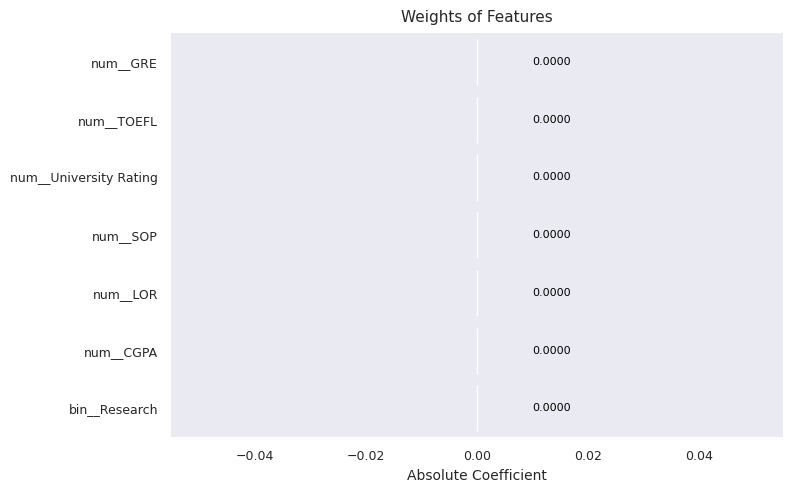

---------------
Lasso(alpha = 100) Test R²   : -0.0072
Lasso(alpha = 100) Test Adj.R² : -0.0839
Lasso(alpha = 100) Test RMSE: 0.1435
Lasso(alpha = 100) Test MSE : 0.0206
Lasso(alpha = 100) Test MAE : 0.1163
---------------
Lasso(alpha = 100) Train R²   : 0.0000
Lasso(alpha = 100) Train Adj.R² : -0.0179
Lasso(alpha = 100) Train RMSE: 0.1404
Lasso(alpha = 100) Train MSE : 0.0197
Lasso(alpha = 100) Train MAE : 0.1133

For alpha =  10
---------------


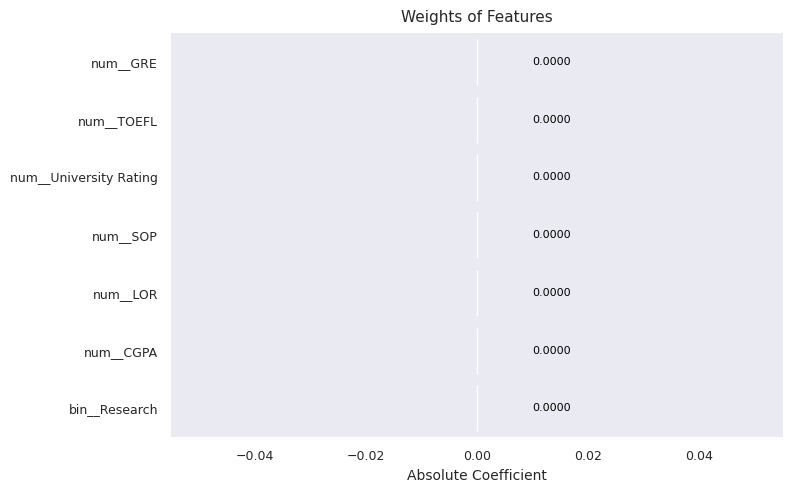

---------------
Lasso(alpha = 10) Test R²   : -0.0072
Lasso(alpha = 10) Test Adj.R² : -0.0839
Lasso(alpha = 10) Test RMSE: 0.1435
Lasso(alpha = 10) Test MSE : 0.0206
Lasso(alpha = 10) Test MAE : 0.1163
---------------
Lasso(alpha = 10) Train R²   : 0.0000
Lasso(alpha = 10) Train Adj.R² : -0.0179
Lasso(alpha = 10) Train RMSE: 0.1404
Lasso(alpha = 10) Train MSE : 0.0197
Lasso(alpha = 10) Train MAE : 0.1133

For alpha =  0.1
---------------


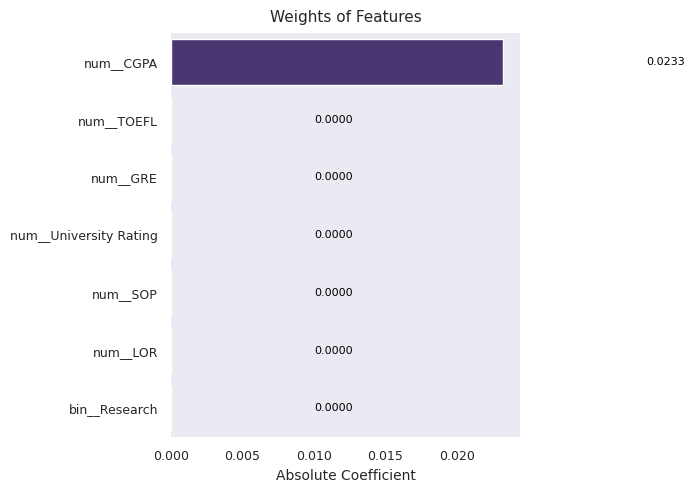

---------------
Lasso(alpha = 0.1) Test R²   : 0.2670
Lasso(alpha = 0.1) Test Adj.R² : 0.2113
Lasso(alpha = 0.1) Test RMSE: 0.1224
Lasso(alpha = 0.1) Test MSE : 0.0150
Lasso(alpha = 0.1) Test MAE : 0.0981
---------------
Lasso(alpha = 0.1) Train R²   : 0.2637
Lasso(alpha = 0.1) Train Adj.R² : 0.2505
Lasso(alpha = 0.1) Train RMSE: 0.1205
Lasso(alpha = 0.1) Train MSE : 0.0145
Lasso(alpha = 0.1) Train MAE : 0.0972

For alpha =  0.01
---------------


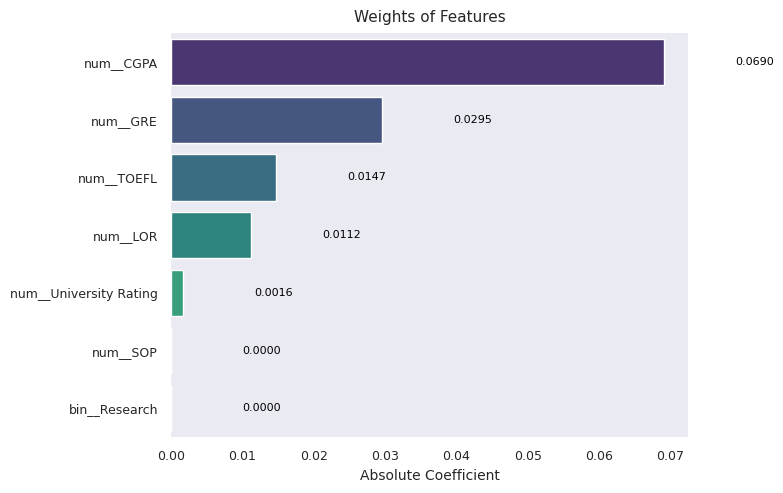

---------------
Lasso(alpha = 0.01) Test R²   : 0.8098
Lasso(alpha = 0.01) Test Adj.R² : 0.7953
Lasso(alpha = 0.01) Test RMSE: 0.0624
Lasso(alpha = 0.01) Test MSE : 0.0039
Lasso(alpha = 0.01) Test MAE : 0.0433
---------------
Lasso(alpha = 0.01) Train R²   : 0.8090
Lasso(alpha = 0.01) Train Adj.R² : 0.8056
Lasso(alpha = 0.01) Train RMSE: 0.0613
Lasso(alpha = 0.01) Train MSE : 0.0038
Lasso(alpha = 0.01) Train MAE : 0.0441

For alpha =  0.001
---------------


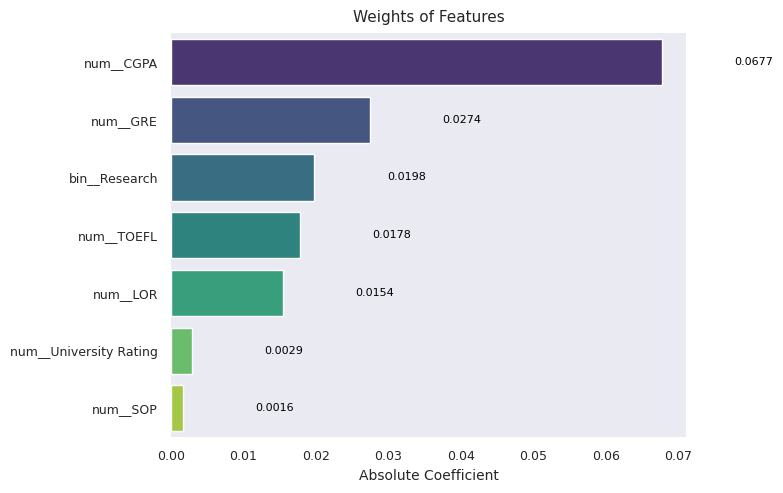

---------------
Lasso(alpha = 0.001) Test R²   : 0.8189
Lasso(alpha = 0.001) Test Adj.R² : 0.8051
Lasso(alpha = 0.001) Test RMSE: 0.0609
Lasso(alpha = 0.001) Test MSE : 0.0037
Lasso(alpha = 0.001) Test MAE : 0.0425
---------------
Lasso(alpha = 0.001) Train R²   : 0.8208
Lasso(alpha = 0.001) Train Adj.R² : 0.8176
Lasso(alpha = 0.001) Train RMSE: 0.0594
Lasso(alpha = 0.001) Train MSE : 0.0035
Lasso(alpha = 0.001) Train MAE : 0.0425

For alpha =  0.0001
---------------


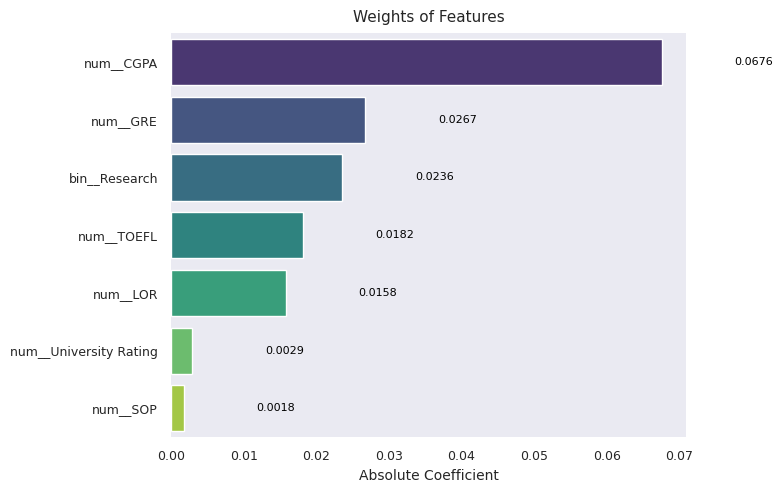

---------------
Lasso(alpha = 0.0001) Test R²   : 0.8189
Lasso(alpha = 0.0001) Test Adj.R² : 0.8051
Lasso(alpha = 0.0001) Test RMSE: 0.0609
Lasso(alpha = 0.0001) Test MSE : 0.0037
Lasso(alpha = 0.0001) Test MAE : 0.0427
---------------
Lasso(alpha = 0.0001) Train R²   : 0.8211
Lasso(alpha = 0.0001) Train Adj.R² : 0.8179
Lasso(alpha = 0.0001) Train RMSE: 0.0594
Lasso(alpha = 0.0001) Train MSE : 0.0035
Lasso(alpha = 0.0001) Train MAE : 0.0425

For alpha =  0.0006
---------------


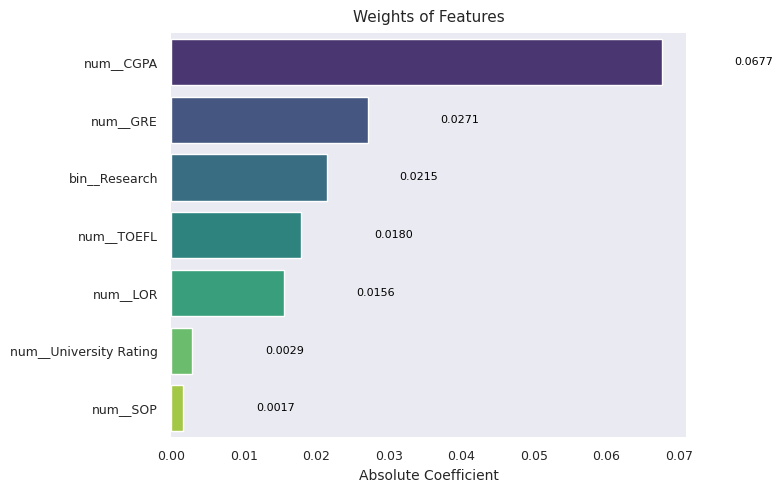

---------------
Lasso(alpha = 0.0006) Test R²   : 0.8189
Lasso(alpha = 0.0006) Test Adj.R² : 0.8052
Lasso(alpha = 0.0006) Test RMSE: 0.0608
Lasso(alpha = 0.0006) Test MSE : 0.0037
Lasso(alpha = 0.0006) Test MAE : 0.0426
---------------
Lasso(alpha = 0.0006) Train R²   : 0.8210
Lasso(alpha = 0.0006) Train Adj.R² : 0.8178
Lasso(alpha = 0.0006) Train RMSE: 0.0594
Lasso(alpha = 0.0006) Train MSE : 0.0035
Lasso(alpha = 0.0006) Train MAE : 0.0425



In [177]:
alphas = [100, 10, 0.1, 0.01, 0.001, 0.0001, 0.0006]
for i in alphas:
    print('For alpha = ', i)
    print('='*15)
    lasso_model = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("regressor", Lasso(alpha = i))
        ]
    )
    lasso_model.fit(X_train, y_train)
    print('-'*15)
    plot_model_weights(model_weights(lasso_model))
    print('-'*15)
    y_pred = lasso_model.predict(X_test)
    y_pred_train = lasso_model.predict(X_train)
    type = 'Lasso(alpha = '+str(i)+')'
    scores(X_test, y_test, y_pred, type = type +' Test')
    print('-'*15)
    scores(X_train, y_train, y_pred_train, type = type+' Train')
    print('='*15)
    print()


##Ridge()

For alpha =  10000
---------------


/tmp/ipython-input-1896947573.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


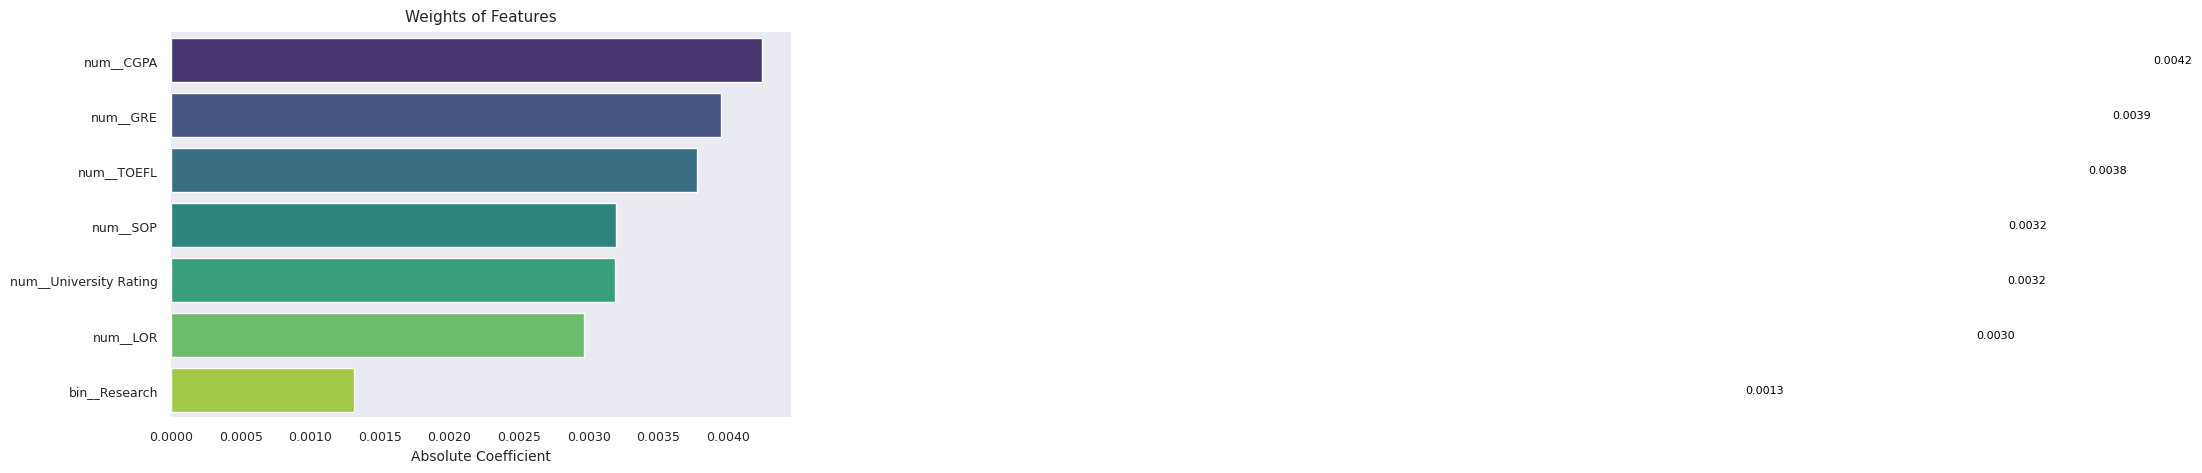

---------------
Ridge(alpha = 10000) Test R²   : 0.2209
Ridge(alpha = 10000) Test Adj.R² : 0.1616
Ridge(alpha = 10000) Test RMSE: 0.1262
Ridge(alpha = 10000) Test MSE : 0.0159
Ridge(alpha = 10000) Test MAE : 0.1006
---------------
Ridge(alpha = 10000) Train R²   : 0.2175
Ridge(alpha = 10000) Train Adj.R² : 0.2036
Ridge(alpha = 10000) Train RMSE: 0.1242
Ridge(alpha = 10000) Train MSE : 0.0154
Ridge(alpha = 10000) Train MAE : 0.0998

For alpha =  1000
---------------


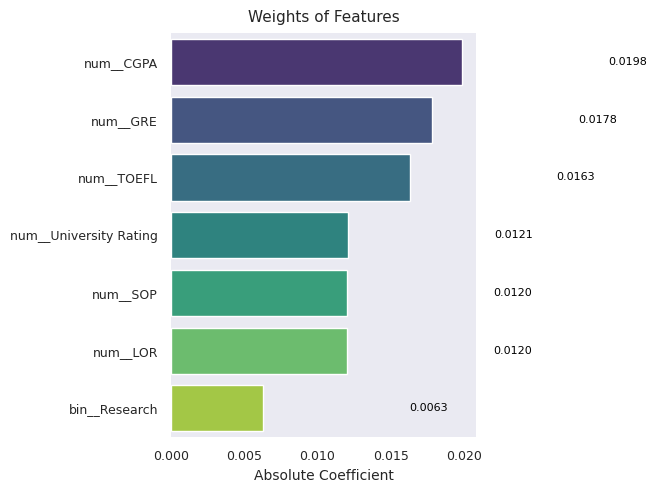

---------------
Ridge(alpha = 1000) Test R²   : 0.7050
Ridge(alpha = 1000) Test Adj.R² : 0.6826
Ridge(alpha = 1000) Test RMSE: 0.0777
Ridge(alpha = 1000) Test MSE : 0.0060
Ridge(alpha = 1000) Test MAE : 0.0583
---------------
Ridge(alpha = 1000) Train R²   : 0.6865
Ridge(alpha = 1000) Train Adj.R² : 0.6809
Ridge(alpha = 1000) Train RMSE: 0.0786
Ridge(alpha = 1000) Train MSE : 0.0062
Ridge(alpha = 1000) Train MAE : 0.0610

For alpha =  100
---------------


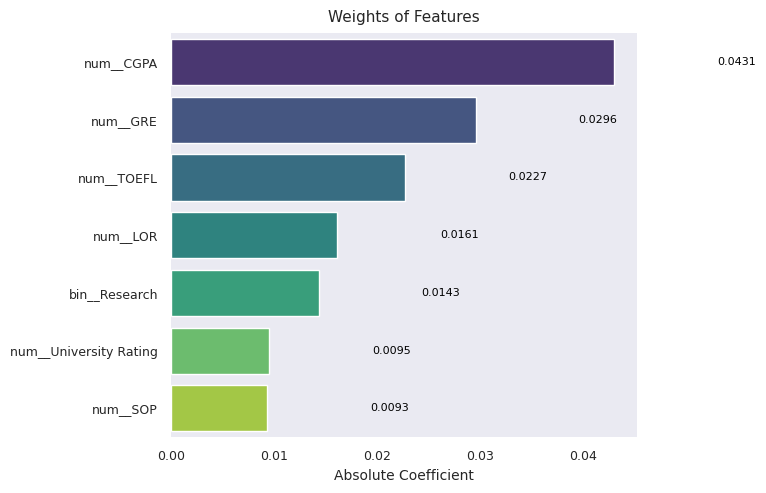

---------------
Ridge(alpha = 100) Test R²   : 0.8128
Ridge(alpha = 100) Test Adj.R² : 0.7985
Ridge(alpha = 100) Test RMSE: 0.0619
Ridge(alpha = 100) Test MSE : 0.0038
Ridge(alpha = 100) Test MAE : 0.0433
---------------
Ridge(alpha = 100) Train R²   : 0.8100
Ridge(alpha = 100) Train Adj.R² : 0.8066
Ridge(alpha = 100) Train RMSE: 0.0612
Ridge(alpha = 100) Train MSE : 0.0037
Ridge(alpha = 100) Train MAE : 0.0439

For alpha =  10
---------------


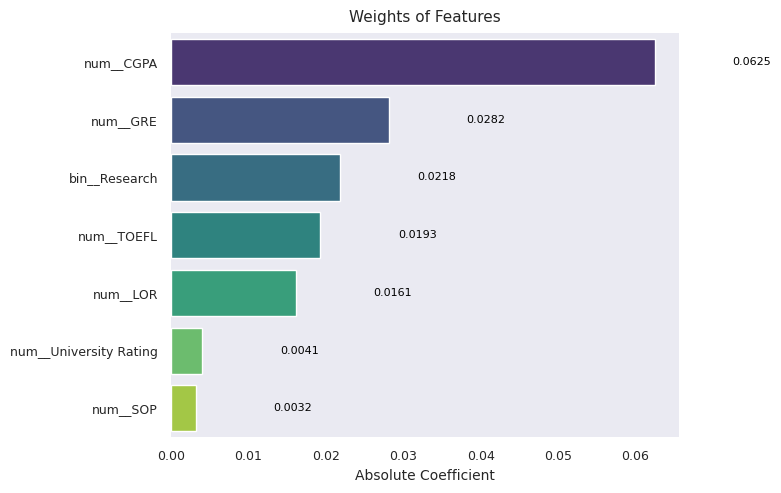

---------------
Ridge(alpha = 10) Test R²   : 0.8182
Ridge(alpha = 10) Test Adj.R² : 0.8043
Ridge(alpha = 10) Test RMSE: 0.0610
Ridge(alpha = 10) Test MSE : 0.0037
Ridge(alpha = 10) Test MAE : 0.0428
---------------
Ridge(alpha = 10) Train R²   : 0.8207
Ridge(alpha = 10) Train Adj.R² : 0.8175
Ridge(alpha = 10) Train RMSE: 0.0594
Ridge(alpha = 10) Train MSE : 0.0035
Ridge(alpha = 10) Train MAE : 0.0425

For alpha =  0.1
---------------


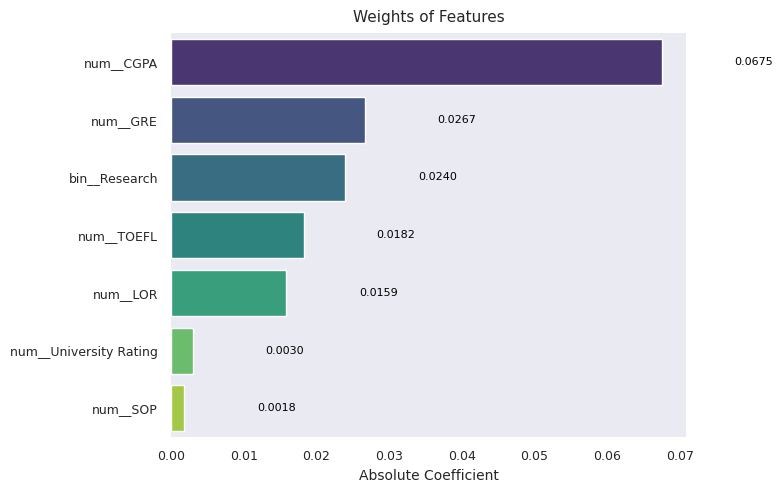

---------------
Ridge(alpha = 0.1) Test R²   : 0.8188
Ridge(alpha = 0.1) Test Adj.R² : 0.8051
Ridge(alpha = 0.1) Test RMSE: 0.0609
Ridge(alpha = 0.1) Test MSE : 0.0037
Ridge(alpha = 0.1) Test MAE : 0.0427
---------------
Ridge(alpha = 0.1) Train R²   : 0.8211
Ridge(alpha = 0.1) Train Adj.R² : 0.8179
Ridge(alpha = 0.1) Train RMSE: 0.0594
Ridge(alpha = 0.1) Train MSE : 0.0035
Ridge(alpha = 0.1) Train MAE : 0.0425

For alpha =  0.01
---------------


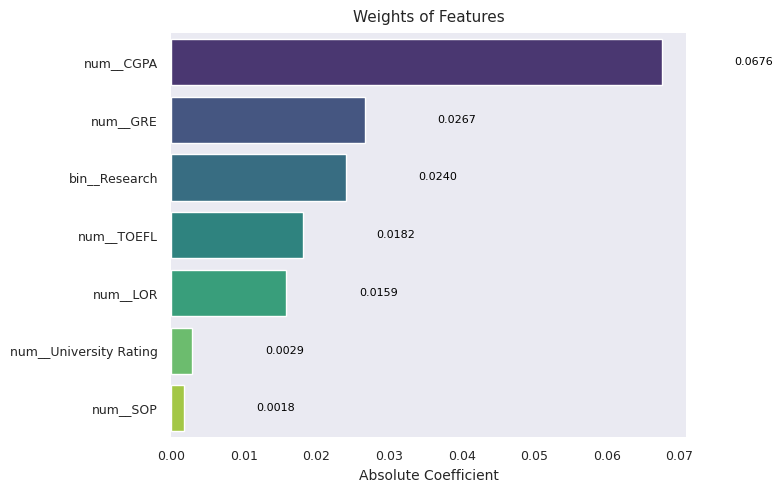

---------------
Ridge(alpha = 0.01) Test R²   : 0.8188
Ridge(alpha = 0.01) Test Adj.R² : 0.8051
Ridge(alpha = 0.01) Test RMSE: 0.0609
Ridge(alpha = 0.01) Test MSE : 0.0037
Ridge(alpha = 0.01) Test MAE : 0.0427
---------------
Ridge(alpha = 0.01) Train R²   : 0.8211
Ridge(alpha = 0.01) Train Adj.R² : 0.8179
Ridge(alpha = 0.01) Train RMSE: 0.0594
Ridge(alpha = 0.01) Train MSE : 0.0035
Ridge(alpha = 0.01) Train MAE : 0.0425

For alpha =  0.001
---------------


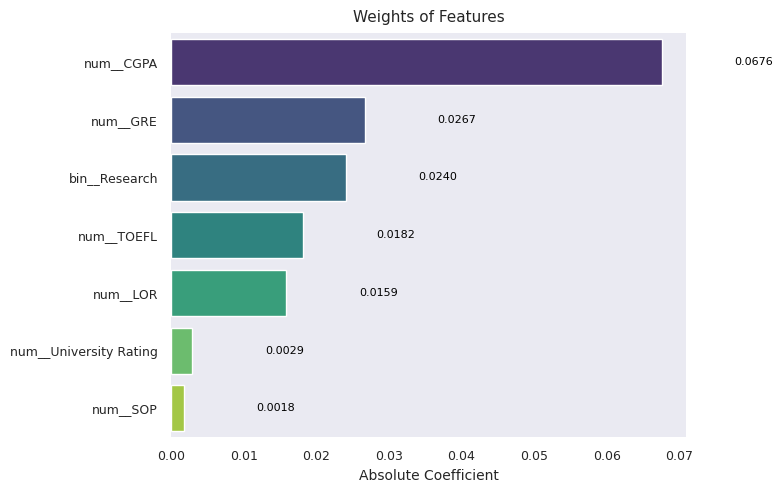

---------------
Ridge(alpha = 0.001) Test R²   : 0.8188
Ridge(alpha = 0.001) Test Adj.R² : 0.8051
Ridge(alpha = 0.001) Test RMSE: 0.0609
Ridge(alpha = 0.001) Test MSE : 0.0037
Ridge(alpha = 0.001) Test MAE : 0.0427
---------------
Ridge(alpha = 0.001) Train R²   : 0.8211
Ridge(alpha = 0.001) Train Adj.R² : 0.8179
Ridge(alpha = 0.001) Train RMSE: 0.0594
Ridge(alpha = 0.001) Train MSE : 0.0035
Ridge(alpha = 0.001) Train MAE : 0.0425

For alpha =  0.0001
---------------


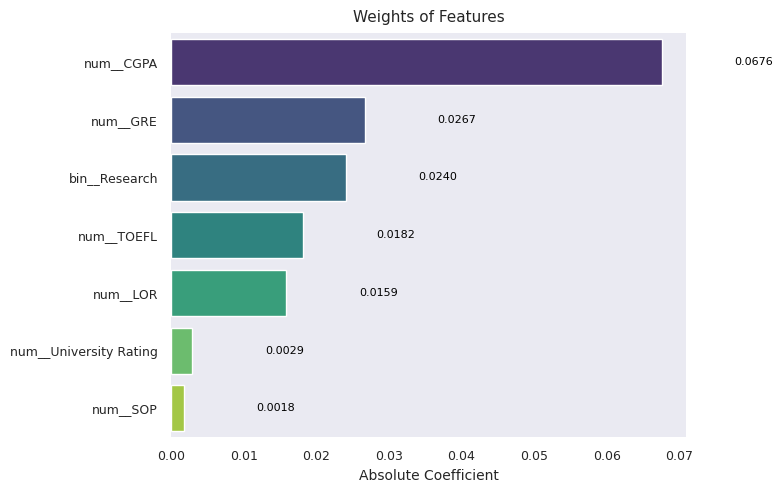

---------------
Ridge(alpha = 0.0001) Test R²   : 0.8188
Ridge(alpha = 0.0001) Test Adj.R² : 0.8051
Ridge(alpha = 0.0001) Test RMSE: 0.0609
Ridge(alpha = 0.0001) Test MSE : 0.0037
Ridge(alpha = 0.0001) Test MAE : 0.0427
---------------
Ridge(alpha = 0.0001) Train R²   : 0.8211
Ridge(alpha = 0.0001) Train Adj.R² : 0.8179
Ridge(alpha = 0.0001) Train RMSE: 0.0594
Ridge(alpha = 0.0001) Train MSE : 0.0035
Ridge(alpha = 0.0001) Train MAE : 0.0425

For alpha =  0.0006
---------------


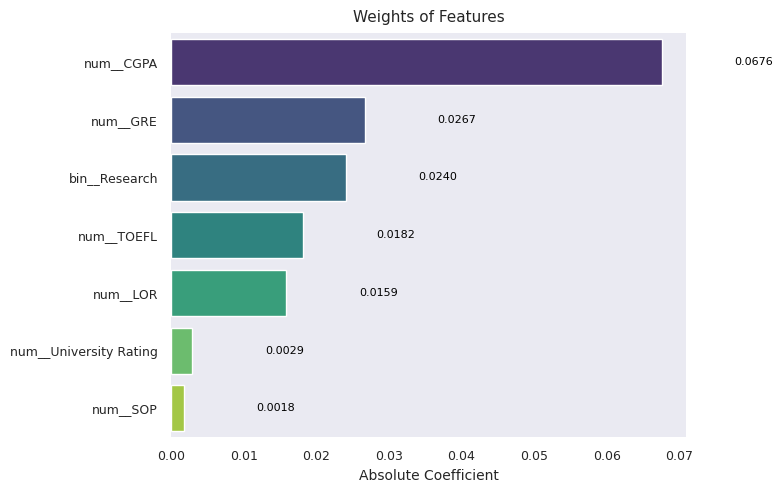

---------------
Ridge(alpha = 0.0006) Test R²   : 0.8188
Ridge(alpha = 0.0006) Test Adj.R² : 0.8051
Ridge(alpha = 0.0006) Test RMSE: 0.0609
Ridge(alpha = 0.0006) Test MSE : 0.0037
Ridge(alpha = 0.0006) Test MAE : 0.0427
---------------
Ridge(alpha = 0.0006) Train R²   : 0.8211
Ridge(alpha = 0.0006) Train Adj.R² : 0.8179
Ridge(alpha = 0.0006) Train RMSE: 0.0594
Ridge(alpha = 0.0006) Train MSE : 0.0035
Ridge(alpha = 0.0006) Train MAE : 0.0425



In [178]:
alphas = [10000, 1000, 100, 10, 0.1, 0.01, 0.001, 0.0001, 0.0006]
for i in alphas:
    print('For alpha = ', i)
    print('='*15)
    ridge_model = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("regressor", Ridge(alpha = i))
        ]
    )
    ridge_model.fit(X_train, y_train)
    print('-'*15)
    plot_model_weights(model_weights(ridge_model))
    print('-'*15)
    y_pred = ridge_model.predict(X_test)
    y_pred_train = ridge_model.predict(X_train)
    type = 'Ridge(alpha = '+str(i)+')'
    scores(X_test, y_test, y_pred, type = type+' Test')
    print('-'*15)
    scores(X_train, y_train, y_pred_train, type = type+' Train')
    print('='*15)
    print()


##ElasticNet()

For alpha =  1000  and l1_ratio =  0.1
---------------


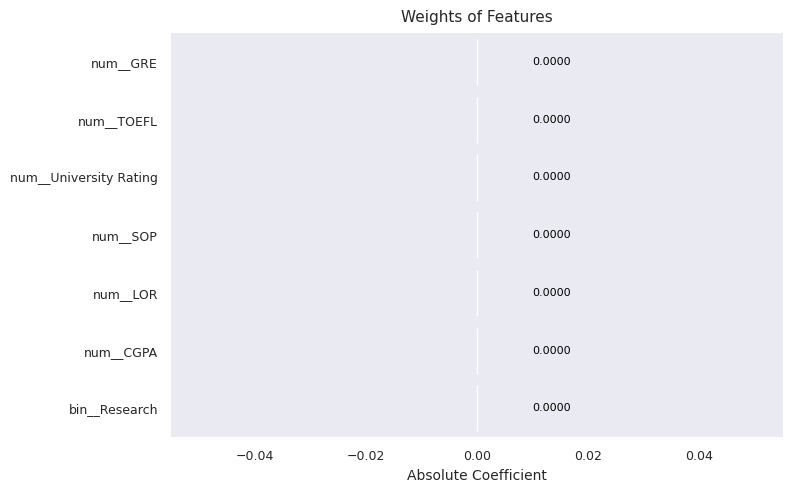

---------------
ElasticNet(alpha = 1000,l1_ratio = 0.1) Test R²   : -0.0072
ElasticNet(alpha = 1000,l1_ratio = 0.1) Test Adj.R² : -0.0839
ElasticNet(alpha = 1000,l1_ratio = 0.1) Test RMSE: 0.1435
ElasticNet(alpha = 1000,l1_ratio = 0.1) Test MSE : 0.0206
ElasticNet(alpha = 1000,l1_ratio = 0.1) Test MAE : 0.1163
---------------
ElasticNet(alpha = 1000,l1_ratio = 0.1) Train R²   : 0.0000
ElasticNet(alpha = 1000,l1_ratio = 0.1) Train Adj.R² : -0.0179
ElasticNet(alpha = 1000,l1_ratio = 0.1) Train RMSE: 0.1404
ElasticNet(alpha = 1000,l1_ratio = 0.1) Train MSE : 0.0197
ElasticNet(alpha = 1000,l1_ratio = 0.1) Train MAE : 0.1133

For alpha =  1000  and l1_ratio =  0.5
---------------


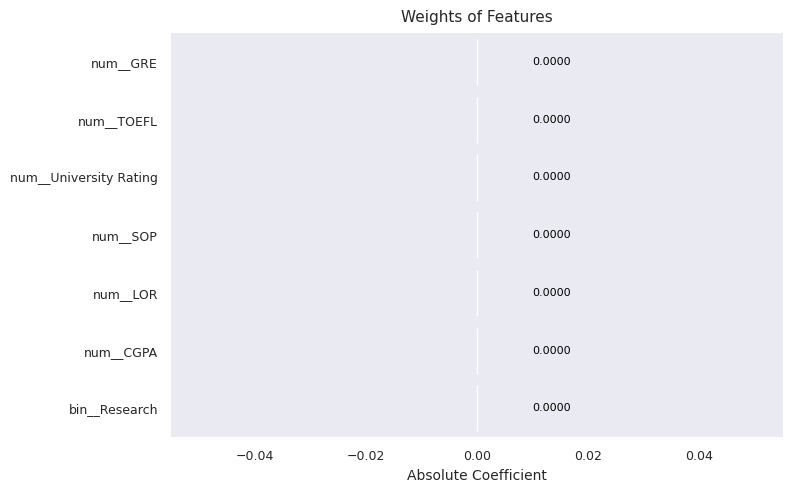

---------------
ElasticNet(alpha = 1000,l1_ratio = 0.5) Test R²   : -0.0072
ElasticNet(alpha = 1000,l1_ratio = 0.5) Test Adj.R² : -0.0839
ElasticNet(alpha = 1000,l1_ratio = 0.5) Test RMSE: 0.1435
ElasticNet(alpha = 1000,l1_ratio = 0.5) Test MSE : 0.0206
ElasticNet(alpha = 1000,l1_ratio = 0.5) Test MAE : 0.1163
---------------
ElasticNet(alpha = 1000,l1_ratio = 0.5) Train R²   : 0.0000
ElasticNet(alpha = 1000,l1_ratio = 0.5) Train Adj.R² : -0.0179
ElasticNet(alpha = 1000,l1_ratio = 0.5) Train RMSE: 0.1404
ElasticNet(alpha = 1000,l1_ratio = 0.5) Train MSE : 0.0197
ElasticNet(alpha = 1000,l1_ratio = 0.5) Train MAE : 0.1133

For alpha =  1000  and l1_ratio =  0.7
---------------


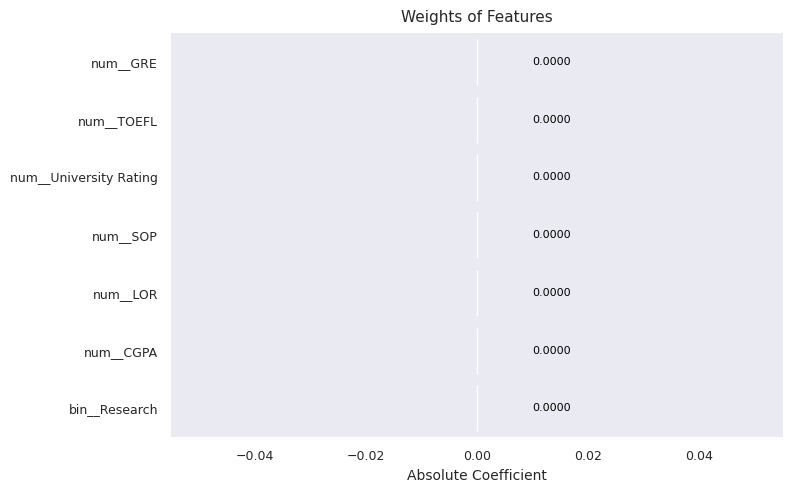

---------------
ElasticNet(alpha = 1000,l1_ratio = 0.7) Test R²   : -0.0072
ElasticNet(alpha = 1000,l1_ratio = 0.7) Test Adj.R² : -0.0839
ElasticNet(alpha = 1000,l1_ratio = 0.7) Test RMSE: 0.1435
ElasticNet(alpha = 1000,l1_ratio = 0.7) Test MSE : 0.0206
ElasticNet(alpha = 1000,l1_ratio = 0.7) Test MAE : 0.1163
---------------
ElasticNet(alpha = 1000,l1_ratio = 0.7) Train R²   : 0.0000
ElasticNet(alpha = 1000,l1_ratio = 0.7) Train Adj.R² : -0.0179
ElasticNet(alpha = 1000,l1_ratio = 0.7) Train RMSE: 0.1404
ElasticNet(alpha = 1000,l1_ratio = 0.7) Train MSE : 0.0197
ElasticNet(alpha = 1000,l1_ratio = 0.7) Train MAE : 0.1133

For alpha =  1000  and l1_ratio =  0.9
---------------


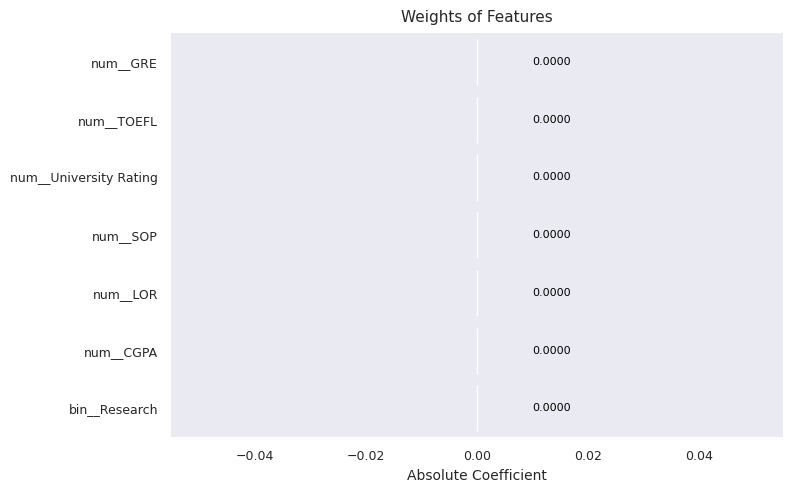

---------------
ElasticNet(alpha = 1000,l1_ratio = 0.9) Test R²   : -0.0072
ElasticNet(alpha = 1000,l1_ratio = 0.9) Test Adj.R² : -0.0839
ElasticNet(alpha = 1000,l1_ratio = 0.9) Test RMSE: 0.1435
ElasticNet(alpha = 1000,l1_ratio = 0.9) Test MSE : 0.0206
ElasticNet(alpha = 1000,l1_ratio = 0.9) Test MAE : 0.1163
---------------
ElasticNet(alpha = 1000,l1_ratio = 0.9) Train R²   : 0.0000
ElasticNet(alpha = 1000,l1_ratio = 0.9) Train Adj.R² : -0.0179
ElasticNet(alpha = 1000,l1_ratio = 0.9) Train RMSE: 0.1404
ElasticNet(alpha = 1000,l1_ratio = 0.9) Train MSE : 0.0197
ElasticNet(alpha = 1000,l1_ratio = 0.9) Train MAE : 0.1133

For alpha =  1000  and l1_ratio =  0.95
---------------


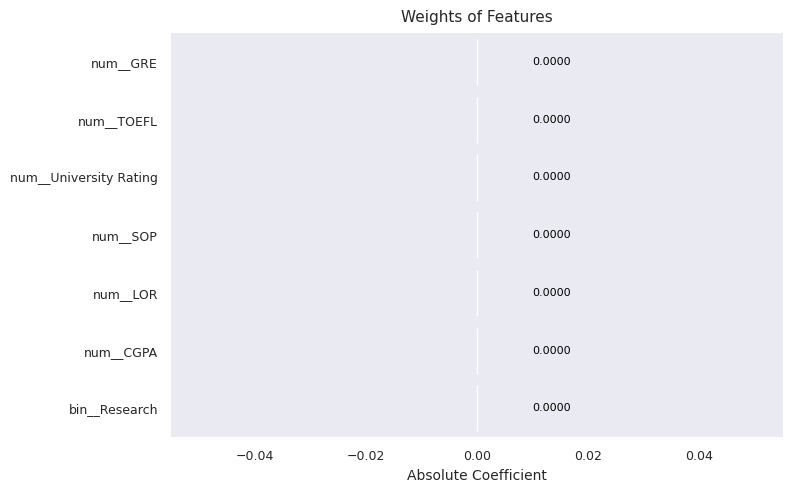

---------------
ElasticNet(alpha = 1000,l1_ratio = 0.95) Test R²   : -0.0072
ElasticNet(alpha = 1000,l1_ratio = 0.95) Test Adj.R² : -0.0839
ElasticNet(alpha = 1000,l1_ratio = 0.95) Test RMSE: 0.1435
ElasticNet(alpha = 1000,l1_ratio = 0.95) Test MSE : 0.0206
ElasticNet(alpha = 1000,l1_ratio = 0.95) Test MAE : 0.1163
---------------
ElasticNet(alpha = 1000,l1_ratio = 0.95) Train R²   : 0.0000
ElasticNet(alpha = 1000,l1_ratio = 0.95) Train Adj.R² : -0.0179
ElasticNet(alpha = 1000,l1_ratio = 0.95) Train RMSE: 0.1404
ElasticNet(alpha = 1000,l1_ratio = 0.95) Train MSE : 0.0197
ElasticNet(alpha = 1000,l1_ratio = 0.95) Train MAE : 0.1133

For alpha =  100  and l1_ratio =  0.1
---------------


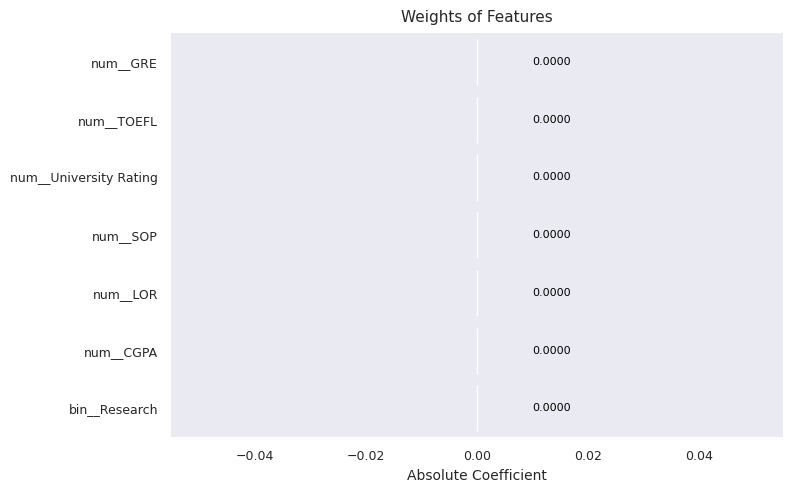

---------------
ElasticNet(alpha = 100,l1_ratio = 0.1) Test R²   : -0.0072
ElasticNet(alpha = 100,l1_ratio = 0.1) Test Adj.R² : -0.0839
ElasticNet(alpha = 100,l1_ratio = 0.1) Test RMSE: 0.1435
ElasticNet(alpha = 100,l1_ratio = 0.1) Test MSE : 0.0206
ElasticNet(alpha = 100,l1_ratio = 0.1) Test MAE : 0.1163
---------------
ElasticNet(alpha = 100,l1_ratio = 0.1) Train R²   : 0.0000
ElasticNet(alpha = 100,l1_ratio = 0.1) Train Adj.R² : -0.0179
ElasticNet(alpha = 100,l1_ratio = 0.1) Train RMSE: 0.1404
ElasticNet(alpha = 100,l1_ratio = 0.1) Train MSE : 0.0197
ElasticNet(alpha = 100,l1_ratio = 0.1) Train MAE : 0.1133

For alpha =  100  and l1_ratio =  0.5
---------------


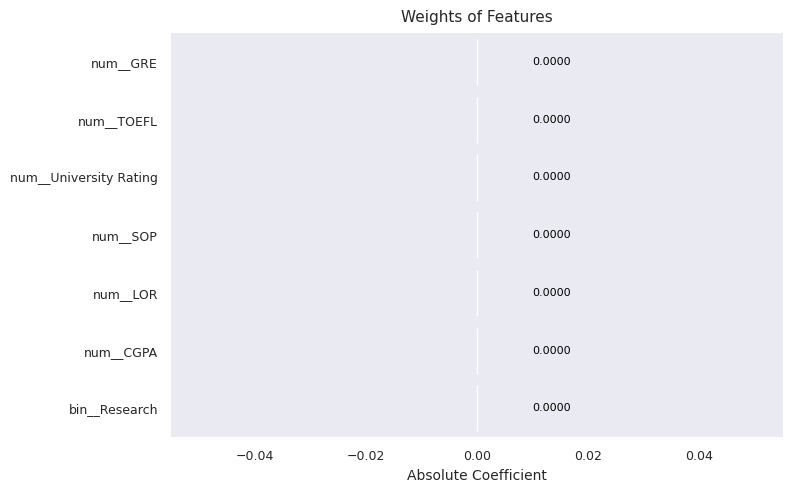

---------------
ElasticNet(alpha = 100,l1_ratio = 0.5) Test R²   : -0.0072
ElasticNet(alpha = 100,l1_ratio = 0.5) Test Adj.R² : -0.0839
ElasticNet(alpha = 100,l1_ratio = 0.5) Test RMSE: 0.1435
ElasticNet(alpha = 100,l1_ratio = 0.5) Test MSE : 0.0206
ElasticNet(alpha = 100,l1_ratio = 0.5) Test MAE : 0.1163
---------------
ElasticNet(alpha = 100,l1_ratio = 0.5) Train R²   : 0.0000
ElasticNet(alpha = 100,l1_ratio = 0.5) Train Adj.R² : -0.0179
ElasticNet(alpha = 100,l1_ratio = 0.5) Train RMSE: 0.1404
ElasticNet(alpha = 100,l1_ratio = 0.5) Train MSE : 0.0197
ElasticNet(alpha = 100,l1_ratio = 0.5) Train MAE : 0.1133

For alpha =  100  and l1_ratio =  0.7
---------------


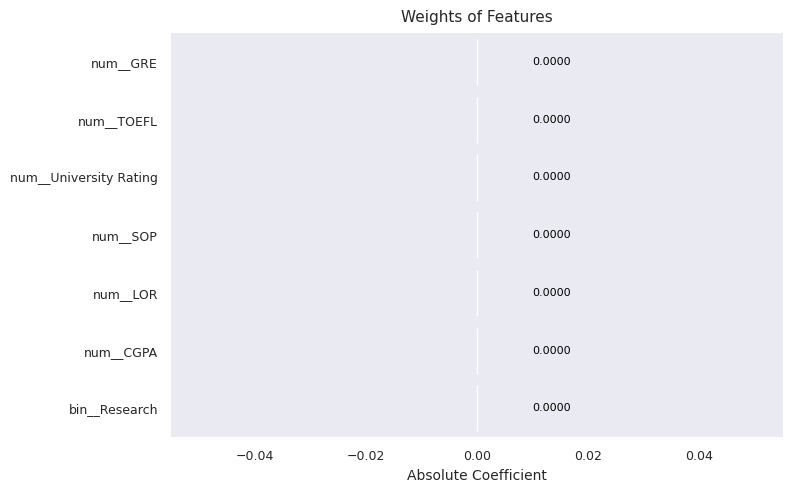

---------------
ElasticNet(alpha = 100,l1_ratio = 0.7) Test R²   : -0.0072
ElasticNet(alpha = 100,l1_ratio = 0.7) Test Adj.R² : -0.0839
ElasticNet(alpha = 100,l1_ratio = 0.7) Test RMSE: 0.1435
ElasticNet(alpha = 100,l1_ratio = 0.7) Test MSE : 0.0206
ElasticNet(alpha = 100,l1_ratio = 0.7) Test MAE : 0.1163
---------------
ElasticNet(alpha = 100,l1_ratio = 0.7) Train R²   : 0.0000
ElasticNet(alpha = 100,l1_ratio = 0.7) Train Adj.R² : -0.0179
ElasticNet(alpha = 100,l1_ratio = 0.7) Train RMSE: 0.1404
ElasticNet(alpha = 100,l1_ratio = 0.7) Train MSE : 0.0197
ElasticNet(alpha = 100,l1_ratio = 0.7) Train MAE : 0.1133

For alpha =  100  and l1_ratio =  0.9
---------------


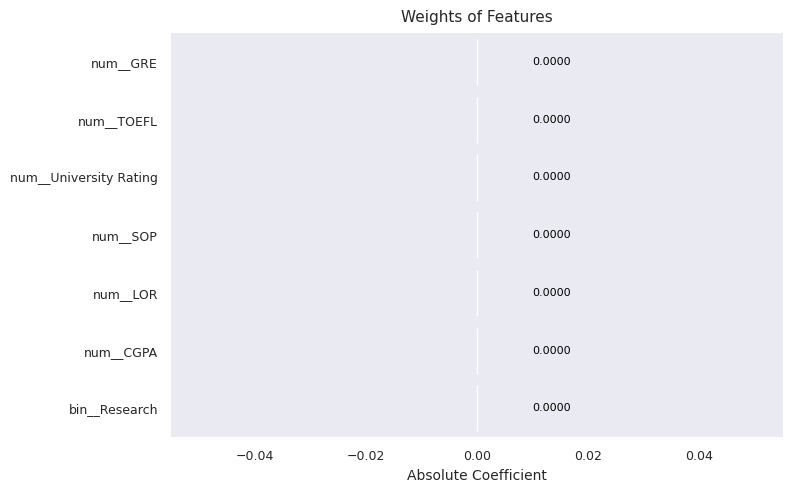

---------------
ElasticNet(alpha = 100,l1_ratio = 0.9) Test R²   : -0.0072
ElasticNet(alpha = 100,l1_ratio = 0.9) Test Adj.R² : -0.0839
ElasticNet(alpha = 100,l1_ratio = 0.9) Test RMSE: 0.1435
ElasticNet(alpha = 100,l1_ratio = 0.9) Test MSE : 0.0206
ElasticNet(alpha = 100,l1_ratio = 0.9) Test MAE : 0.1163
---------------
ElasticNet(alpha = 100,l1_ratio = 0.9) Train R²   : 0.0000
ElasticNet(alpha = 100,l1_ratio = 0.9) Train Adj.R² : -0.0179
ElasticNet(alpha = 100,l1_ratio = 0.9) Train RMSE: 0.1404
ElasticNet(alpha = 100,l1_ratio = 0.9) Train MSE : 0.0197
ElasticNet(alpha = 100,l1_ratio = 0.9) Train MAE : 0.1133

For alpha =  100  and l1_ratio =  0.95
---------------


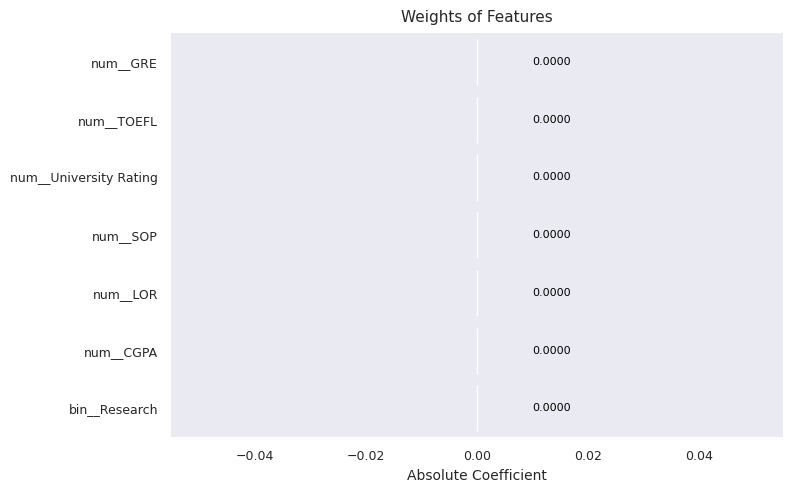

---------------
ElasticNet(alpha = 100,l1_ratio = 0.95) Test R²   : -0.0072
ElasticNet(alpha = 100,l1_ratio = 0.95) Test Adj.R² : -0.0839
ElasticNet(alpha = 100,l1_ratio = 0.95) Test RMSE: 0.1435
ElasticNet(alpha = 100,l1_ratio = 0.95) Test MSE : 0.0206
ElasticNet(alpha = 100,l1_ratio = 0.95) Test MAE : 0.1163
---------------
ElasticNet(alpha = 100,l1_ratio = 0.95) Train R²   : 0.0000
ElasticNet(alpha = 100,l1_ratio = 0.95) Train Adj.R² : -0.0179
ElasticNet(alpha = 100,l1_ratio = 0.95) Train RMSE: 0.1404
ElasticNet(alpha = 100,l1_ratio = 0.95) Train MSE : 0.0197
ElasticNet(alpha = 100,l1_ratio = 0.95) Train MAE : 0.1133

For alpha =  10  and l1_ratio =  0.1
---------------


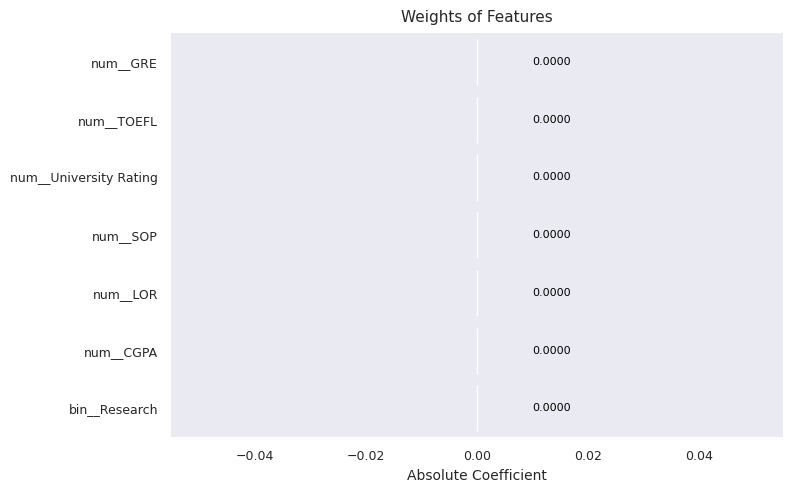

---------------
ElasticNet(alpha = 10,l1_ratio = 0.1) Test R²   : -0.0072
ElasticNet(alpha = 10,l1_ratio = 0.1) Test Adj.R² : -0.0839
ElasticNet(alpha = 10,l1_ratio = 0.1) Test RMSE: 0.1435
ElasticNet(alpha = 10,l1_ratio = 0.1) Test MSE : 0.0206
ElasticNet(alpha = 10,l1_ratio = 0.1) Test MAE : 0.1163
---------------
ElasticNet(alpha = 10,l1_ratio = 0.1) Train R²   : 0.0000
ElasticNet(alpha = 10,l1_ratio = 0.1) Train Adj.R² : -0.0179
ElasticNet(alpha = 10,l1_ratio = 0.1) Train RMSE: 0.1404
ElasticNet(alpha = 10,l1_ratio = 0.1) Train MSE : 0.0197
ElasticNet(alpha = 10,l1_ratio = 0.1) Train MAE : 0.1133

For alpha =  10  and l1_ratio =  0.5
---------------


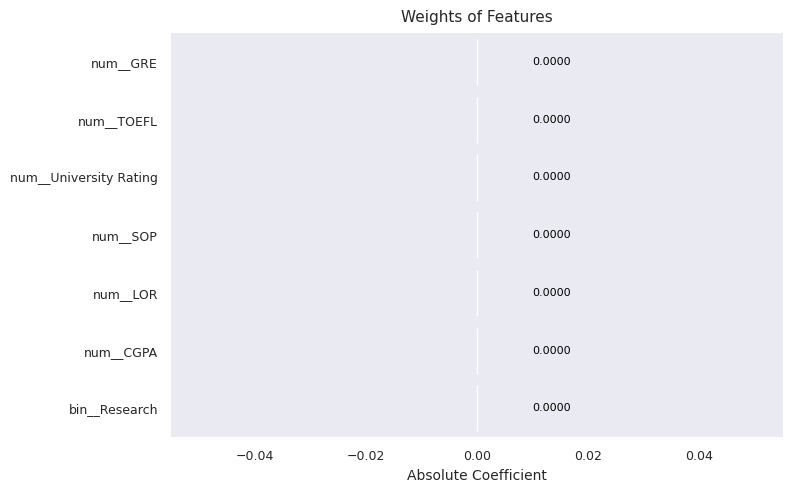

---------------
ElasticNet(alpha = 10,l1_ratio = 0.5) Test R²   : -0.0072
ElasticNet(alpha = 10,l1_ratio = 0.5) Test Adj.R² : -0.0839
ElasticNet(alpha = 10,l1_ratio = 0.5) Test RMSE: 0.1435
ElasticNet(alpha = 10,l1_ratio = 0.5) Test MSE : 0.0206
ElasticNet(alpha = 10,l1_ratio = 0.5) Test MAE : 0.1163
---------------
ElasticNet(alpha = 10,l1_ratio = 0.5) Train R²   : 0.0000
ElasticNet(alpha = 10,l1_ratio = 0.5) Train Adj.R² : -0.0179
ElasticNet(alpha = 10,l1_ratio = 0.5) Train RMSE: 0.1404
ElasticNet(alpha = 10,l1_ratio = 0.5) Train MSE : 0.0197
ElasticNet(alpha = 10,l1_ratio = 0.5) Train MAE : 0.1133

For alpha =  10  and l1_ratio =  0.7
---------------


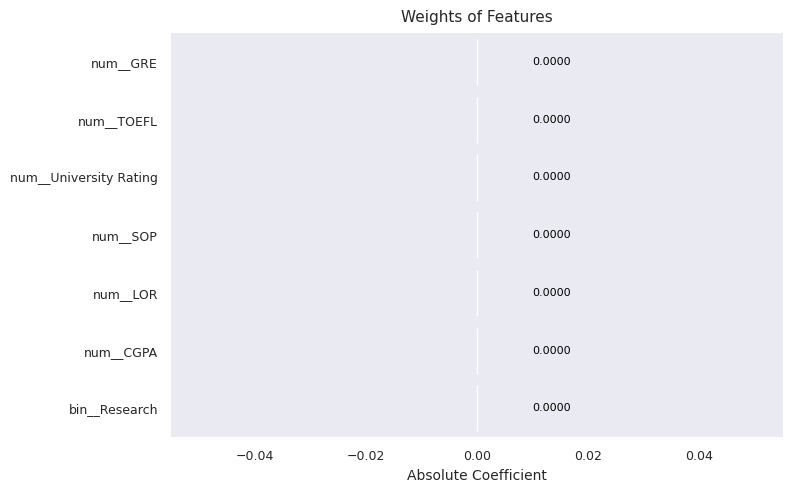

---------------
ElasticNet(alpha = 10,l1_ratio = 0.7) Test R²   : -0.0072
ElasticNet(alpha = 10,l1_ratio = 0.7) Test Adj.R² : -0.0839
ElasticNet(alpha = 10,l1_ratio = 0.7) Test RMSE: 0.1435
ElasticNet(alpha = 10,l1_ratio = 0.7) Test MSE : 0.0206
ElasticNet(alpha = 10,l1_ratio = 0.7) Test MAE : 0.1163
---------------
ElasticNet(alpha = 10,l1_ratio = 0.7) Train R²   : 0.0000
ElasticNet(alpha = 10,l1_ratio = 0.7) Train Adj.R² : -0.0179
ElasticNet(alpha = 10,l1_ratio = 0.7) Train RMSE: 0.1404
ElasticNet(alpha = 10,l1_ratio = 0.7) Train MSE : 0.0197
ElasticNet(alpha = 10,l1_ratio = 0.7) Train MAE : 0.1133

For alpha =  10  and l1_ratio =  0.9
---------------


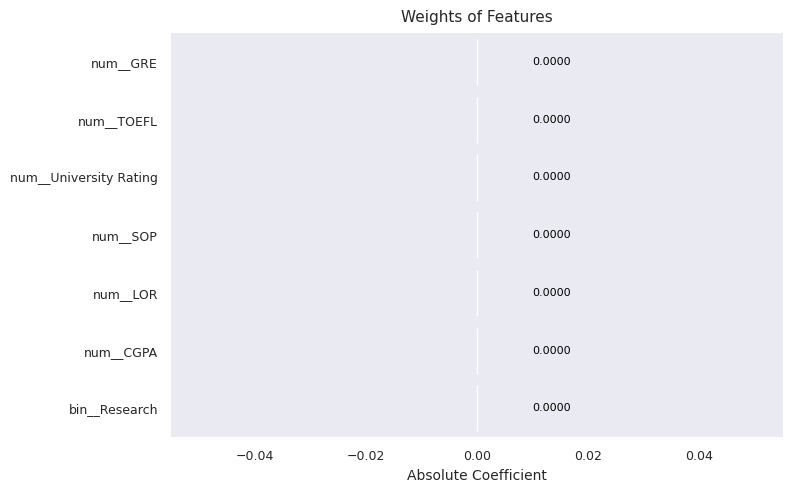

---------------
ElasticNet(alpha = 10,l1_ratio = 0.9) Test R²   : -0.0072
ElasticNet(alpha = 10,l1_ratio = 0.9) Test Adj.R² : -0.0839
ElasticNet(alpha = 10,l1_ratio = 0.9) Test RMSE: 0.1435
ElasticNet(alpha = 10,l1_ratio = 0.9) Test MSE : 0.0206
ElasticNet(alpha = 10,l1_ratio = 0.9) Test MAE : 0.1163
---------------
ElasticNet(alpha = 10,l1_ratio = 0.9) Train R²   : 0.0000
ElasticNet(alpha = 10,l1_ratio = 0.9) Train Adj.R² : -0.0179
ElasticNet(alpha = 10,l1_ratio = 0.9) Train RMSE: 0.1404
ElasticNet(alpha = 10,l1_ratio = 0.9) Train MSE : 0.0197
ElasticNet(alpha = 10,l1_ratio = 0.9) Train MAE : 0.1133

For alpha =  10  and l1_ratio =  0.95
---------------


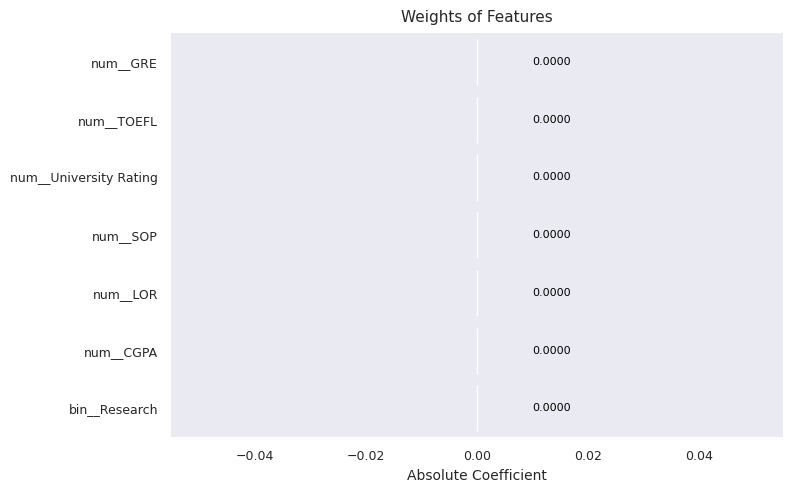

---------------
ElasticNet(alpha = 10,l1_ratio = 0.95) Test R²   : -0.0072
ElasticNet(alpha = 10,l1_ratio = 0.95) Test Adj.R² : -0.0839
ElasticNet(alpha = 10,l1_ratio = 0.95) Test RMSE: 0.1435
ElasticNet(alpha = 10,l1_ratio = 0.95) Test MSE : 0.0206
ElasticNet(alpha = 10,l1_ratio = 0.95) Test MAE : 0.1163
---------------
ElasticNet(alpha = 10,l1_ratio = 0.95) Train R²   : 0.0000
ElasticNet(alpha = 10,l1_ratio = 0.95) Train Adj.R² : -0.0179
ElasticNet(alpha = 10,l1_ratio = 0.95) Train RMSE: 0.1404
ElasticNet(alpha = 10,l1_ratio = 0.95) Train MSE : 0.0197
ElasticNet(alpha = 10,l1_ratio = 0.95) Train MAE : 0.1133

For alpha =  0.1  and l1_ratio =  0.1
---------------


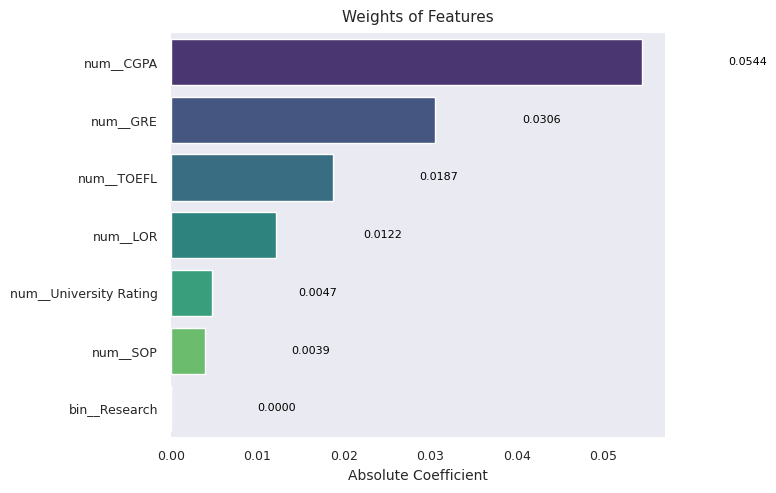

---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Test R²   : 0.8059
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Test Adj.R² : 0.7911
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Test RMSE: 0.0630
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Test MSE : 0.0040
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Test MAE : 0.0440
---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Train R²   : 0.8046
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Train Adj.R² : 0.8011
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Train RMSE: 0.0621
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Train MSE : 0.0039
ElasticNet(alpha = 0.1,l1_ratio = 0.1) Train MAE : 0.0449

For alpha =  0.1  and l1_ratio =  0.5
---------------


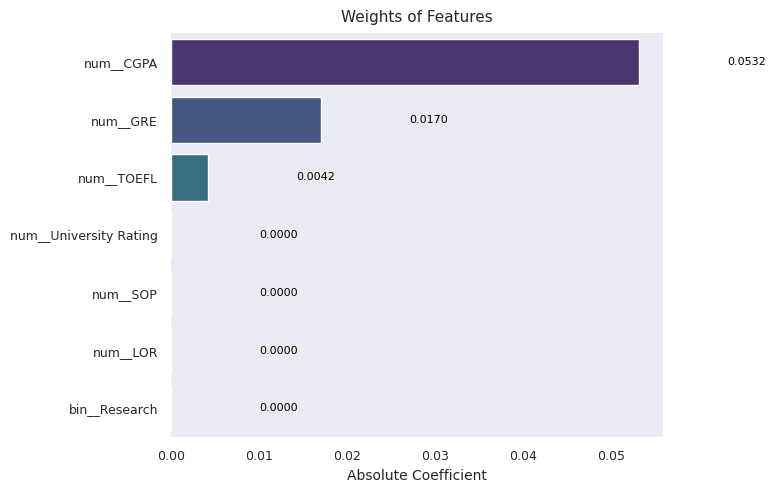

---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Test R²   : 0.6649
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Test Adj.R² : 0.6394
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Test RMSE: 0.0828
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Test MSE : 0.0069
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Test MAE : 0.0643
---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Train R²   : 0.6530
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Train Adj.R² : 0.6468
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Train RMSE: 0.0827
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Train MSE : 0.0068
ElasticNet(alpha = 0.1,l1_ratio = 0.5) Train MAE : 0.0652

For alpha =  0.1  and l1_ratio =  0.7
---------------


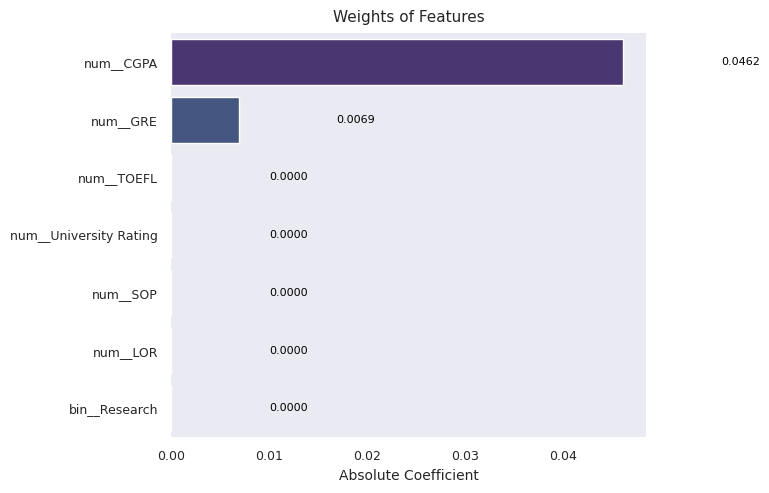

---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Test R²   : 0.5349
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Test Adj.R² : 0.4996
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Test RMSE: 0.0975
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Test MSE : 0.0095
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Test MAE : 0.0769
---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Train R²   : 0.5213
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Train Adj.R² : 0.5127
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Train RMSE: 0.0971
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Train MSE : 0.0094
ElasticNet(alpha = 0.1,l1_ratio = 0.7) Train MAE : 0.0778

For alpha =  0.1  and l1_ratio =  0.9
---------------


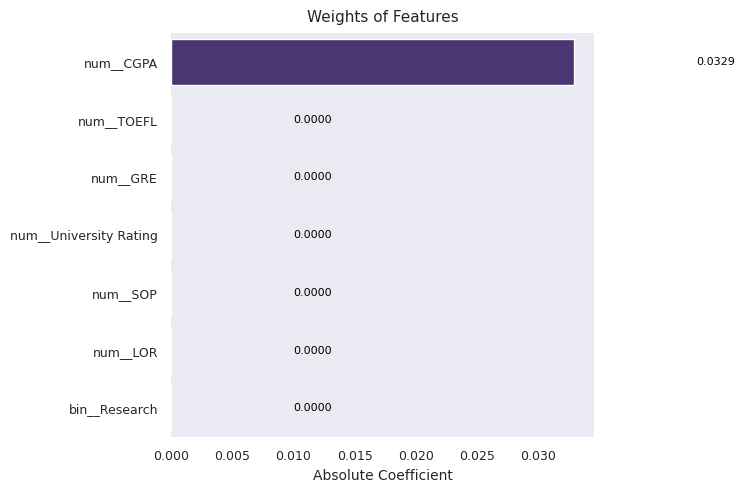

---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Test R²   : 0.3645
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Test Adj.R² : 0.3161
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Test RMSE: 0.1140
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Test MSE : 0.0130
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Test MAE : 0.0911
---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Train R²   : 0.3571
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Train Adj.R² : 0.3456
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Train RMSE: 0.1126
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Train MSE : 0.0127
ElasticNet(alpha = 0.1,l1_ratio = 0.9) Train MAE : 0.0908

For alpha =  0.1  and l1_ratio =  0.95
---------------


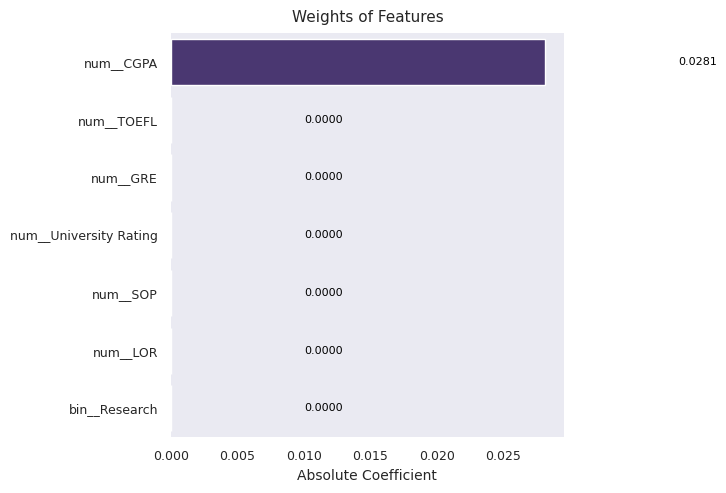

---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Test R²   : 0.3172
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Test Adj.R² : 0.2653
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Test RMSE: 0.1182
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Test MSE : 0.0140
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Test MAE : 0.0946
---------------
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Train R²   : 0.3118
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Train Adj.R² : 0.2995
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Train RMSE: 0.1165
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Train MSE : 0.0136
ElasticNet(alpha = 0.1,l1_ratio = 0.95) Train MAE : 0.0940

For alpha =  0.01  and l1_ratio =  0.1
---------------


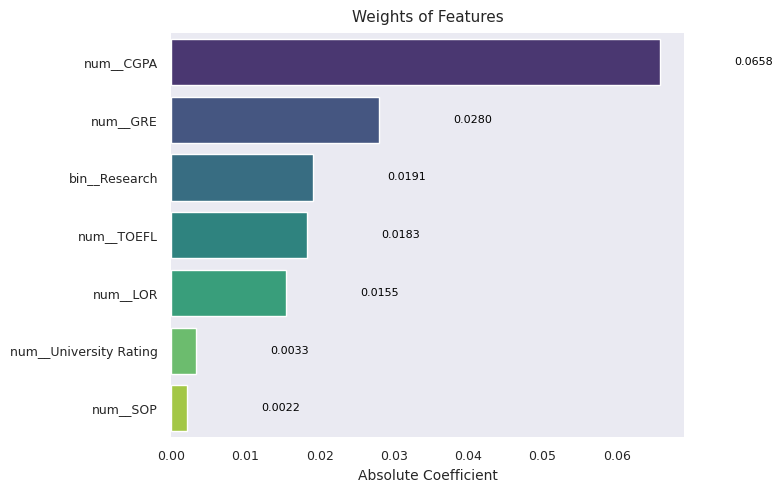

---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Test R²   : 0.8186
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Test Adj.R² : 0.8048
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Test RMSE: 0.0609
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Test MSE : 0.0037
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Test MAE : 0.0425
---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Train R²   : 0.8207
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Train Adj.R² : 0.8175
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Train RMSE: 0.0594
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Train MSE : 0.0035
ElasticNet(alpha = 0.01,l1_ratio = 0.1) Train MAE : 0.0425

For alpha =  0.01  and l1_ratio =  0.5
---------------


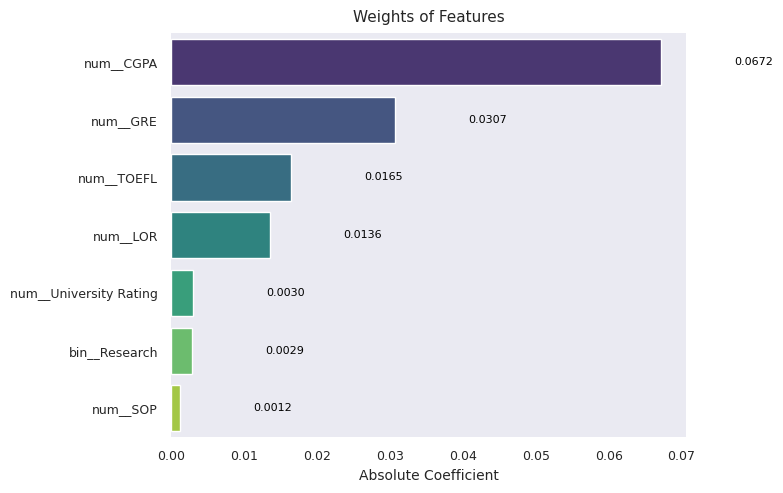

---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Test R²   : 0.8143
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Test Adj.R² : 0.8002
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Test RMSE: 0.0616
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Test MSE : 0.0038
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Test MAE : 0.0424
---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Train R²   : 0.8155
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Train Adj.R² : 0.8122
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Train RMSE: 0.0603
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Train MSE : 0.0036
ElasticNet(alpha = 0.01,l1_ratio = 0.5) Train MAE : 0.0430

For alpha =  0.01  and l1_ratio =  0.7
---------------


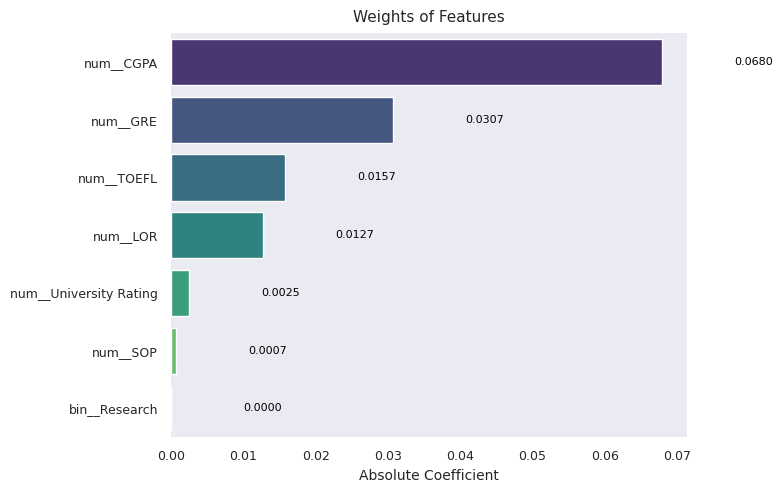

---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Test R²   : 0.8122
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Test Adj.R² : 0.7979
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Test RMSE: 0.0620
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Test MSE : 0.0038
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Test MAE : 0.0426
---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Train R²   : 0.8127
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Train Adj.R² : 0.8094
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Train RMSE: 0.0608
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Train MSE : 0.0037
ElasticNet(alpha = 0.01,l1_ratio = 0.7) Train MAE : 0.0434

For alpha =  0.01  and l1_ratio =  0.9
---------------


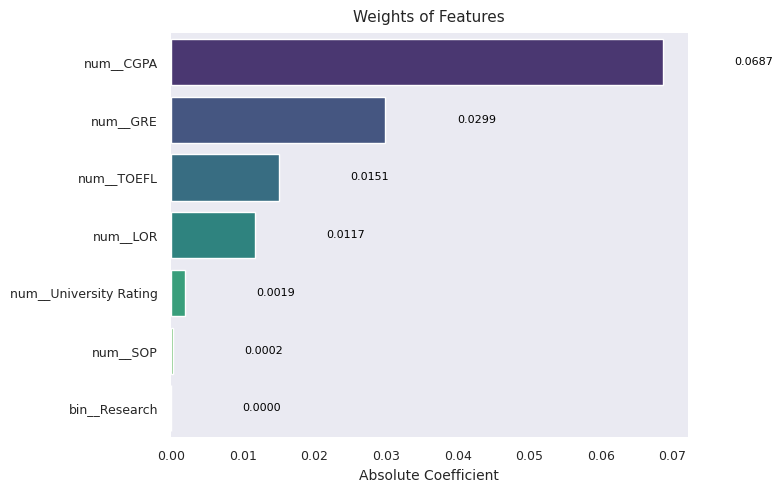

---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Test R²   : 0.8107
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Test Adj.R² : 0.7963
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Test RMSE: 0.0622
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Test MSE : 0.0039
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Test MAE : 0.0431
---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Train R²   : 0.8104
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Train Adj.R² : 0.8070
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Train RMSE: 0.0611
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Train MSE : 0.0037
ElasticNet(alpha = 0.01,l1_ratio = 0.9) Train MAE : 0.0439

For alpha =  0.01  and l1_ratio =  0.95
---------------


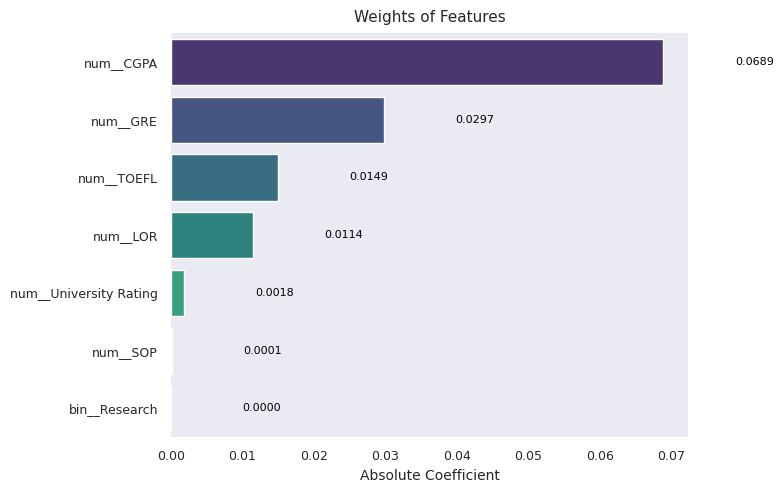

---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Test R²   : 0.8103
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Test Adj.R² : 0.7958
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Test RMSE: 0.0623
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Test MSE : 0.0039
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Test MAE : 0.0432
---------------
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Train R²   : 0.8097
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Train Adj.R² : 0.8063
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Train RMSE: 0.0612
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Train MSE : 0.0037
ElasticNet(alpha = 0.01,l1_ratio = 0.95) Train MAE : 0.0440

For alpha =  0.001  and l1_ratio =  0.1
---------------


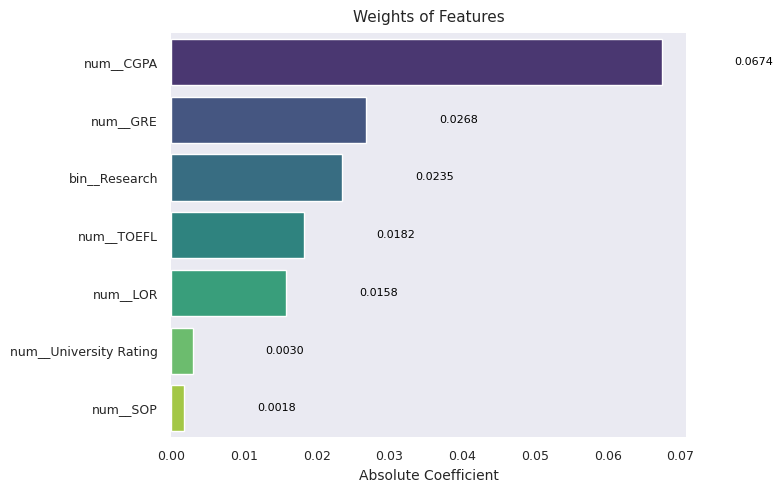

---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Test R²   : 0.8189
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Test RMSE: 0.0609
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Test MSE : 0.0037
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Test MAE : 0.0427
---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Train R²   : 0.8211
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Train Adj.R² : 0.8179
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Train RMSE: 0.0594
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Train MSE : 0.0035
ElasticNet(alpha = 0.001,l1_ratio = 0.1) Train MAE : 0.0425

For alpha =  0.001  and l1_ratio =  0.5
---------------


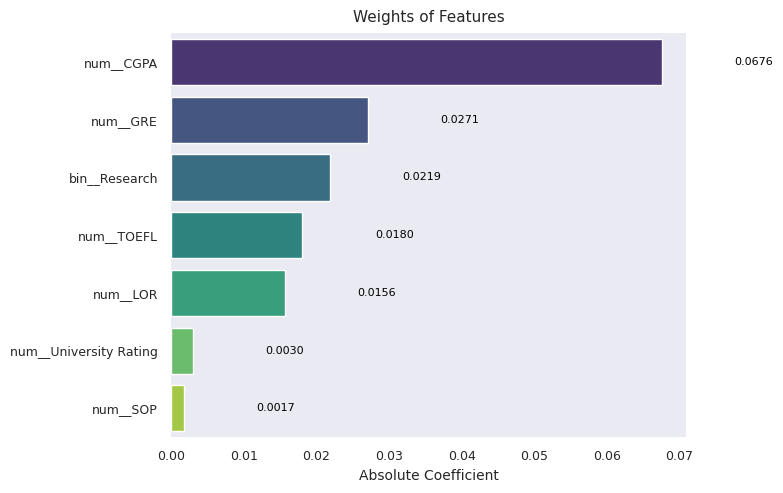

---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Test R²   : 0.8189
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Test RMSE: 0.0609
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Test MSE : 0.0037
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Test MAE : 0.0426
---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Train R²   : 0.8210
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Train Adj.R² : 0.8178
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Train RMSE: 0.0594
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Train MSE : 0.0035
ElasticNet(alpha = 0.001,l1_ratio = 0.5) Train MAE : 0.0425

For alpha =  0.001  and l1_ratio =  0.7
---------------


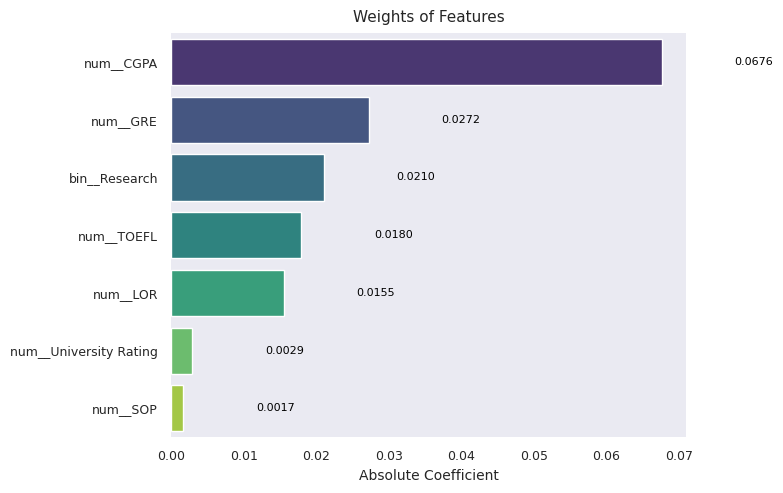

---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Test R²   : 0.8189
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Test RMSE: 0.0609
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Test MSE : 0.0037
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Test MAE : 0.0425
---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Train R²   : 0.8210
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Train Adj.R² : 0.8178
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Train RMSE: 0.0594
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Train MSE : 0.0035
ElasticNet(alpha = 0.001,l1_ratio = 0.7) Train MAE : 0.0425

For alpha =  0.001  and l1_ratio =  0.9
---------------


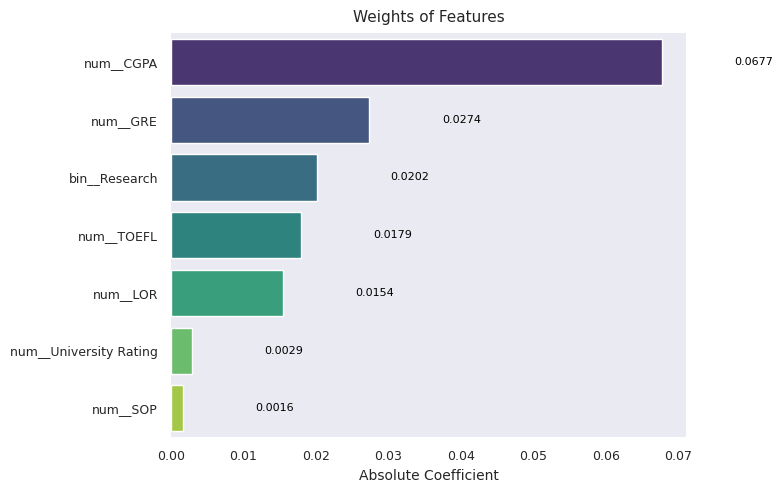

---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Test R²   : 0.8189
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Test RMSE: 0.0609
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Test MSE : 0.0037
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Test MAE : 0.0425
---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Train R²   : 0.8209
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Train Adj.R² : 0.8177
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Train RMSE: 0.0594
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Train MSE : 0.0035
ElasticNet(alpha = 0.001,l1_ratio = 0.9) Train MAE : 0.0425

For alpha =  0.001  and l1_ratio =  0.95
---------------


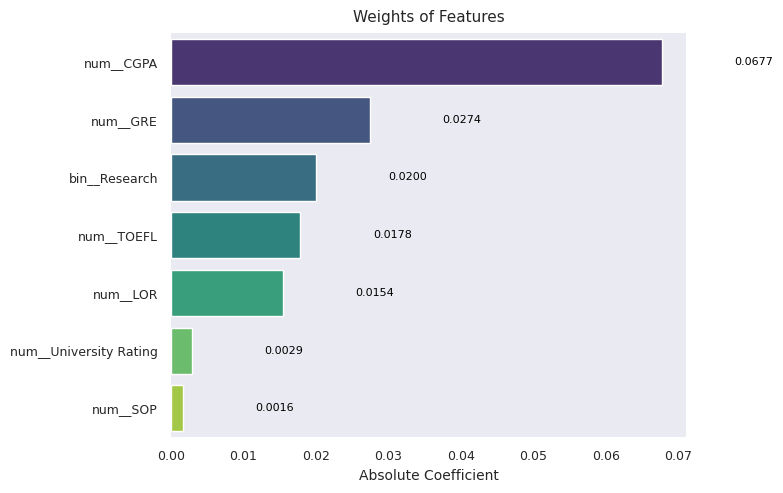

---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Test R²   : 0.8189
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Test RMSE: 0.0609
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Test MSE : 0.0037
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Test MAE : 0.0425
---------------
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Train R²   : 0.8209
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Train Adj.R² : 0.8177
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Train RMSE: 0.0594
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Train MSE : 0.0035
ElasticNet(alpha = 0.001,l1_ratio = 0.95) Train MAE : 0.0425

For alpha =  0.0001  and l1_ratio =  0.1
---------------


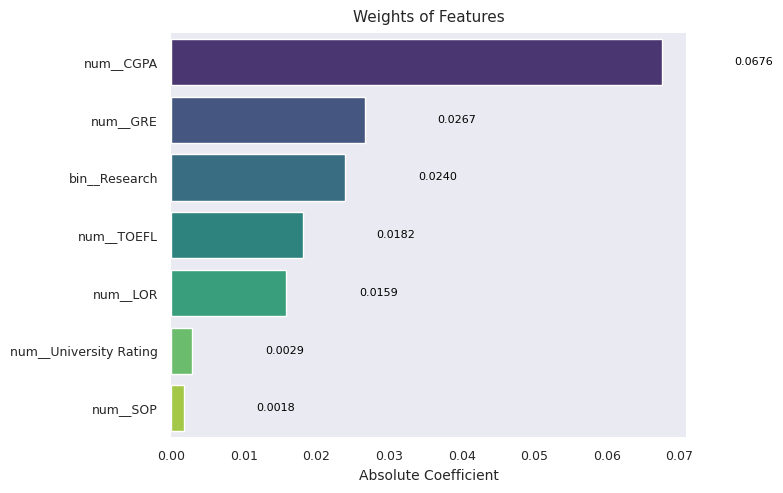

---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Test R²   : 0.8188
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Test RMSE: 0.0609
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Test MSE : 0.0037
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Test MAE : 0.0427
---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Train R²   : 0.8211
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Train Adj.R² : 0.8179
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Train RMSE: 0.0594
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Train MSE : 0.0035
ElasticNet(alpha = 0.0001,l1_ratio = 0.1) Train MAE : 0.0425

For alpha =  0.0001  and l1_ratio =  0.5
---------------


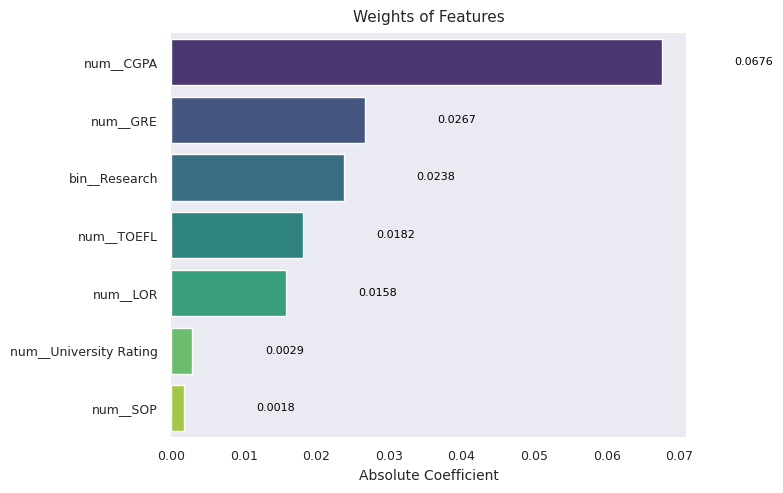

---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Test R²   : 0.8189
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Test RMSE: 0.0609
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Test MSE : 0.0037
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Test MAE : 0.0427
---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Train R²   : 0.8211
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Train Adj.R² : 0.8179
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Train RMSE: 0.0594
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Train MSE : 0.0035
ElasticNet(alpha = 0.0001,l1_ratio = 0.5) Train MAE : 0.0425

For alpha =  0.0001  and l1_ratio =  0.7
---------------


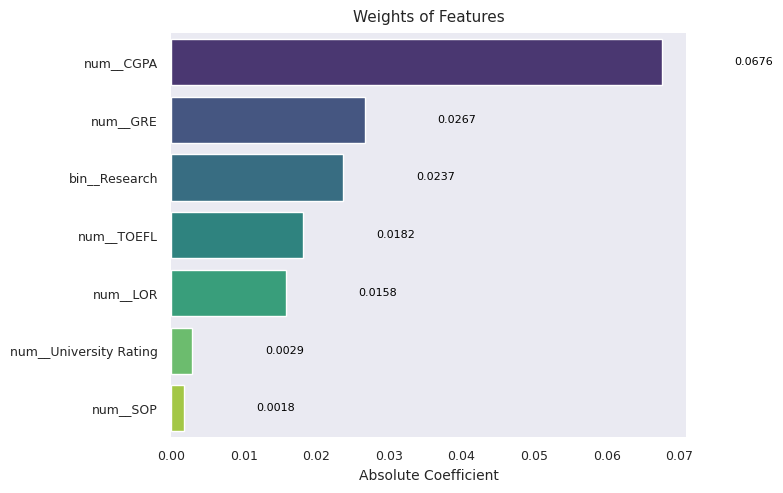

---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Test R²   : 0.8189
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Test RMSE: 0.0609
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Test MSE : 0.0037
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Test MAE : 0.0427
---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Train R²   : 0.8211
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Train Adj.R² : 0.8179
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Train RMSE: 0.0594
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Train MSE : 0.0035
ElasticNet(alpha = 0.0001,l1_ratio = 0.7) Train MAE : 0.0425

For alpha =  0.0001  and l1_ratio =  0.9
---------------


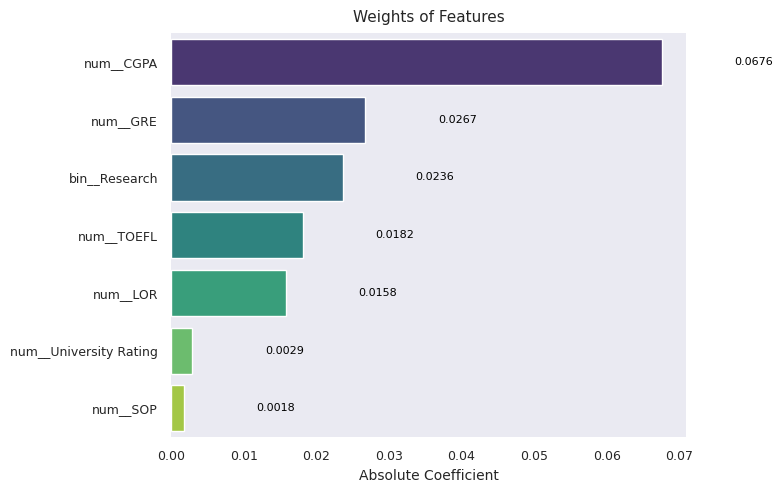

---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Test R²   : 0.8189
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Test RMSE: 0.0609
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Test MSE : 0.0037
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Test MAE : 0.0427
---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Train R²   : 0.8211
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Train Adj.R² : 0.8179
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Train RMSE: 0.0594
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Train MSE : 0.0035
ElasticNet(alpha = 0.0001,l1_ratio = 0.9) Train MAE : 0.0425

For alpha =  0.0001  and l1_ratio =  0.95
---------------


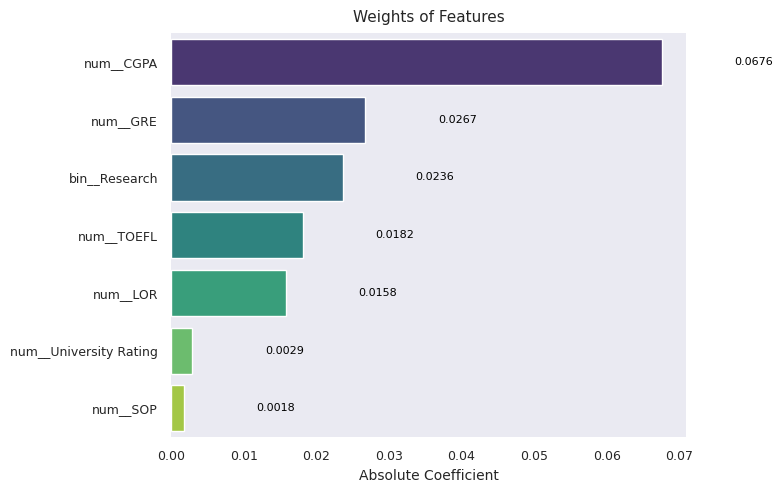

---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Test R²   : 0.8189
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Test Adj.R² : 0.8051
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Test RMSE: 0.0609
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Test MSE : 0.0037
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Test MAE : 0.0427
---------------
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Train R²   : 0.8211
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Train Adj.R² : 0.8179
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Train RMSE: 0.0594
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Train MSE : 0.0035
ElasticNet(alpha = 0.0001,l1_ratio = 0.95) Train MAE : 0.0425



In [179]:
alphas = [1000, 100, 10, 0.1, 0.01, 0.001, 0.0001]
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95]

for alpha in alphas:
    for l1_ratio in l1_ratios:
        print('For alpha = ', alpha, ' and l1_ratio = ', l1_ratio)
        print('='*15)
        elasticNet_model = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("regressor", ElasticNet(alpha = alpha, l1_ratio = l1_ratio))
            ]
        )
        elasticNet_model.fit(X_train, y_train)
        print('-'*15)
        plot_model_weights(model_weights(elasticNet_model))
        print('-'*15)
        y_pred = elasticNet_model.predict(X_test)
        y_pred_train = elasticNet_model.predict(X_train)
        type = 'ElasticNet(alpha = '+str(alpha)+',l1_ratio = '+str(l1_ratio)+')'
        scores(X_test, y_test, y_pred, type = type + ' Test')
        print('-'*15)
        scores(X_train, y_train, y_pred_train, type = type + ' Train')
        print('='*15)
        print()


- If we use `Ridge()`, `Lasso()` or `ElasticNet()` instead of `RidgeCV()`, `LassoCV()` or `ElasticNetCV()`, then we have to specify for which alpha(deafult = 1.0) we want to run regularization. We have to check for multiple values of alpha/lambda to find optimal one.

- But in Cross-validation(CV) functions it will automatically find the best lambda/alpha

##LassoCV

In [180]:

lassoCV_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LassoCV(cv=5))
    ]
)

In [181]:
lassoCV_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GRE', 'TOEFL',
                                                   'University Rating', 'SOP',
                                                   'LOR', 'CGPA']),
                                                 ('bin', 'passthrough',
                                                  ['Research'])])),
                ('regressor', LassoCV(cv=5))])

In [182]:
lassoCV_model.named_steps["regressor"].alpha_

np.float64(0.0006135456629007772)

In [183]:
model_weights(lassoCV_model)

Feature  Abs_Coefficient
5               num__CGPA         0.067687
0                num__GRE         0.027139
6           bin__Research         0.021416
1              num__TOEFL         0.017972
4                num__LOR         0.015580
2  num__University Rating         0.002923
3                num__SOP         0.001686

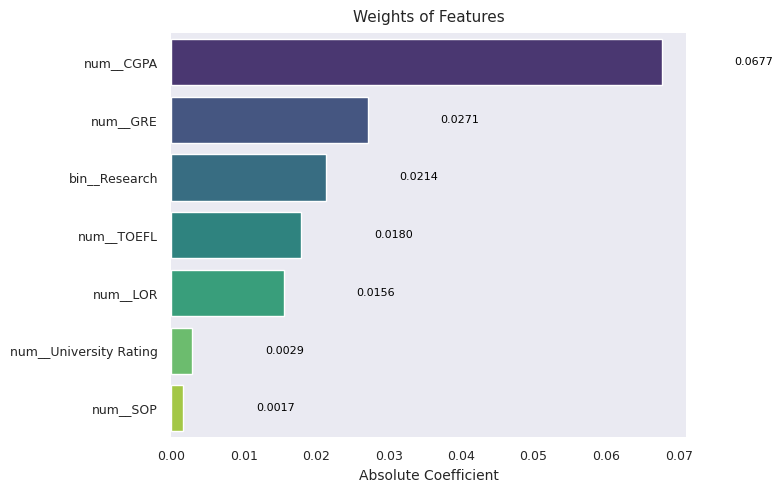

In [184]:
plot_model_weights(model_weights(lassoCV_model))

In [185]:
y_pred_lasso = lassoCV_model.predict(X_test)

In [186]:
scores(X_test, y_test, y_pred_lasso, type = 'LassoCV() Test')

LassoCV() Test R²   : 0.8189
LassoCV() Test Adj.R² : 0.8052
LassoCV() Test RMSE: 0.0609
LassoCV() Test MSE : 0.0037
LassoCV() Test MAE : 0.0425


In [187]:
y_pred_train_lasso = lassoCV_model.predict(X_train)

In [188]:
scores(X_train, y_train, y_pred_train_lasso, type = 'LassoCV() Train')

LassoCV() Train R²   : 0.8210
LassoCV() Train Adj.R² : 0.8178
LassoCV() Train RMSE: 0.0594
LassoCV() Train MSE : 0.0035
LassoCV() Train MAE : 0.0425


##RidgeCV

In [189]:

ridgeCV_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", RidgeCV(cv=5))
    ]
)

In [190]:
ridgeCV_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GRE', 'TOEFL',
                                                   'University Rating', 'SOP',
                                                   'LOR', 'CGPA']),
                                                 ('bin', 'passthrough',
                                                  ['Research'])])),
                ('regressor', RidgeCV(cv=5))])

In [191]:
ridgeCV_model.named_steps["regressor"].alpha_

np.float64(10.0)

In [192]:
model_weights(ridgeCV_model)

Feature  Abs_Coefficient
5               num__CGPA         0.062542
0                num__GRE         0.028190
6           bin__Research         0.021824
1              num__TOEFL         0.019303
4                num__LOR         0.016082
2  num__University Rating         0.004058
3                num__SOP         0.003167

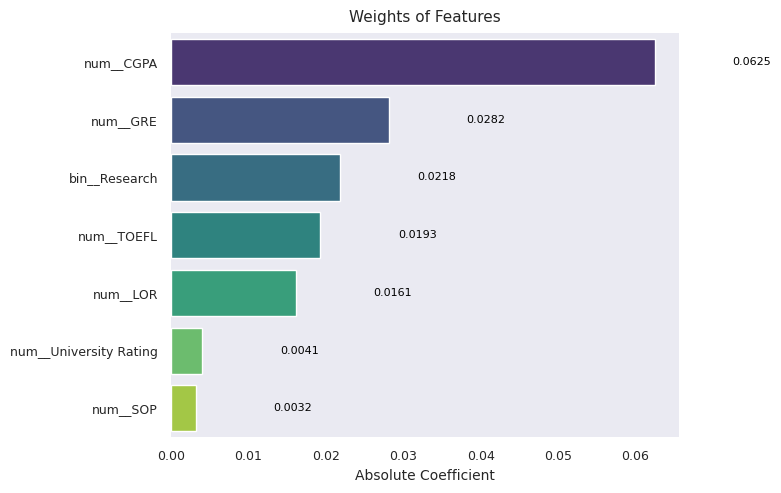

In [193]:
plot_model_weights(model_weights(ridgeCV_model))

In [194]:
y_pred_ridge = ridgeCV_model.predict(X_test)

In [195]:
scores(X_test, y_test, y_pred_ridge, type = 'RidgeCV() Test')

RidgeCV() Test R²   : 0.8182
RidgeCV() Test Adj.R² : 0.8043
RidgeCV() Test RMSE: 0.0610
RidgeCV() Test MSE : 0.0037
RidgeCV() Test MAE : 0.0428


In [196]:
y_pred_train_ridge = ridgeCV_model.predict(X_train)

In [197]:
scores(X_train, y_train, y_pred_train_ridge, type = 'RidgeCV() Train')

RidgeCV() Train R²   : 0.8207
RidgeCV() Train Adj.R² : 0.8175
RidgeCV() Train RMSE: 0.0594
RidgeCV() Train MSE : 0.0035
RidgeCV() Train MAE : 0.0425


##ElasticNetCV()

In [198]:

ElasticNetCV_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", ElasticNetCV(cv=5))
    ]
)

In [199]:
ElasticNetCV_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GRE', 'TOEFL',
                                                   'University Rating', 'SOP',
                                                   'LOR', 'CGPA']),
                                                 ('bin', 'passthrough',
                                                  ['Research'])])),
                ('regressor', ElasticNetCV(cv=5))])

In [200]:
ElasticNetCV_model.named_steps["regressor"].alpha_

np.float64(0.0011443894773738974)

In [207]:
ElasticNetCV_model.named_steps["regressor"].l1_ratio_

np.float64(0.5)

In [201]:
model_weights(ElasticNetCV_model)

Feature  Abs_Coefficient
5               num__CGPA         0.067549
0                num__GRE         0.027148
6           bin__Research         0.021542
1              num__TOEFL         0.018018
4                num__LOR         0.015606
2  num__University Rating         0.002952
3                num__SOP         0.001728

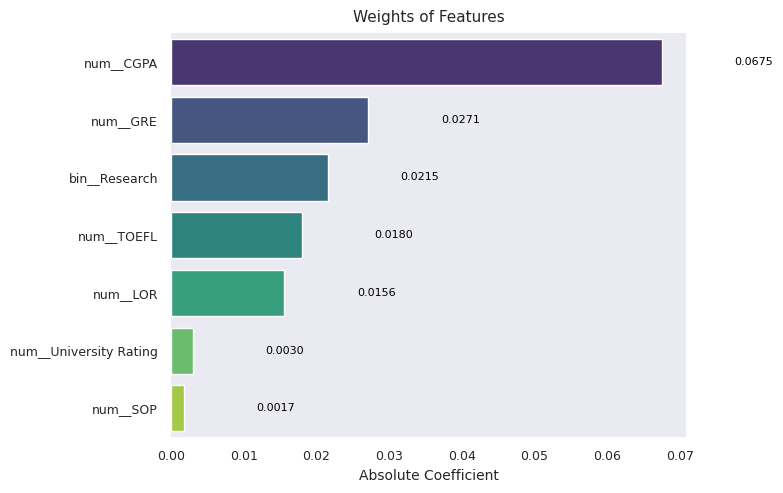

In [202]:
plot_model_weights(model_weights(ElasticNetCV_model))

In [203]:
y_pred_ElasticNet = ElasticNetCV_model.predict(X_test)

In [204]:
scores(X_test, y_test, y_pred_ElasticNet, type = 'ElasticNetCV() Test')

ElasticNetCV() Test R²   : 0.8189
ElasticNetCV() Test Adj.R² : 0.8051
ElasticNetCV() Test RMSE: 0.0609
ElasticNetCV() Test MSE : 0.0037
ElasticNetCV() Test MAE : 0.0426


In [205]:
y_pred_train_ElasticNet = ElasticNetCV_model.predict(X_train)

In [206]:
scores(X_train, y_train, y_pred_train_ElasticNet, type = 'ElasticNetCV() Train')

ElasticNetCV() Train R²   : 0.8210
ElasticNetCV() Train Adj.R² : 0.8178
ElasticNetCV() Train RMSE: 0.0594
ElasticNetCV() Train MSE : 0.0035
ElasticNetCV() Train MAE : 0.0425


# Polynomial Regression

In [208]:
X_train

GRE  TOEFL University Rating  SOP  LOR  CGPA Research
249  321    111                 3  3.5  4.0  8.83        1
433  316    111                 4  4.0  5.0  8.54        0
19   303    102                 3  3.5  3.0  8.50        0
322  314    107                 2  2.5  4.0  8.27        0
332  308    106                 3  3.5  2.5  8.21        1
..   ...    ...               ...  ...  ...   ...      ...
106  329    111                 4  4.5  4.5  9.18        1
270  306    105                 2  2.5  3.0  8.22        1
348  302     99                 1  2.0  2.0  7.25        0
435  309    105                 2  2.5  4.0  7.68        0
102  314    106                 2  4.0  3.5  8.25        0

[400 rows x 7 columns]

In [224]:
poly_features = ['GRE', 'TOEFL', 'CGPA',"LOR"]

num_cols = [
    "University Rating",
    "SOP"
]

bin_cols = ["Research"]

In [240]:
# 1. Create a mini-pipeline for the polynomial features
poly_pipeline = Pipeline([
    ("poly_gen", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

# 2. Use that pipeline inside your ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("poly_step", poly_pipeline, poly_features), # Polynomials then Scaled
        ("num", StandardScaler(), num_cols),         # Just Scaled
        ("bin", "passthrough", bin_cols)             # No change
    ]
)

poly_reg_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression())
    ]
)

In [241]:
poly_reg_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('poly_step',
                                                  Pipeline(steps=[('poly_gen',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GRE', 'TOEFL', 'CGPA',
                                                   'LOR']),
                                                 ('num', StandardScaler(),
                                                  ['University Rating', 'SOP']),
                                                 ('bin', 'passthrough',
                                                  ['Research'])])),
                ('regressor', LinearRegression())])

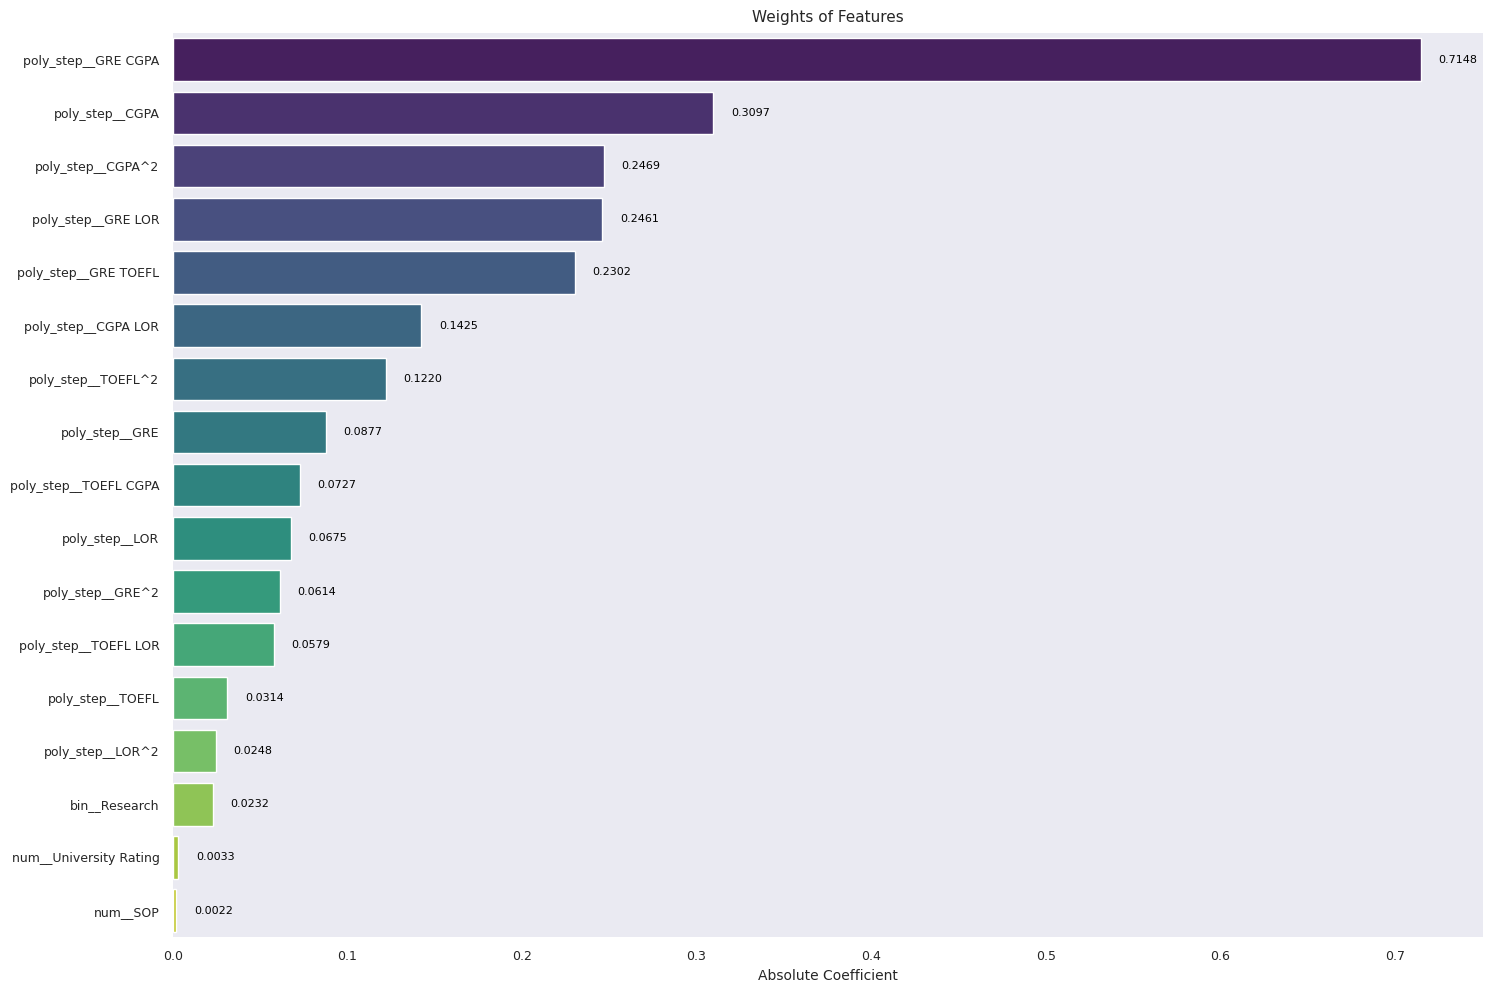

In [242]:
plot_model_weights(model_weights(poly_reg_model), fig_size = (15, 10))

In [243]:
y_pred_poly = poly_reg_model.predict(X_test)
y_pred_train_poly = poly_reg_model.predict(X_train)

In [244]:
scores(X_test, y_test, y_pred_poly, type = 'Polynomial Regression Test')

Polynomial Regression Test R²   : 0.8175
Polynomial Regression Test Adj.R² : 0.8036
Polynomial Regression Test RMSE: 0.0611
Polynomial Regression Test MSE : 0.0037
Polynomial Regression Test MAE : 0.0429


In [245]:
scores(X_train, y_train, y_pred_train_poly, type = 'Polynomial Regression Train')

Polynomial Regression Train R²   : 0.8232
Polynomial Regression Train Adj.R² : 0.8200
Polynomial Regression Train RMSE: 0.0590
Polynomial Regression Train MSE : 0.0035
Polynomial Regression Train MAE : 0.0419


##RidgeCV

In [246]:
poly_reg_ridge_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", RidgeCV(cv=5))
    ]
)

In [247]:
poly_reg_ridge_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('poly_step',
                                                  Pipeline(steps=[('poly_gen',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GRE', 'TOEFL', 'CGPA',
                                                   'LOR']),
                                                 ('num', StandardScaler(),
                                                  ['University Rating', 'SOP']),
                                                 ('bin', 'passthrough',
                                                  ['Research'])])),
                ('regressor', RidgeCV(cv=5))])

In [259]:
poly_reg_ridge_model.named_steps["regressor"].alpha_

np.float64(1.0)

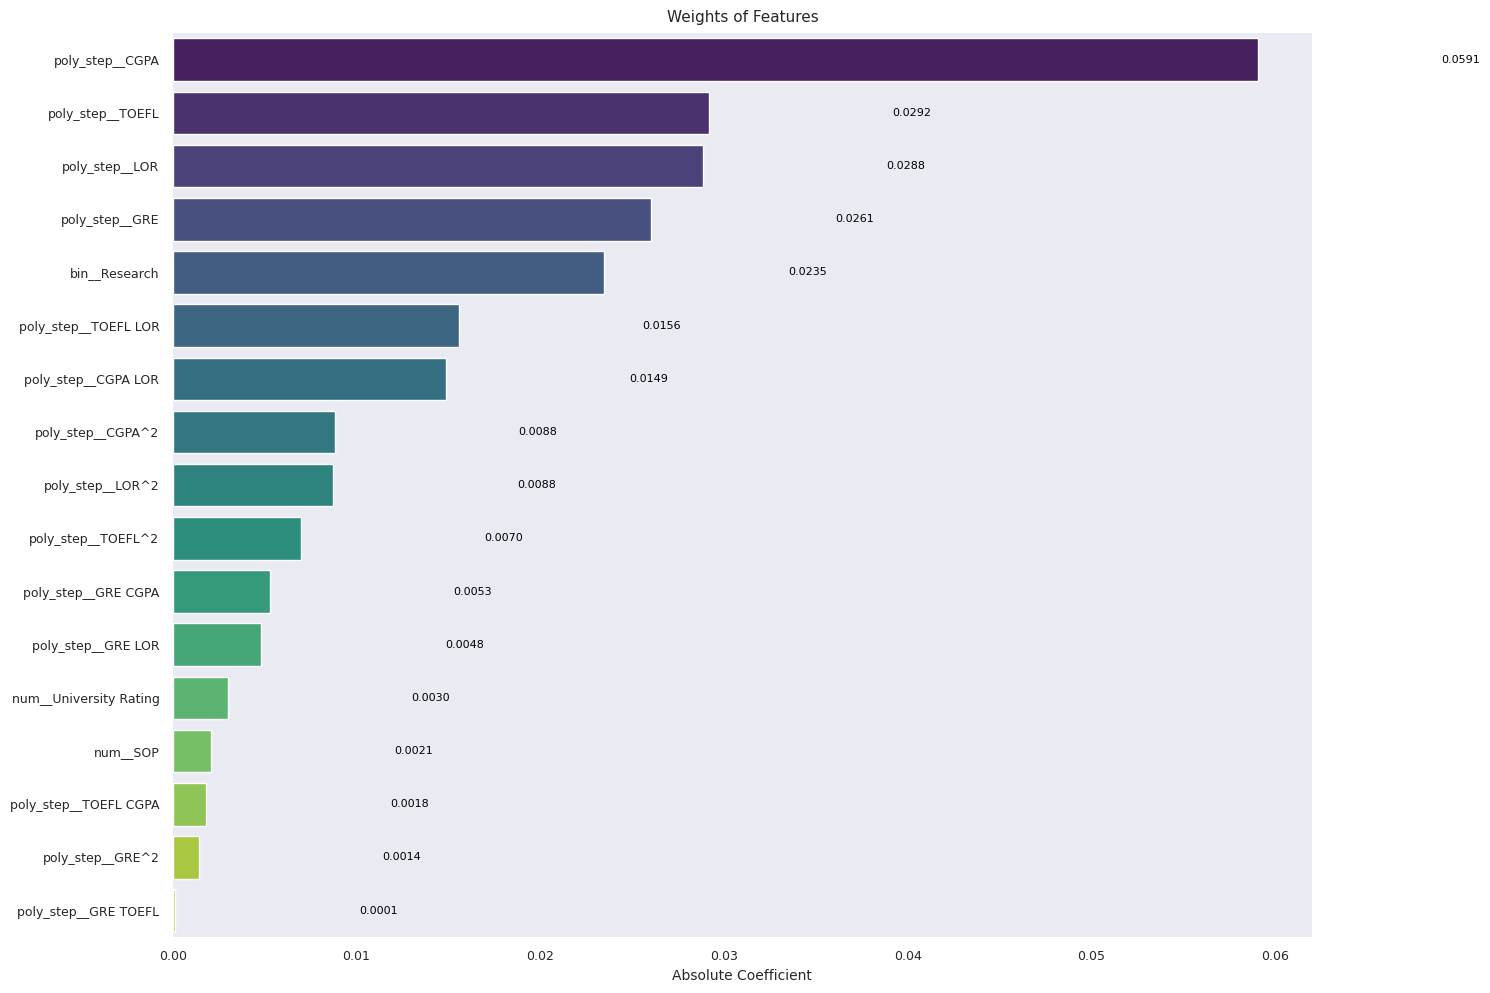

In [248]:
plot_model_weights(model_weights(poly_reg_ridge_model), fig_size = (15, 10))

In [249]:
y_pred_poly_ridge = poly_reg_ridge_model.predict(X_test)
y_pred_train_poly_ridge = poly_reg_ridge_model.predict(X_train)

In [250]:
scores(X_test, y_test, y_pred_poly_ridge, type = 'Polynomial Regression Ridge Test')

Polynomial Regression Ridge Test R²   : 0.8187
Polynomial Regression Ridge Test Adj.R² : 0.8049
Polynomial Regression Ridge Test RMSE: 0.0609
Polynomial Regression Ridge Test MSE : 0.0037
Polynomial Regression Ridge Test MAE : 0.0428


In [252]:
scores(X_train, y_train, y_pred_train_poly_ridge, type = 'Polynomial Regression Ridge Train')

Polynomial Regression Ridge Train R²   : 0.8214
Polynomial Regression Ridge Train Adj.R² : 0.8182
Polynomial Regression Ridge Train RMSE: 0.0593
Polynomial Regression Ridge Train MSE : 0.0035
Polynomial Regression Ridge Train MAE : 0.0425


##LassoCV

In [253]:
poly_reg_lasso_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LassoCV(cv=5))
    ]
)

In [254]:
poly_reg_lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('poly_step',
                                                  Pipeline(steps=[('poly_gen',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GRE', 'TOEFL', 'CGPA',
                                                   'LOR']),
                                                 ('num', StandardScaler(),
                                                  ['University Rating', 'SOP']),
                                                 ('bin', 'passthrough',
                                                  ['Research'])])),
                ('regressor', LassoCV(cv=5))])

In [260]:
poly_reg_lasso_model.named_steps["regressor"].alpha_

np.float64(0.0005823989281359198)

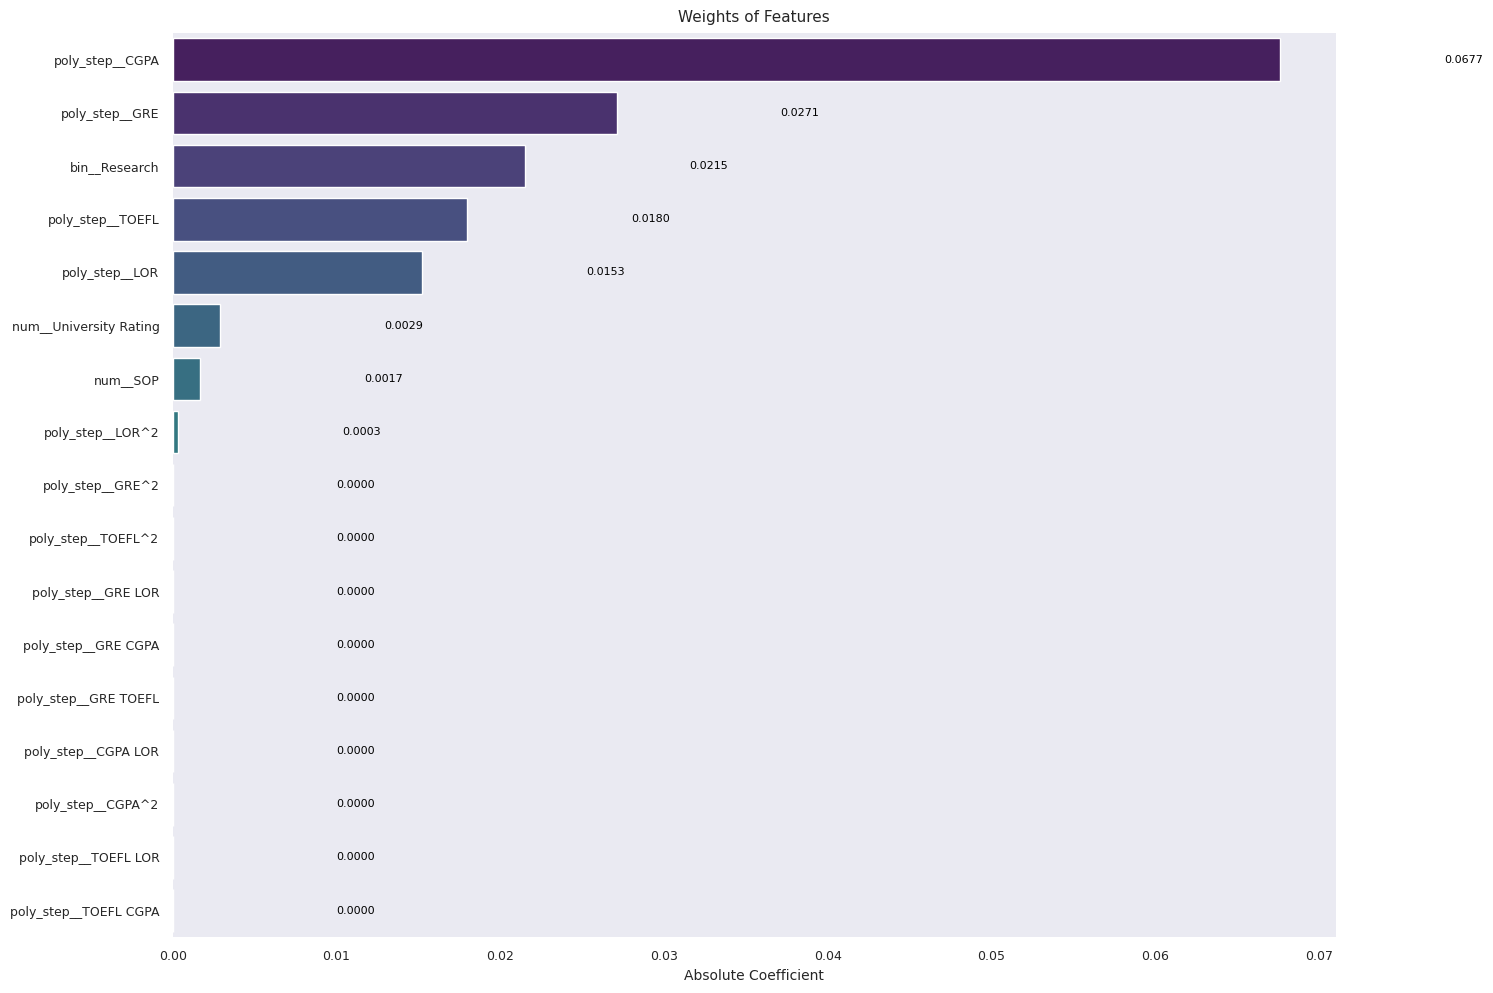

In [255]:
plot_model_weights(model_weights(poly_reg_lasso_model), fig_size = (15, 10))

In [256]:
y_pred_poly_lasso = poly_reg_lasso_model.predict(X_test)
y_pred_train_poly_lasso = poly_reg_lasso_model.predict(X_train)

In [257]:
scores(X_test, y_test, y_pred_poly_lasso, type = 'Polynomial Regression Lasso Test')

Polynomial Regression Lasso Test R²   : 0.8189
Polynomial Regression Lasso Test Adj.R² : 0.8051
Polynomial Regression Lasso Test RMSE: 0.0609
Polynomial Regression Lasso Test MSE : 0.0037
Polynomial Regression Lasso Test MAE : 0.0426


In [258]:
scores(X_train, y_train, y_pred_train_poly_lasso, type = 'Polynomial Regression Lasso Train')

Polynomial Regression Lasso Train R²   : 0.8210
Polynomial Regression Lasso Train Adj.R² : 0.8178
Polynomial Regression Lasso Train RMSE: 0.0594
Polynomial Regression Lasso Train MSE : 0.0035
Polynomial Regression Lasso Train MAE : 0.0425


##ElasticNetCV()

In [261]:
poly_reg_elasticnet_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", ElasticNetCV(cv=5))
    ]
)

In [263]:
poly_reg_elasticnet_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('poly_step',
                                                  Pipeline(steps=[('poly_gen',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GRE', 'TOEFL', 'CGPA',
                                                   'LOR']),
                                                 ('num', StandardScaler(),
                                                  ['University Rating', 'SOP']),
                                                 ('bin', 'passthrough',
                                                  ['Research'])])),
                ('regressor', ElasticNetCV(cv=5))])

In [264]:
poly_reg_elasticnet_model.named_steps["regressor"].alpha_

np.float64(0.0011647978562718399)

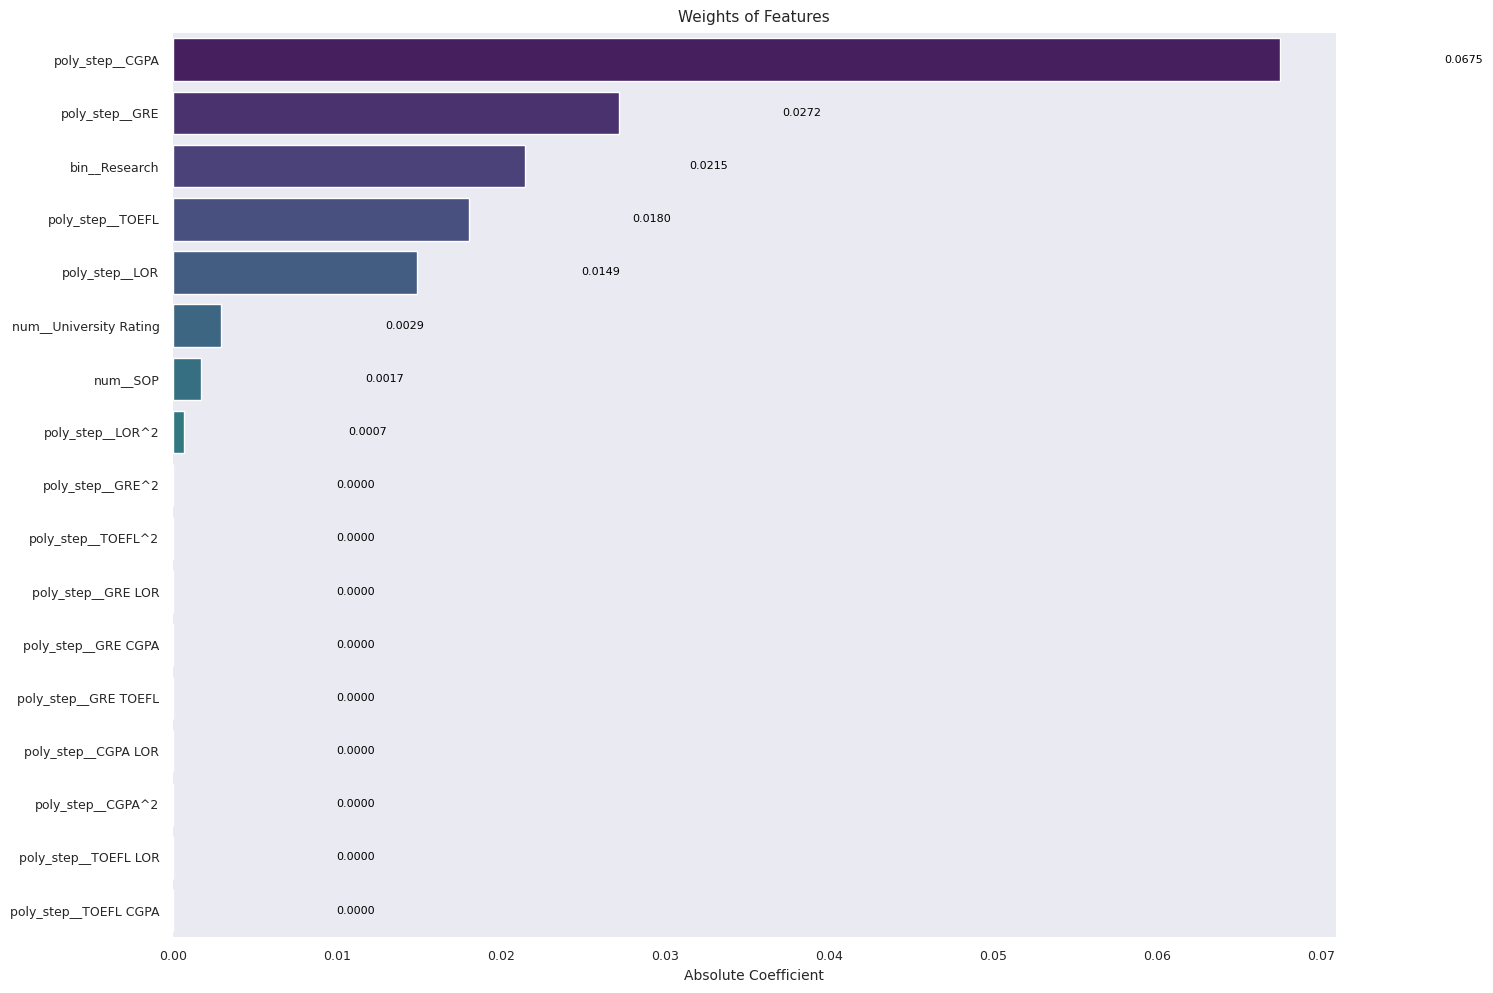

In [265]:
plot_model_weights(model_weights(poly_reg_elasticnet_model), fig_size = (15, 10))

In [266]:
y_pred_poly_elasticnet = poly_reg_elasticnet_model.predict(X_test)
y_pred_train_poly_elasticnet = poly_reg_elasticnet_model.predict(X_train)

In [267]:
scores(X_test, y_test, y_pred_poly_elasticnet, type = 'Polynomial Regression ElasticNet Test')

Polynomial Regression ElasticNet Test R²   : 0.8189
Polynomial Regression ElasticNet Test Adj.R² : 0.8051
Polynomial Regression ElasticNet Test RMSE: 0.0609
Polynomial Regression ElasticNet Test MSE : 0.0037
Polynomial Regression ElasticNet Test MAE : 0.0426


In [268]:
scores(X_train, y_train, y_pred_train_poly_elasticnet, type = 'Polynomial Regression ElasticNet Train')

Polynomial Regression ElasticNet Train R²   : 0.8210
Polynomial Regression ElasticNet Train Adj.R² : 0.8178
Polynomial Regression ElasticNet Train RMSE: 0.0594
Polynomial Regression ElasticNet Train MSE : 0.0035
Polynomial Regression ElasticNet Train MAE : 0.0425


#Model Performance and Evaluation

- The linear regression model explains about 82% of the variance in admission chance (R² ≈ 0.821, adjusted R² ≈ 0.818).

- We tried Linear Regression, Lasso, Ridge and ElasticNet and also polynomial regression and the all optimal models give similar performance.

- Crucially, the train and test performance are almost identical, indicating no major overfitting.

- In addition, diagnostic checks show the linear assumptions are mostly satisfied:
    - plotting residuals versus predicted values yielded an even, cloud-like scatter (no obvious funnel)
    - the Goldfeld Quantd test, and Breusch–Godfrey/Durbin-Watson tests gave p>0.05 indicating no heteroskedasticity or autocorrelation.
    - Variance Inflation Factors (VIF) for all features were below 5 (max ≈4.48 for GRE), so multicollinearity is modest.
    - One assumption did fail: a Shapiro–Wilk test gave p≤0.05, so the residuals deviate from normality. However, prediction accuracy is not severely harmed by this.
- In summary,all the model shows high predictive accuracy with low error.

#Features(Predictors) Significance and Importance

- The correlation heatmap highlights that CGPA has by far the strongest positive correlation with admission chance, followed by GRE and TOEFL.
- Features like SOP score and University Rating show very weak correlation, matching the regression results.
- In the fitted model,
    - the largest coefficient (in absolute terms) is for CGPA (~0.0676), and it is highly significant (p<0.001).
    - GRE score (coef ≈0.0267, p<0.001) and having Research experience (coef ≈0.0240, p=0.001) are the next most influential predictors.
    - TOEFL score (coef ≈0.0182, p=0.002) and LOR strength (coef ≈0.0159, p<0.001) have smaller but still positive impacts.
    - University Rating (coef≈0.0029, p≈0.547) and SOP score (coef≈0.0018, p≈0.721) had negligible coefficients and were not statistically significant.


# Actionable Insights & Recommendations

- Emphasize Academics: CGPA is by far the strongest predictor, so advising students on improving their coursework or offering tutoring in core subjects could yield big gains. For clients with borderline GPAs, extra academic coaching or preparation courses (e.g. advanced math/quantitative classes) might be prioritized.

- Strong GRE/TOEFL Score: Similarly, strong GRE scores significantly raise admission chances. Jamboree should continue intensive GRE prep, especially for students with weaker GRE profiles. TOEFL also matters (though less than GRE/CGPA), so language instruction could be adjusted to raise scores a few points.

- Encourage Research & LOR Quality: Since having research experience and strong letters are positively associated with admit chance, programs that help students secure internships, research projects, or publication opportunities will be beneficial. Training students on how to obtain and write solid letters of recommendation can also help.

- Given the model showed little gain from SOP or perceived university rating, it suggests diminishing returns in spending excessive effort on those areas. In practice, this doesn’t mean SOP is unimportant, but resources might be better spent on the high-impact factors above.

# Model Improvvement Measures

- To further enhance accuracy, Jamboree could consider collecting and adding more detailed data. For instance, rather than full score, one could measure specific sub-scores
    - GRE quant vs verbal
- Data on
    - extra-curricular achievements,
    - internships,
    - publications, or
    - interview performance

    might capture aspects of candidate strength not in the current features.

- Similarly, tracking actual admission outcomes year-to-year would allow model recalibration over time.

# Model implementation

- The analysis already used the scikit-learn pipeline (preprocessing + regression), which can be operationalized.
- The model should be retrained periodically on new data to account for changing admissions trends.

# Business Benefits

- The business advantages are substantial. Predictive analytics can reduce risk and improve decision-making.
    - By forecasting each student's admit probability, Jamboree can allocate resources more efficiently (focusing efforts on students who have the most to gain)
    - It can also personalize marketing: identifying high-potential segments to target versus those who may need more basic support.
    - These predictions "take the guesswork out of planning" and give Jamboree a competitive edge in decesion making.
    - Finally, understanding which students are most likely to succeed (or to complete their programs) can improve student outcomes andas well as Jamboree's success rates.
    - A good predictive model helps Jamboree advise students more effectively, allocate training resources wisely, and differentiate its services - all of which can drive higher satisfaction, better results for students, and stronger business performance.
